In [101]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [102]:
run ../util/setupConsole

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'era5'

useTrendMethod = True

yearRange = [1981, 2019]

In [104]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [105]:
# load gdd/kdd from cpc temperature data
if wxData == 'gldas':
    gdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
    
    for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
        with gzip.open('%s/kdd-cpc-%s-%d.dat'%(dataDirDiscovery, crop, year), 'rb') as f:
            curKdd = pickle.load(f)
            kdd[:, :, y] = curKdd

        with gzip.open('%s/gdd-cpc-%s-%d.dat'%(dataDirDiscovery, crop, year), 'rb') as f:
            curGdd = pickle.load(f)
            gdd[:, :, y] = curGdd
    
    with gzip.open('%s/gdd-kdd-lat-cpc.dat'%(dataDirDiscovery), 'rb') as f:
        lat = pickle.load(f)

    with gzip.open('%s/gdd-kdd-lon-cpc.dat'%(dataDirDiscovery), 'rb') as f:
        lon = pickle.load(f)
        
elif wxData == 'era5':
    gdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)

    for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
        with gzip.open('%s/kdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
            curKdd = pickle.load(f)
            kdd[:, :, y] = curKdd

        with gzip.open('%s/gdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
            curGdd = pickle.load(f)
            gdd[:, :, y] = curGdd

    with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
        lat = pickle.load(f)

    with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
        lon = pickle.load(f)


In [107]:
if wxData == 'era5':

    with open('%s/seasonal-et-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalEvap = pickle.load(f)
    with open('%s/seasonal-t-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalT = pickle.load(f)
    with open('%s/seasonal-sshf-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSshf = pickle.load(f)
    with open('%s/seasonal-slhf-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSlhf = pickle.load(f)
    with open('%s/seasonal-ssr-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSsr = pickle.load(f)
    with open('%s/seasonal-str-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalStr = pickle.load(f)
    with open('%s/seasonal-precip-maize-era5.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
        # m -> mm
        seasonalPrecip *= 1000
        seasonalPrecip[seasonalPrecip==0] = np.nan
    with open('%s/seasonal-u10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalU10 = pickle.load(f)
    with open('%s/seasonal-v10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalV10 = pickle.load(f)
    with open('%s/seasonal-seconds-maize.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSeconds = pickle.load(f)
        seasonalSeconds[seasonalSeconds<0] = -seasonalSeconds[seasonalSeconds<0]

elif wxData == 'gldas':
    with open('%s/seasonal-sshf-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSshf_Noah = -pickle.load(f)
    with open('%s/seasonal-slhf-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSlhf_Noah = -pickle.load(f)
    with open('%s/seasonal-precip-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalPrecip_Noah = pickle.load(f)
    with open('%s/seasonal-str-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalStr_Noah = pickle.load(f)
    with open('%s/seasonal-ssr-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSsr_Noah = pickle.load(f)
    with open('%s/seasonal-wind-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalWind_Noah = pickle.load(f)

    with open('%s/seasonal-sshf-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSshf_Vic = -pickle.load(f)
    with open('%s/seasonal-slhf-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSlhf_Vic = -pickle.load(f)
    with open('%s/seasonal-precip-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalPrecip_Vic = pickle.load(f)
    with open('%s/seasonal-str-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalStr_Vic = pickle.load(f)
    with open('%s/seasonal-ssr-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalSsr_Vic = pickle.load(f)
    with open('%s/seasonal-wind-maize-gldas-vic.dat'%(dataDirDiscovery), 'rb') as f:
        seasonalWind_Vic = pickle.load(f)
        
    seasonalSshf = (seasonalSshf_Noah + seasonalSshf_Vic)/2
    seasonalSlhf = (seasonalSlhf_Noah + seasonalSlhf_Vic)/2
    seasonalPrecip = (seasonalPrecip_Noah + seasonalPrecip_Vic)/2
    seasonalStr = (seasonalStr_Noah + seasonalStr_Vic)/2
    seasonalSsr = (seasonalSsr_Noah + seasonalSsr_Vic)/2
    seasonalWind = (seasonalWind_Noah + seasonalWind_Vic)/2


In [108]:

if wxData == 'era5':
    # calculate gdd and kdd trends from already-loaded cpc tmax and tmin data
    with open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)
        kddTrends *= 10

    with open('%s/kdd-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrendSig = pickle.load(f)

    with open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
        gddTrends *= 10

    with open('%s/gdd-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrendSig = pickle.load(f)

    with open('%s/evap-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        evapTrends = pickle.load(f)
    
    with open('%s/t-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        tTrends = pickle.load(f)
        tTrends *= 10

    with open('%s/t-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        tTrendSig = pickle.load(f)
        
    with open('%s/pr-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrends = pickle.load(f)
        prTrends *= 10 * 1000

    with open('%s/pr-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrendSig = pickle.load(f)

    with open('%s/sshf-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrends = pickle.load(f)
        sshfTrends /= seasonalSeconds
        sshfTrends *= 10

    with open('%s/sshf-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrendSig = pickle.load(f)

    with open('%s/slhf-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrends = pickle.load(f)
        slhfTrends /= seasonalSeconds
        slhfTrends *= 10

    with open('%s/slhf-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrendSig = pickle.load(f)

    with open('%s/ef-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrends = pickle.load(f)
        efTrends *= 10

    with open('%s/ef-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrendSig = pickle.load(f)

    with open('%s/netrad-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrends = pickle.load(f)
        netRadTrends /= seasonalSeconds
        netRadTrends *= 10

    with open('%s/netrad-%s-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrendSig = pickle.load(f)
        
elif wxData == 'gldas':
    # calculate gdd and kdd trends from already-loaded cpc tmax and tmin data
    with open('%s/kdd-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)
        kddTrends *= 10

    with open('%s/kdd-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        kddTrendSig = pickle.load(f)

    with open('%s/gdd-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
        gddTrends *= 10

    with open('%s/gdd-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        gddTrendSig = pickle.load(f)

        
    with open('%s/pr-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrends_Noah = pickle.load(f)
#         prTrends *= 10 * 1000
    with open('%s/pr-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrendSig_Noah = pickle.load(f)
    with open('%s/pr-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrends_Vic = pickle.load(f)
#         prTrends *= 10 * 1000
    with open('%s/pr-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        prTrendSig_Vic = pickle.load(f)
    prTrends = (prTrends_Noah + prTrends_Vic)/2
    prTrendSig = np.round((prTrendSig_Noah + prTrendSig_Vic)/2)
        
    with open('%s/sshf-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrends_Noah = pickle.load(f)
        sshfTrends_Noah *= -10
    with open('%s/sshf-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrendSig_Noah = pickle.load(f)
    with open('%s/sshf-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrends_Vic = pickle.load(f)
        sshfTrends_Vic *= -10
    with open('%s/sshf-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        sshfTrendSig_Vic = pickle.load(f)
    sshfTrends = (sshfTrends_Noah + sshfTrends_Vic)/2
    sshfTrendSig = np.round((sshfTrendSig_Noah + sshfTrendSig_Vic)/2)
        
    with open('%s/slhf-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrends_Noah = pickle.load(f)
        slhfTrends_Noah *= -10
    with open('%s/slhf-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrendSig_Noah = pickle.load(f)
    with open('%s/slhf-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrends_Vic = pickle.load(f)
        slhfTrends_Vic *= -10
    with open('%s/slhf-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        slhfTrendSig_Vic = pickle.load(f)
    slhfTrends = (slhfTrends_Noah + slhfTrends_Vic)/2
    slhfTrendSig = np.round((slhfTrendSig_Noah + slhfTrendSig_Vic)/2)
        
    with open('%s/ef-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrends_Noah = pickle.load(f)
        efTrends_Noah *= 10
    with open('%s/ef-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrendSig_Noah = pickle.load(f)
    with open('%s/ef-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrends_Vic = pickle.load(f)
        efTrends_Vic *= 10
    with open('%s/ef-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        efTrendSig_Vic = pickle.load(f)
    efTrends = (efTrends_Noah + efTrends_Vic)/2
    efTrendSig = np.round((efTrendSig_Noah + efTrendSig_Vic)/2)
        
    with open('%s/netrad-gldas-noah-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrends_Noah = pickle.load(f)
        netRadTrends_Noah *= 10
    with open('%s/netrad-gldas-noah-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrendSig_Noah = pickle.load(f)
    with open('%s/netrad-gldas-vic-trends-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrends_Vic = pickle.load(f)
        netRadTrends_Vic *= 10
    with open('%s/netrad-gldas-vic-trends-sig-%s-%d-%d.dat'%(dataDirDiscovery, crop, yearRange[0], yearRange[1]), 'rb') as f:
        netRadTrendSig_Vic = pickle.load(f)
    netRadTrends = (netRadTrends_Noah + netRadTrends_Vic)/2
    netRadTrendSig = np.round((netRadTrendSig_Noah + netRadTrendSig_Vic)/2)

In [109]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dataDirDiscovery
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

In [110]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dataDirDiscovery)
sacksMaizeStart = sacksMaizeNc['plant'].values + 1
sacksMaizeStart = np.roll(sacksMaizeStart, -int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeStart[sacksMaizeStart < 0] = np.nan
sacksMaizeEnd = sacksMaizeNc['harvest'].values + 1
sacksMaizeEnd = np.roll(sacksMaizeEnd, -int(sacksMaizeEnd.shape[1]/2), axis=1)
sacksMaizeEnd[sacksMaizeEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

sacksSoybeanNc = xr.open_dataset('%s/sacks/Soybeans.crop.calendar.fill.nc'%dataDirDiscovery)
sacksSoybeanStart = sacksSoybeanNc['plant'].values + 1
sacksSoybeanStart = np.roll(sacksSoybeanStart, -int(sacksSoybeanStart.shape[1]/2), axis=1)
sacksSoybeanStart[sacksSoybeanStart < 0] = np.nan
sacksSoybeanEnd = sacksSoybeanNc['harvest'].values + 1
sacksSoybeanEnd = np.roll(sacksSoybeanEnd, -int(sacksSoybeanEnd.shape[1]/2), axis=1)
sacksSoybeanEnd[sacksSoybeanEnd < 0] = np.nan


In [111]:
# cRange=[0, 100]
# plt.figure(figsize=(10,7))
# ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.pcolormesh(irrigationLon, irrigationLat, np.clip(irrigationData, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1])
# cbar = plt.colorbar(c, orientation='horizontal', pad = 0.01)
# cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 10))
# cbar.set_label('%s irrigation fraction'%crop)
# ax.coastlines()

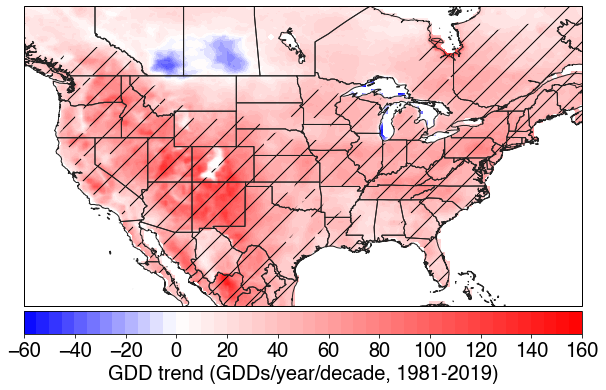

In [112]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

v1 = -60
v2 = 161
vstep = 5
vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(lon, lat, gddTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('GDD trend (GDDs/year/decade, 1981-2019)', fontsize=20)
# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

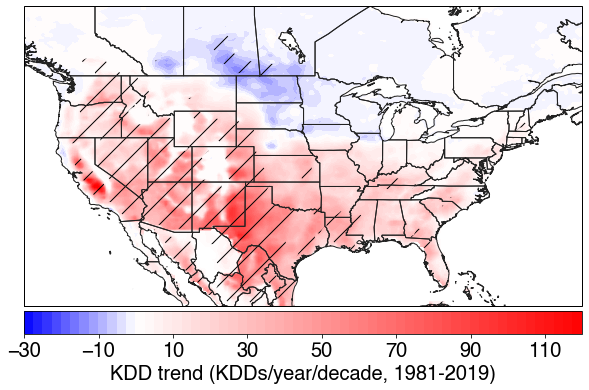

In [113]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

v1 = -30
v2 = 121
vstep = 2.5
vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(lon, lat, kddTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(lon, lat, kddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('KDD trend (KDDs/year/decade, 1981-2019)', fontsize=20)
# if wxData == 'gldas':
#     plt.savefig('obs-kdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-kdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

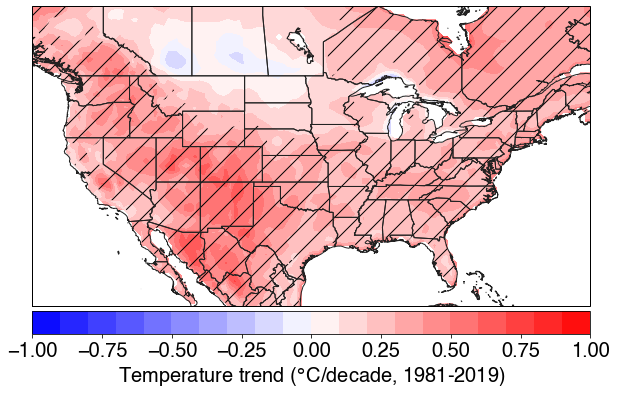

In [143]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(sacksLon, sacksLat, tTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, tTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Temperature trend ($\degree$C/decade, 1981-2019)', fontsize=20)
plt.savefig('obs-t-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

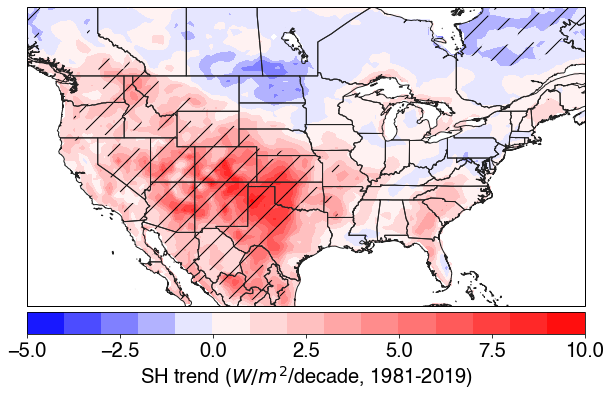

In [116]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

if 'gldas' in wxData:
    v1 = -15
    v2 = 15.1
    vstep = 1
    vlabelstep = 5
else:
    v1 = -5
    v2 = 10.1
    vstep = 1
    vlabelstep = 2.5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(sacksLon, sacksLat, -sshfTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, sshfTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('SH trend ($W/m^2$/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-sh-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

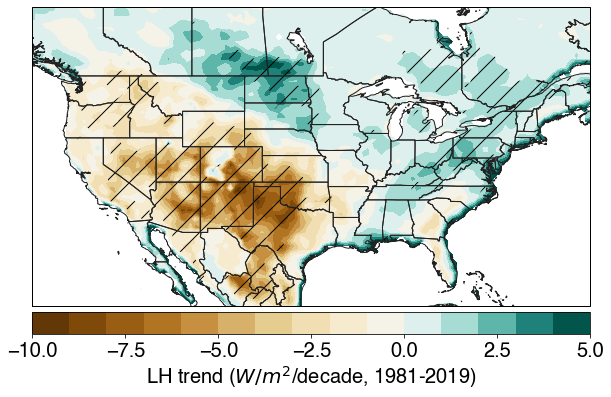

In [117]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

if 'gldas' in wxData:
    v1 = -10
    v2 = 15.1
    vstep = 1
    vlabelstep = 5
else:
    v1 = -10
    v2 = 5.1
    vstep = 1
    vlabelstep = 2.5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')
c = plt.contourf(sacksLon, sacksLat, -slhfTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, slhfTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('LH trend ($W/m^2$/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-lh-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

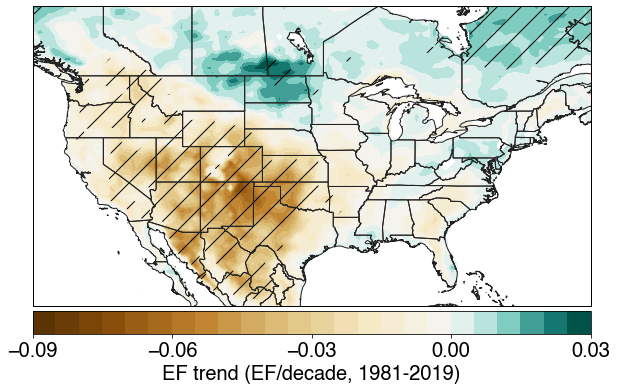

In [118]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

if 'gldas' in wxData:
    v1 = -.09
    v2 = .121
    vstep = .005
    vlabelstep = .03
else:
    v1 = -.09
    v2 = .031
    vstep = .005
    vlabelstep = .03

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')
c = plt.contourf(sacksLon, sacksLat, efTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, efTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('EF trend (EF/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-ef-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

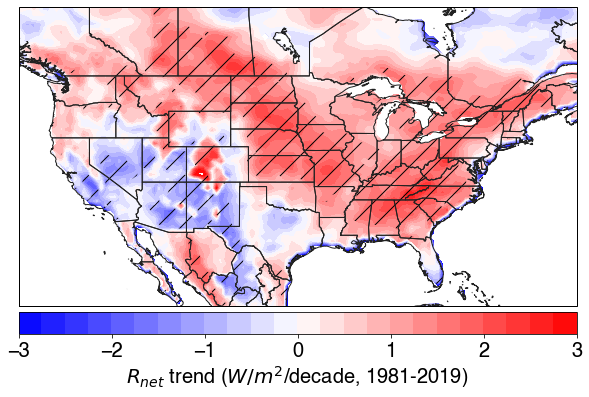

In [119]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

if 'gldas' in wxData:
    v1 = -3
    v2 = 15.01
    vstep = 1
    vlabelstep = 3
else:
    v1 = -3
    v2 = 3.01
    vstep = .25
    vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(sacksLon, sacksLat, netRadTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, netRadTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('$R_{net}$ trend ($W/m^2$/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-netrad-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

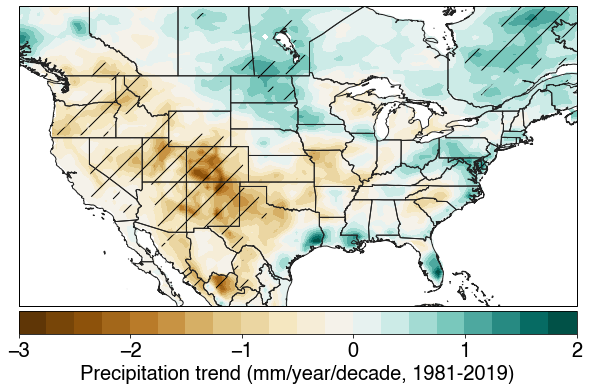

In [120]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -65, 23, 53])

v1 = -3
v2 = 2.1
vstep = .25
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')
c = plt.contourf(sacksLon, sacksLat, prTrends, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(sacksLon, sacksLat, prTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Precipitation trend (mm/year/decade, 1981-2019)', fontsize=20)
# plt.savefig('obs-pr-trend-%s.png'%wxData, format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [121]:
# load NASS yield data

nassCountyArea = pd.read_csv('%s/nass/maize-county-area.csv'%dataDirDiscovery)

nassMaizePlantedArea1 = pd.read_csv('%s/nass/maize-area-planted-1961-1974.csv'%dataDirDiscovery)
nassMaizePlantedArea2 = pd.read_csv('%s/nass/maize-area-planted-1975-1994.csv'%dataDirDiscovery)
nassMaizePlantedArea3 = pd.read_csv('%s/nass/maize-area-planted-1995-2019.csv'%dataDirDiscovery)
nassMaizePlantedArea = pd.concat([nassMaizePlantedArea1[::-1], nassMaizePlantedArea2[::-1], nassMaizePlantedArea3[::-1]])

nassMaizeHarvestedArea1 = pd.read_csv('%s/nass/maize-area-harvested-1961-1969.csv'%dataDirDiscovery)
nassMaizeHarvestedArea2 = pd.read_csv('%s/nass/maize-area-harvested-1970-1981.csv'%dataDirDiscovery)
nassMaizeHarvestedArea3 = pd.read_csv('%s/nass/maize-area-harvested-1982-2001.csv'%dataDirDiscovery)
nassMaizeHarvestedArea4 = pd.read_csv('%s/nass/maize-area-harvested-2002-2019.csv'%dataDirDiscovery)
nassMaizeHarvestedArea = pd.concat([nassMaizeHarvestedArea1[::-1], nassMaizeHarvestedArea2[::-1], \
                                    nassMaizeHarvestedArea3[::-1], nassMaizeHarvestedArea4[::-1]])

nassSoybeanHarvestedArea1 = pd.read_csv('%s/nass/soybean-area-harvested-1961-1969.csv'%dataDirDiscovery)
nassSoybeanHarvestedArea2 = pd.read_csv('%s/nass/soybean-area-harvested-1970-1995.csv'%dataDirDiscovery)
nassSoybeanHarvestedArea3 = pd.read_csv('%s/nass/soybean-area-harvested-1996-2019.csv'%dataDirDiscovery)
nassSoybeanHarvestedArea = pd.concat([nassSoybeanHarvestedArea1[::-1], nassSoybeanHarvestedArea2[::-1], \
                                    nassSoybeanHarvestedArea3[::-1]])

nassMaizeProd1 = pd.read_csv('%s/nass/nass-maize-production-1961-1974.csv'%dataDirDiscovery)
nassMaizeProd2 = pd.read_csv('%s/nass/nass-maize-production-1975-1994.csv'%dataDirDiscovery)
nassMaizeProd3 = pd.read_csv('%s/nass/nass-maize-production-1995-2019.csv'%dataDirDiscovery)
nassMaizeProd = pd.concat([nassMaizeProd1[::-1], nassMaizeProd2[::-1], nassMaizeProd3[::-1]])

nassMaizeYield1 = pd.read_csv('%s/nass/maize-yield-1961-1978.csv'%dataDirDiscovery)
nassMaizeYield2 = pd.read_csv('%s/nass/maize-yield-1979-1998.csv'%dataDirDiscovery)
nassMaizeYield3 = pd.read_csv('%s/nass/maize-yield-1999-2019.csv'%dataDirDiscovery)
nassMaizeYield = pd.concat([nassMaizeYield1[::-1], nassMaizeYield2[::-1], nassMaizeYield3[::-1]])

nassSoybeanYield1 = pd.read_csv('%s/nass/soybean-yield-1961-1989.csv'%dataDirDiscovery)
nassSoybeanYield2 = pd.read_csv('%s/nass/soybean-yield-1990-2019.csv'%dataDirDiscovery)
nassSoybeanYield = pd.concat([nassSoybeanYield1[::-1], nassSoybeanYield2[::-1]])



In [122]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [123]:
nassMaizeStates = list(nassMaizeYield['State'])
nassMaizeStateAbvs = []
for s in nassMaizeStates:
    nassMaizeStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizeYield['StateAbvs'] = nassMaizeStateAbvs

nassSoybeanStates = list(nassSoybeanYield['State'])
nassSoybeanStateAbvs = []
for s in nassSoybeanStates:
    nassSoybeanStateAbvs.append(usStateAbbrev[s.lower().title()])
nassSoybeanYield['StateAbvs'] = nassSoybeanStateAbvs

nassMaizeProdStates = list(nassMaizeProd['State'])
nassMaizeProdStateAbvs = []
for s in nassMaizeProdStates:
    nassMaizeProdStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizeProd['StateAbvs'] = nassMaizeProdStateAbvs

nassMaizePlantedAreaStates = list(nassMaizePlantedArea['State'])
nassMaizePlantedAreaStateAbvs = []
for s in nassMaizePlantedAreaStates:
    nassMaizePlantedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizePlantedArea['StateAbvs'] = nassMaizePlantedAreaStateAbvs

nassMaizeHarvestedAreaStates = list(nassMaizeHarvestedArea['State'])
nassMaizeHarvestedAreaStateAbvs = []
for s in nassMaizeHarvestedAreaStates:
    nassMaizeHarvestedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizeHarvestedArea['StateAbvs'] = nassMaizeHarvestedAreaStateAbvs

nassSoybeanHarvestedAreaStates = list(nassSoybeanHarvestedArea['State'])
nassSoybeanHarvestedAreaStateAbvs = []
for s in nassSoybeanHarvestedAreaStates:
    nassSoybeanHarvestedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassSoybeanHarvestedArea['StateAbvs'] = nassSoybeanHarvestedAreaStateAbvs

nassCountyAreaStates = list(nassCountyArea['State'])
nassCountyAreaStateAbvs = []
for s in nassCountyAreaStates:
    nassCountyAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassCountyArea['StateAbvs'] = nassCountyAreaStateAbvs

In [124]:
maizeYieldDeepak = []
for year in range(1981, 2013+1):
    curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    if len(maizeYieldDeepak) == 0:
        maizeYieldDeepak = curMaizeYield
    else:
        maizeYieldDeepak = xr.concat([maizeYieldDeepak, curMaizeYield], dim='time')
    
maizeYieldDeepak.load()

# flip latitude axis so top is +90
latDeepak = np.flipud(maizeYieldDeepak.latitude)
lonDeepak = np.roll(maizeYieldDeepak.longitude, int(len(maizeYieldDeepak.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYieldDeepak['Data'] = maizeYieldDeepak.Data.transpose('latitude', 'longitude', 'time', 'level')
maizeYieldDeepakData = np.roll(np.flip(maizeYieldDeepak.Data, axis=0), int(len(maizeYieldDeepak.longitude)/2), axis=1)

maizeYieldDeepak['latitude'] = latDeepak
maizeYieldDeepak['longitude'] = lonDeepak
maizeYieldDeepak['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(maizeYieldDeepakData))

In [125]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i, val in enumerate(data):
        # start sequence
        if ~np.isnan(val) and ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif (np.isnan(val) and ptCur[0] >= 0):
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptCur = (-1, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
    return ptMax

In [126]:
minCropYears = 10
minCropYearsDeepak = 10

rebuild=False

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))
else:
    usCounties = gpd.read_file('%s/us-county-lat-long/c_02jn20.shp'%dataDirDiscovery)

    usCounties['temp'] = np.full(len(usCounties), np.nan)
    usCounties['tempLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['tempLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['gdd'] = np.full(len(usCounties), np.nan)
    usCounties['kdd'] = np.full(len(usCounties), np.nan)
    usCounties['gddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecip'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvap'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSeconds'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalT'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalTTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalTDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalTDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSshf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSlhf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalEf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEfTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSsr'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalStr'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalNetRad'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalNetRadTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalNetRadDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalNetRadDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalU10'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10Trend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10Detrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10DetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalV10'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10Trend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10Detrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10DetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizePlantingDate'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestDate'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanPlantingDate'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestDate'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeCountyArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizeCountyIrrigationFraction'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizePlantedArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeHarvestedArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['soybeanHarvestedArea'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeYield'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendPlusMean'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendPlusMeanDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldYears'] = np.full(len(usCounties), np.nan)
    
    usCounties['soybeanYield'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendPlusMean'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendPlusMeanDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldYears'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeProd'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdYears'] = np.full(len(usCounties), np.nan)

    # this is needed to store list in dataframe... kind of hacky
    usCounties = usCounties.astype(object)

    for c in range(usCounties.shape[0]):
        
        if c % 100 == 0:
            print('%.0f %% done'%(c/usCounties.shape[0]*100))
        
        bounds = usCounties['geometry'][c].bounds
        lat1 = bounds[1]
        lat2 = bounds[3]
        lon1 = bounds[0]
        lon2 = bounds[2]

        if lon1 < 0: lon1 += 360
        if lon2 < 0: lon2 += 360
            

        deepakLatInds = [np.where(abs(latDeepak-lat2) == np.nanmin(abs(latDeepak-lat2)))[0][0],
                   np.where(abs(latDeepak-lat1) == np.nanmin(abs(latDeepak-lat1)))[0][0]]
        deepakLonInds = [np.where(abs(lonDeepak-lon1) == np.nanmin(abs(lonDeepak-lon1)))[0][0],
                   np.where(abs(lonDeepak-lon2) == np.nanmin(abs(lonDeepak-lon2)))[0][0]]
            
        tempLatInds = [np.where(abs(lat-lat2) == np.nanmin(abs(lat-lat2)))[0][0],
                   np.where(abs(lat-lat1) == np.nanmin(abs(lat-lat1)))[0][0]]
        tempLonInds = [np.where(abs(lon-lon1) == np.nanmin(abs(lon-lon1)))[0][0],
                   np.where(abs(lon-lon2) == np.nanmin(abs(lon-lon2)))[0][0]]
        
        prLatInds = [np.where(abs(sacksLat-lat2) == np.nanmin(abs(sacksLat-lat2)))[0][0],
                   np.where(abs(sacksLat-lat1) == np.nanmin(abs(sacksLat-lat1)))[0][0]]
        prLonInds = [np.where(abs(sacksLon-lon1) == np.nanmin(abs(sacksLon-lon1)))[0][0],
                   np.where(abs(sacksLon-lon2) == np.nanmin(abs(sacksLon-lon2)))[0][0]]
    
        irrLatInds = [np.where(abs(irrigationLat-lat2) == np.nanmin(abs(irrigationLat-lat2)))[0][0],
                   np.where(abs(irrigationLat-lat1) == np.nanmin(abs(irrigationLat-lat1)))[0][0]]
        irrLonInds = [np.where(abs(irrigationLon-lon1) == np.nanmin(abs(irrigationLon-lon1)))[0][0],
                   np.where(abs(irrigationLon-lon2) == np.nanmin(abs(irrigationLon-lon2)))[0][0]]
        
        if len(tempLatInds) == 0 or len(tempLonInds) == 0 or \
           len(prLatInds) == 0 or len(prLonInds) == 0:
            continue

        usCounties['tempLatInds'][c] = tempLatInds
        usCounties['tempLonInds'][c] = tempLonInds
        
        usCounties['prLatInds'][c] = prLatInds
        usCounties['prLonInds'][c] = prLonInds
        
        deepakLatIndsRange = np.arange(min(deepakLatInds), max(deepakLatInds)+1)
        deepakLonIndsRange = np.arange(min(deepakLonInds), max(deepakLonInds)+1)
        
        if len(deepakLatInds) > 1:
            countyMaizeYieldDeepak = np.nanmean(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :], axis=0)
        else:
            countyMaizeYieldDeepak = np.squeeze(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :])
        
        if len(deepakLonInds) > 1:
            countyMaizeYieldDeepak = np.nanmean(countyMaizeYieldDeepak[deepakLonIndsRange, :], axis=0)
        else:
            countyMaizeYieldDeepak = np.squeeze(countyMaizeYieldDeepak[deepakLonIndsRange, :])
        
        # add padding so yield array is same length as nass arrays
        countyMaizeYieldDeepak = np.pad(countyMaizeYieldDeepak, (0, 5), 'constant', constant_values=(np.nan))
        
        tempLatIndsRange = np.arange(min(tempLatInds), max(tempLatInds)+1)
        tempLonIndsRange = np.arange(min(tempLonInds), max(tempLonInds)+1)
        
        prLatIndsRange = np.arange(min(prLatInds), max(prLatInds)+1)
        prLonIndsRange = np.arange(min(prLonInds), max(prLonInds)+1)
        
        irrLatIndsRange = np.arange(min(irrLatInds), max(irrLatInds)+1)
        irrLonIndsRange = np.arange(min(irrLonInds), max(irrLonInds)+1)

        if len(tempLatIndsRange) > 1:
            countyGdd = np.nanmean(gdd[tempLatIndsRange, :, :], axis=0)
            countyKdd = np.nanmean(kdd[tempLatIndsRange, :, :], axis=0)
        else:
            countyGdd = np.squeeze(gdd[tempLatIndsRange, :, :])
            countyKdd = np.squeeze(kdd[tempLatIndsRange, :, :])
        
        if len(prLatIndsRange) > 1:
            countyPrecip = np.nanmean(seasonalPrecip[prLatIndsRange, :, :], axis=0)
            countyT = np.nanmean(seasonalT[prLatIndsRange, :, :], axis=0)
            countySshf = np.nanmean(seasonalSshf[prLatIndsRange, :, :], axis=0)
            countySlhf = np.nanmean(seasonalSlhf[prLatIndsRange, :, :], axis=0)
            countySsr = np.nanmean(seasonalSsr[prLatIndsRange, :, :], axis=0)
            countyStr = np.nanmean(seasonalStr[prLatIndsRange, :, :], axis=0)
            
            if 'gldas' in wxData:
                countyU10 = np.nanmean(seasonalWind_Noah[prLatIndsRange, :, :], axis=0)
                countyV10 = np.nanmean(seasonalWind_Noah[prLatIndsRange, :, :], axis=0)
            else:
                countyU10 = np.nanmean(seasonalU10[prLatIndsRange, :, :], axis=0)
                countyV10 = np.nanmean(seasonalV10[prLatIndsRange, :, :], axis=0)
                
            if wxData == 'era5':
                countySeasonalSeconds = np.nanmean(seasonalSeconds[prLatIndsRange, :], axis=0)
            
            countyMaizePlantDate = np.nanmean(sacksMaizeStart[prLatIndsRange, :], axis=0)
            countySoybeanPlantDate = np.nanmean(sacksSoybeanStart[prLatIndsRange, :], axis=0)
            countyMaizeHarvestDate = np.nanmean(sacksMaizeEnd[prLatIndsRange, :], axis=0)
            countySoybeanHarvestDate = np.nanmean(sacksSoybeanEnd[prLatIndsRange, :], axis=0)
        else:
            countyPrecip = np.squeeze(seasonalPrecip[prLatIndsRange, :, :])
            countyT = np.squeeze(seasonalT[prLatIndsRange, :, :])
            countySshf = np.squeeze(seasonalSshf[prLatIndsRange, :, :])
            countySlhf = np.squeeze(seasonalSlhf[prLatIndsRange, :, :])
            countySsr = np.squeeze(seasonalSsr[prLatIndsRange, :, :])
            countyStr = np.squeeze(seasonalStr[prLatIndsRange, :, :])
            
            if 'gldas' in wxData:
                countyU10 = np.squeeze(seasonalWind_Noah[prLatIndsRange, :, :])
                countyV10 = np.squeeze(seasonalWind_Noah[prLatIndsRange, :, :])
            else:
                countyU10 = np.squeeze(seasonalU10[prLatIndsRange, :, :])
                countyV10 = np.squeeze(seasonalV10[prLatIndsRange, :, :])
            
            if wxData == 'era5':
                countySeasonalSeconds = np.squeeze(seasonalSeconds[prLatIndsRange, :])
            
            countyMaizePlantDate = np.squeeze(sacksMaizeStart[prLatIndsRange, :])
            countySoybeanPlantDate = np.squeeze(sacksSoybeanStart[prLatIndsRange, :])
            countyMaizeHarvestDate = np.squeeze(sacksMaizeEnd[prLatIndsRange, :])
            countySoybeanHarvestDate = np.squeeze(sacksSoybeanEnd[prLatIndsRange, :])

        if len(tempLonIndsRange) > 1:
            countyGdd = np.nanmean(countyGdd[tempLonIndsRange, :], axis=0)
            countyKdd = np.nanmean(countyKdd[tempLonIndsRange, :], axis=0)
        else:
            countyGdd = np.squeeze(countyGdd[tempLonIndsRange, :])
            countyKdd = np.squeeze(countyKdd[tempLonIndsRange, :])
        
        if len(prLonIndsRange) > 1:
            countyPrecip = np.nanmean(countyPrecip[prLonIndsRange, :], axis=0)
            countyT = np.nanmean(countyT[prLonIndsRange, :], axis=0)
            countySshf = np.nanmean(countySshf[prLonIndsRange, :], axis=0)
            countySlhf = np.nanmean(countySlhf[prLonIndsRange, :], axis=0)
            countySsr = np.nanmean(countySsr[prLonIndsRange, :], axis=0)
            countyStr = np.nanmean(countyStr[prLonIndsRange, :], axis=0)
            countyU10 = np.nanmean(countyU10[prLonIndsRange, :], axis=0)
            countyV10 = np.nanmean(countyV10[prLonIndsRange, :], axis=0)                
            
            if wxData == 'era5':
                countySeasonalSeconds = np.nanmean(countySeasonalSeconds[prLonIndsRange], axis=0)
            
            countyMaizePlantDate = np.nanmean(countyMaizePlantDate[prLonIndsRange], axis=0)
            countySoybeanPlantDate = np.nanmean(countySoybeanPlantDate[prLonIndsRange], axis=0)
            countyMaizeHarvestDate = np.nanmean(countyMaizeHarvestDate[prLonIndsRange], axis=0)
            countySoybeanHarvestDate = np.nanmean(countySoybeanHarvestDate[prLonIndsRange], axis=0)
        else:
            countyPrecip = np.squeeze(countyPrecip[prLonIndsRange, :])
            countyT = np.squeeze(countyT[prLonIndsRange, :])
            countySshf = np.squeeze(countySshf[prLonIndsRange, :])
            countySlhf = np.squeeze(countySlhf[prLonIndsRange, :])
            countySsr = np.squeeze(countySsr[prLonIndsRange, :])
            countyStr = np.squeeze(countyStr[prLonIndsRange, :])
            countyU10 = np.squeeze(countyU10[prLonIndsRange, :])
            countyV10 = np.squeeze(countyV10[prLonIndsRange, :])
            
            if wxData == 'era5':
                countySeasonalSeconds = np.squeeze(countySeasonalSeconds[prLonIndsRange])
            
            countyMaizePlantDate = np.squeeze(countyMaizePlantDate[prLonIndsRange])
            countySoybeanPlantDate = np.squeeze(countySoybeanPlantDate[prLonIndsRange])
            countyMaizeHarvestDate = np.squeeze(countyMaizeHarvestDate[prLonIndsRange])
            countySoybeanHarvestDate = np.squeeze(countySoybeanHarvestDate[prLonIndsRange])

        if wxData == 'era5':
            usCounties['seasonalSeconds'][c] = countySeasonalSeconds
        
        usCounties['maizePlantingDate'][c] = countyMaizePlantDate
        usCounties['soybeanPlantingDate'][c] = countySoybeanPlantDate
        usCounties['maizeHarvestDate'][c] = countyMaizeHarvestDate
        usCounties['soybeanHarvestDate'][c] = countySoybeanHarvestDate
            
        if len(irrLatIndsRange) > 1:
            countyIrrigation = np.nanmean(irrigationData[irrLatIndsRange, :], axis=0)
        else:
            countyIrrigation = np.squeeze(irrigationData[irrLatIndsRange, :])
        
        if len(irrLonIndsRange) > 1:
            countyIrrigation = np.nanmean(countyIrrigation[irrLonIndsRange])
        else:
            countyIrrigation = np.squeeze(countyIrrigation[irrLonIndsRange])
        
        usCounties['maizeCountyIrrigationFraction'][c] = countyIrrigation
        
        curCountyName = usCounties['COUNTYNAME'][c].lower()
        nassMaizeYieldCounties = np.array(list(map(str.lower, nassMaizeYield['County'])))
        nassMaizeProdCounties = np.array(list(map(str.lower, nassMaizeProd['County'])))
        nassMaizePlantedAreaCounties = np.array(list(map(str.lower, nassMaizePlantedArea['County'])))
        nassMaizeHarvestedAreaCounties = np.array(list(map(str.lower, nassMaizeHarvestedArea['County'])))
        nassCountyAreaCounties = np.array(list(map(str.lower, nassCountyArea['County'])))
        
        curStateName = usCounties['STATE'][c].lower()
        nassMaizeYieldStates = np.array(list(map(str.lower, nassMaizeYield['StateAbvs'])))
        nassMaizeProdStates = np.array(list(map(str.lower, nassMaizeProd['StateAbvs'])))
        nassMaizePlantedAreaStates = np.array(list(map(str.lower, nassMaizePlantedArea['StateAbvs'])))
        nassMaizeHarvestedAreaStates = np.array(list(map(str.lower, nassMaizeHarvestedArea['StateAbvs'])))
        nassCountyAreaStates = np.array(list(map(str.lower, nassCountyArea['StateAbvs'])))

        countyIndMaizeYield = np.where((curCountyName == nassMaizeYieldCounties) & (curStateName == nassMaizeYieldStates))[0]
        countyIndMaizeProd = np.where((curCountyName == nassMaizeProdCounties) & (curStateName == nassMaizeProdStates))[0]
        countyIndMaizePlantedArea = np.where((curCountyName == nassMaizePlantedAreaCounties) & (curStateName == nassMaizePlantedAreaStates))[0]
        countyIndMaizeHarvestedArea = np.where((curCountyName == nassMaizeHarvestedAreaCounties) & (curStateName == nassMaizeHarvestedAreaStates))[0]
        countyIndCountyArea = np.where((curCountyName == nassCountyAreaCounties) & (curStateName == nassCountyAreaStates))[0]

        curCountyMaizeYieldYears = np.array(list(nassMaizeYield['Year']))
        curCountyMaizeYieldYears = curCountyMaizeYieldYears[countyIndMaizeYield]

        curCountyMaizeYield = np.array(list(nassMaizeYield['Value']))
        curCountyMaizeYield = curCountyMaizeYield[countyIndMaizeYield]
        
        curCountyMaizeProdYears = np.array(list(nassMaizeProd['Year']))
        curCountyMaizeProdYears = curCountyMaizeProdYears[countyIndMaizeProd]
        
        curCountyMaizeProd = np.array(list(nassMaizeProd['Value']))
        curCountyMaizeProd = curCountyMaizeProd[countyIndMaizeProd]
        
        curCountyMaizePlantedAreaYears = np.array(list(nassMaizePlantedArea['Year']))
        curCountyMaizePlantedAreaYears = curCountyMaizePlantedAreaYears[countyIndMaizePlantedArea]
        
        curCountyMaizePlantedArea = np.array(list(nassMaizePlantedArea['Value']))
        curCountyMaizePlantedArea = curCountyMaizePlantedArea[countyIndMaizePlantedArea]
        
        curCountyMaizeHarvestedAreaYears = np.array(list(nassMaizeHarvestedArea['Year']))
        curCountyMaizeHarvestedAreaYears = curCountyMaizeHarvestedAreaYears[countyIndMaizeHarvestedArea]
        
        curCountyMaizeHarvestedArea = np.array(list(nassMaizeHarvestedArea['Value']))
        curCountyMaizeHarvestedArea = curCountyMaizeHarvestedArea[countyIndMaizeHarvestedArea]
        
        
        nassSoybeanYieldCounties = np.array(list(map(str.lower, nassSoybeanYield['County'])))
        nassSoybeanHarvestedAreaCounties = np.array(list(map(str.lower, nassSoybeanHarvestedArea['County'])))

        nassSoybeanYieldStates = np.array(list(map(str.lower, nassSoybeanYield['StateAbvs'])))
        nassSoybeanHarvestedAreaStates = np.array(list(map(str.lower, nassSoybeanHarvestedArea['StateAbvs'])))
        
        countyIndSoybeanYield = np.where((curCountyName == nassSoybeanYieldCounties) & (curStateName == nassSoybeanYieldStates))[0]
        countyIndSoybeanHarvestedArea = np.where((curCountyName == nassSoybeanHarvestedAreaCounties) & (curStateName == nassSoybeanHarvestedAreaStates))[0]
        
        curCountySoybeanYieldYears = np.array(list(nassSoybeanYield['Year']))
        curCountySoybeanYieldYears = curCountySoybeanYieldYears[countyIndSoybeanYield]

        curCountySoybeanYield = np.array(list(nassSoybeanYield['Value']))
        curCountySoybeanYield = curCountySoybeanYield[countyIndSoybeanYield]
        
        curCountySoybeanHarvestedAreaYears = np.array(list(nassSoybeanHarvestedArea['Year']))
        curCountySoybeanHarvestedAreaYears = curCountySoybeanHarvestedAreaYears[countyIndSoybeanHarvestedArea]
        
        curCountySoybeanHarvestedArea = np.array(list(nassSoybeanHarvestedArea['Value']))
        curCountySoybeanHarvestedArea = curCountySoybeanHarvestedArea[countyIndSoybeanHarvestedArea]
        
        
        curCountyArea = np.array(list(nassCountyArea['Value']))
        curCountyArea = curCountyArea[countyIndCountyArea]
        curCountyArea = np.nanmean([float(a.replace(',','')) for a in curCountyArea])
        usCounties['maizeCountyArea'][c] = curCountyArea

        
        # MAIZE-------------------------------------------------------
        
        maizeYieldYearsUniform = np.arange(1981, 2019+1)
        maizeYieldUniform = np.full(maizeYieldYearsUniform.shape, np.nan)
        maizeYieldUniformDetrend = np.full(maizeYieldYearsUniform.shape, np.nan)
        maizeYieldUniformDetrendNorm = np.full(maizeYieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountyMaizeYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizeYieldYearsUniform):
                maizeYieldUniform[indUniform] = curCountyMaizeYield[y]
        
        maizeProdYearsUniform = np.arange(1981, 2019+1)
        maizeProdUniform = np.full(maizeProdYearsUniform.shape, np.nan)
        maizeProdUniformDetrend = np.full(maizeProdYearsUniform.shape, np.nan)
        maizeProdUniformDetrendNorm = np.full(maizeProdYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyMaizeProdYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizeProdYearsUniform):
                maizeProdUniform[indUniform] = float(curCountyMaizeProd[y].replace(',', ''))
        
        maizePlantedAreaYearsUniform = np.arange(1981, 2019+1)
        maizePlantedAreaUniform = np.full(maizePlantedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyMaizePlantedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizePlantedAreaYearsUniform):
                maizePlantedAreaUniform[indUniform] = float(curCountyMaizePlantedArea[y].replace(',', ''))
        
        maizeHarvestedAreaYearsUniform = np.arange(1981, 2019+1)
        maizeHarvestedAreaUniform = np.full(maizeHarvestedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyMaizeHarvestedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizeHarvestedAreaYearsUniform):
                tmpStr = curCountyMaizeHarvestedArea[y].replace(',', '').replace('(D)', '').strip()
                if tmpStr != '':
                    maizeHarvestedAreaUniform[indUniform] = float(tmpStr)
                else:
                    maizeHarvestedAreaUniform[indUniform] = np.nan
        
        # find longest consequtative sequence of years with yield data
        ptMax = findConsec(maizeYieldUniform)
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMax[0], ptMax[1])
            
            maizeYieldUniformDetrendNorm[indsNass] = scipy.signal.detrend(maizeYieldUniform[indsNass]) / \
                                                        np.linalg.norm(scipy.signal.detrend(maizeYieldUniform[indsNass]))
            maizeYieldUniformDetrend[indsNass] = scipy.signal.detrend(maizeYieldUniform[indsNass])
            maizeYieldUniform[:ptMax[0]] = np.nan
            maizeYieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(maizeYieldUniform[indsNass])))
            mdl = sm.OLS(maizeYieldUniform[indsNass], X).fit()
            usCounties['maizeYieldTrend'][c] = mdl.params[1]
        
        ptMaxProd = findConsec(maizeProdUniform)
        if ptMaxProd[1]-ptMaxProd[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMaxProd[0], ptMaxProd[1])
            maizeProdUniformDetrendNorm[indsNass] = scipy.signal.detrend(maizeProdUniform[indsNass]) / \
                                                    np.linalg.norm(scipy.signal.detrend(maizeProdUniform[indsNass]))
            maizeProdUniformDetrend[indsNass] = scipy.signal.detrend(maizeProdUniform[indsNass])
            
            maizeProdUniform[:ptMaxProd[0]] = np.nan
            maizeProdUniform[ptMaxProd[1]:] = np.nan
            
            if len(np.where(np.isnan(maizeProdUniform[ptMaxProd[0]:ptMaxProd[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(maizeProdUniform[ptMaxProd[0]:ptMaxProd[1]+1])))
                mdl = sm.OLS(maizeProdUniform[ptMaxProd[0]:ptMaxProd[1]+1], X).fit()
                usCounties['maizeProdTrend'][c] = mdl.params[1]
        
        ptMaxPlantedArea = findConsec(maizePlantedAreaUniform)
        if ptMaxPlantedArea[1]-ptMaxPlantedArea[0]+1 >= minCropYears:
            maizePlantedAreaUniform[:ptMaxPlantedArea[0]] = np.nan
            maizePlantedAreaUniform[ptMaxPlantedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(maizePlantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(maizePlantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1])))
                mdl = sm.OLS(maizePlantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1], X).fit()
                usCounties['maizePlantedAreaTrend'][c] = mdl.params[1]
        
        ptMaxHarvestedArea = findConsec(maizeHarvestedAreaUniform)
        if ptMaxHarvestedArea[1]-ptMaxHarvestedArea[0]+1 >= minCropYears:
            maizeHarvestedAreaUniform[:ptMaxHarvestedArea[0]] = np.nan
            maizeHarvestedAreaUniform[ptMaxHarvestedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(maizeHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(maizeHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1])))
                mdl = sm.OLS(maizeHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1], X).fit()
                usCounties['maizeHarvestedAreaTrend'][c] = mdl.params[1]
        
        usCounties['maizeYieldYears'][c] = maizeYieldYearsUniform
        usCounties['maizeYield'][c] = maizeYieldUniform
        usCounties['maizeYieldDetrend'][c] = maizeYieldUniformDetrend
        usCounties['maizeYieldDetrendPlusMean'][c] = maizeYieldUniformDetrend + np.nanmean(maizeYieldUniform)
        usCounties['maizeYieldDetrendNorm'][c] = maizeYieldUniformDetrendNorm
        usCounties['maizeProdYears'][c] = maizeProdYearsUniform
        
        usCounties['maizeProd'][c] = maizeProdUniform
        usCounties['maizeProdDetrend'][c] = maizeProdUniformDetrend
        usCounties['maizeProdDetrendNorm'][c] = maizeProdUniformDetrendNorm
        
        usCounties['maizePlantedAreaYears'][c] = maizePlantedAreaYearsUniform
        usCounties['maizePlantedArea'][c] = maizePlantedAreaUniform
        usCounties['maizePlantedAreaFraction'][c] = maizePlantedAreaUniform/curCountyArea
        
        usCounties['maizeHarvestedAreaYears'][c] = maizeHarvestedAreaYearsUniform
        usCounties['maizeHarvestedArea'][c] = maizeHarvestedAreaUniform
        usCounties['maizeHarvestedAreaFraction'][c] = maizeHarvestedAreaUniform/curCountyArea
            
        # do the same but with deepak data            
        maizeYieldUniformDetrendDeepak = np.full(maizeYieldYearsUniform.shape, np.nan)
        maizeYieldUniformDetrendNormDeepak = np.full(maizeYieldYearsUniform.shape, np.nan)

        ptMaxDeepak = findConsec(countyMaizeYieldDeepak)
        
        if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= minCropYearsDeepak:

            indsDeepak = np.arange(ptMaxDeepak[0], ptMaxDeepak[1])

            maizeYieldUniformDetrendNormDeepak[indsDeepak] = scipy.signal.detrend(countyMaizeYieldDeepak[indsDeepak]) / \
                                                                np.linalg.norm(scipy.signal.detrend(countyMaizeYieldDeepak[indsDeepak]))
            maizeYieldUniformDetrendDeepak[indsDeepak] = scipy.signal.detrend(countyMaizeYieldDeepak[indsDeepak])
            countyMaizeYieldDeepak[:ptMaxDeepak[0]] = np.nan
            countyMaizeYieldDeepak[ptMaxDeepak[1]:] = np.nan

            X = sm.add_constant(range(len(countyMaizeYieldDeepak[indsDeepak])))
            mdl = sm.OLS(countyMaizeYieldDeepak[indsDeepak], X).fit()
            usCounties['maizeYieldTrendDeepak'][c] = mdl.params[1]
        
        usCounties['maizeYieldDeepak'][c] = countyMaizeYieldDeepak
        usCounties['maizeYieldDetrendDeepak'][c] = maizeYieldUniformDetrendDeepak
        usCounties['maizeYieldDetrendPlusMeanDeepak'][c] = maizeYieldUniformDetrendDeepak + np.nanmean(countyMaizeYieldDeepak)
        usCounties['maizeYieldDetrendNormDeepak'][c] = maizeYieldUniformDetrendNormDeepak
        
        # SOYBEAN-------------------------------------------------------
        
        soybeanYieldYearsUniform = np.arange(1981, 2019+1)
        soybeanYieldUniform = np.full(soybeanYieldYearsUniform.shape, np.nan)
        soybeanYieldUniformDetrend = np.full(soybeanYieldYearsUniform.shape, np.nan)
        soybeanYieldUniformDetrendNorm = np.full(soybeanYieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountySoybeanYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(soybeanYieldYearsUniform):
                soybeanYieldUniform[indUniform] = curCountySoybeanYield[y]
        
        soybeanHarvestedAreaYearsUniform = np.arange(1981, 2019+1)
        soybeanHarvestedAreaUniform = np.full(soybeanHarvestedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountySoybeanHarvestedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(soybeanHarvestedAreaYearsUniform):
                tmpStr = curCountySoybeanHarvestedArea[y].replace(',', '').replace('(D)', '').strip()
                if tmpStr != '':
                    soybeanHarvestedAreaUniform[indUniform] = float(tmpStr)
                else:
                    soybeanHarvestedAreaUniform[indUniform] = np.nan
        
        # find longest consequtative sequence of years with yield data
        ptMax = findConsec(soybeanYieldUniform)
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMax[0], ptMax[1])
            
            soybeanYieldUniformDetrendNorm[indsNass] = scipy.signal.detrend(soybeanYieldUniform[indsNass]) / \
                                                        np.linalg.norm(scipy.signal.detrend(soybeanYieldUniform[indsNass]))
            soybeanYieldUniformDetrend[indsNass] = scipy.signal.detrend(soybeanYieldUniform[indsNass])
            soybeanYieldUniform[:ptMax[0]] = np.nan
            soybeanYieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(soybeanYieldUniform[indsNass])))
            mdl = sm.OLS(soybeanYieldUniform[indsNass], X).fit()
            usCounties['soybeanYieldTrend'][c] = mdl.params[1]
        
        ptMaxHarvestedArea = findConsec(soybeanHarvestedAreaUniform)
        if ptMaxHarvestedArea[1]-ptMaxHarvestedArea[0]+1 >= minCropYears:
            soybeanHarvestedAreaUniform[:ptMaxHarvestedArea[0]] = np.nan
            soybeanHarvestedAreaUniform[ptMaxHarvestedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(soybeanHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(soybeanHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1])))
                mdl = sm.OLS(soybeanHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1], X).fit()
                usCounties['soybeanHarvestedAreaTrend'][c] = mdl.params[1]
        
        usCounties['soybeanYieldYears'][c] = soybeanYieldYearsUniform
        usCounties['soybeanYield'][c] = soybeanYieldUniform
        usCounties['soybeanYieldDetrend'][c] = soybeanYieldUniformDetrend
        usCounties['soybeanYieldDetrendPlusMean'][c] = soybeanYieldUniformDetrend + np.nanmean(soybeanYieldUniform)
        usCounties['soybeanYieldDetrendNorm'][c] = soybeanYieldUniformDetrendNorm
        
        usCounties['soybeanHarvestedAreaYears'][c] = soybeanHarvestedAreaYearsUniform
        usCounties['soybeanHarvestedArea'][c] = soybeanHarvestedAreaUniform
        usCounties['soybeanHarvestedAreaFraction'][c] = soybeanHarvestedAreaUniform/curCountyArea
        
        # WX VARIABLES -------------------------------------------------------------------
        countyGdd[countyGdd < 0] = np.nan
        indsGdd = np.where(~np.isnan(countyGdd))[0]
        usCounties['gdd'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gdd'][c] = countyGdd[indsGdd]
        usCounties['gddDetrend'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrend'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) 
        usCounties['gddDetrendNorm'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrendNorm'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) / np.linalg.norm(scipy.signal.detrend(countyGdd[indsGdd]))
        X = sm.add_constant(range(len(countyGdd[indsGdd])))
        mdl = sm.OLS(countyGdd[indsGdd], X).fit()
        usCounties['gddTrend'][c] = mdl.params[1]

        countyKdd[countyKdd < 0] = np.nan
        indsKdd = np.where(~np.isnan(countyKdd))[0]
        usCounties['kdd'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kdd'][c][indsKdd] = countyKdd[indsKdd]
        usCounties['kddDetrend'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrend'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) 
        usCounties['kddDetrendNorm'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrendNorm'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) / np.linalg.norm(scipy.signal.detrend(countyKdd[indsKdd]))
        X = sm.add_constant(range(len(countyKdd[indsKdd])))
        mdl = sm.OLS(countyKdd[indsKdd], X).fit()
        usCounties['kddTrend'][c] = mdl.params[1]

        countyPrecip[countyPrecip < 0] = np.nan
        indsPr = np.where(~np.isnan(countyPrecip))[0]
        usCounties['seasonalPrecip'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrend'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrendNorm'][c] = np.full(countyPrecip.shape, np.nan)
        if len(indsPr) == len(countyPrecip):
            usCounties['seasonalPrecip'][c][indsPr] = countyPrecip[indsPr]
            usCounties['seasonalPrecipDetrend'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) 
            usCounties['seasonalPrecipDetrendNorm'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) / np.linalg.norm(scipy.signal.detrend(countyPrecip[indsPr]))
            X = sm.add_constant(range(len(countyPrecip[indsPr])))
            mdl = sm.OLS(countyPrecip[indsPr], X).fit()
            usCounties['seasonalPrecipTrend'][c] = mdl.params[1]
        
        
        indsT = np.where(~np.isnan(countyT))[0]
        usCounties['seasonalT'][c] = np.full(countyT.shape, np.nan)
        usCounties['seasonalTDetrend'][c] = np.full(countyT.shape, np.nan)
        usCounties['seasonalTDetrendNorm'][c] = np.full(countyT.shape, np.nan)
        if len(indsT) == len(countyT):
            usCounties['seasonalT'][c][indsT] = countyT[indsT]
            usCounties['seasonalTDetrend'][c][indsT] = scipy.signal.detrend(countyT[indsT]) 
            usCounties['seasonalTDetrendNorm'][c][indsT] = scipy.signal.detrend(countyT[indsT]) / np.linalg.norm(scipy.signal.detrend(countyT[indsT]))
            X = sm.add_constant(range(len(countyT[indsT])))
            mdl = sm.OLS(countyT[indsT], X).fit()
            usCounties['seasonalTTrend'][c] = mdl.params[1]
        
        
        indsSshf = np.where(~np.isnan(countySshf))[0]
        usCounties['seasonalSshf'][c] = np.full(countySshf.shape, np.nan)
        usCounties['seasonalSshfDetrend'][c] = np.full(countySshf.shape, np.nan)
        usCounties['seasonalSshfDetrendNorm'][c] = np.full(countySshf.shape, np.nan)
        if len(indsSshf) == len(countySshf):
            usCounties['seasonalSshf'][c][indsSshf] = countySshf[indsSshf]
            usCounties['seasonalSshfDetrend'][c][indsSshf] = scipy.signal.detrend(countySshf[indsSshf]) 
            usCounties['seasonalSshfDetrendNorm'][c][indsSshf] = scipy.signal.detrend(countySshf[indsSshf]) / np.linalg.norm(scipy.signal.detrend(countySshf[indsSshf]))
            X = sm.add_constant(range(len(countySshf[indsSshf])))
            mdl = sm.OLS(countySshf[indsSshf], X).fit()
            usCounties['seasonalSshfTrend'][c] = mdl.params[1]
        
        indsSlhf = np.where(~np.isnan(countySlhf))[0]
        usCounties['seasonalSlhf'][c] = np.full(countySlhf.shape, np.nan)
        usCounties['seasonalSlhfDetrend'][c] = np.full(countySlhf.shape, np.nan)
        usCounties['seasonalSlhfDetrendNorm'][c] = np.full(countySlhf.shape, np.nan)
        if len(indsSlhf) == len(countySlhf):
            usCounties['seasonalSlhf'][c][indsSlhf] = countySlhf[indsSlhf]        
            usCounties['seasonalSlhfDetrend'][c][indsSlhf] = scipy.signal.detrend(countySlhf[indsSlhf]) 
            usCounties['seasonalSlhfDetrendNorm'][c][indsSlhf] = scipy.signal.detrend(countySlhf[indsSlhf]) / np.linalg.norm(scipy.signal.detrend(countySlhf[indsSlhf]))
            X = sm.add_constant(range(len(countySlhf[indsSlhf])))
            mdl = sm.OLS(countySlhf[indsSlhf], X).fit()
            usCounties['seasonalSlhfTrend'][c] = mdl.params[1]
        
        countyEf = countySlhf/(countySlhf+countySshf)
        indsEf = np.where(~np.isnan(countyEf))[0]
        usCounties['seasonalEf'][c] = np.full(countyEf.shape, np.nan)
        usCounties['seasonalEfDetrend'][c] = np.full(countyEf.shape, np.nan)
        if len(indsEf) == len(countyEf):
            usCounties['seasonalEf'][c][indsEf] = countyEf[indsEf]        
            usCounties['seasonalEfDetrend'][c][indsEf] = scipy.signal.detrend(countyEf[indsEf]) 
            X = sm.add_constant(range(len(countyEf[indsEf])))
            mdl = sm.OLS(countyEf[indsEf], X).fit()
            usCounties['seasonalEfTrend'][c] = mdl.params[1]
        
        
        indsSsr = np.where(~np.isnan(countySsr))[0]
        usCounties['seasonalSsr'][c] = np.full(countySsr.shape, np.nan)
        usCounties['seasonalSsrDetrend'][c] = np.full(countySsr.shape, np.nan)
        usCounties['seasonalSsrDetrendNorm'][c] = np.full(countySsr.shape, np.nan)
        if len(indsSsr) == len(countySsr):
            usCounties['seasonalSsr'][c][indsSsr] = countySsr[indsSsr]
            usCounties['seasonalSsrDetrend'][c][indsSsr] = scipy.signal.detrend(countySsr[indsSsr]) 
            usCounties['seasonalSsrDetrendNorm'][c][indsSsr] = scipy.signal.detrend(countySsr[indsSsr]) / np.linalg.norm(scipy.signal.detrend(countySsr[indsSsr]))
            X = sm.add_constant(range(len(countySsr[indsSsr])))
            mdl = sm.OLS(countySsr[indsSsr], X).fit()
            usCounties['seasonalSsrTrend'][c] = mdl.params[1]
        
        
        indsStr = np.where(~np.isnan(countyStr))[0]
        usCounties['seasonalStr'][c] = np.full(countyStr.shape, np.nan)
        usCounties['seasonalStrDetrend'][c] = np.full(countyStr.shape, np.nan)
        usCounties['seasonalStrDetrendNorm'][c] = np.full(countyStr.shape, np.nan)
        if len(indsStr) == len(countyStr):
            usCounties['seasonalStr'][c][indsStr] = countyStr[indsStr]
            usCounties['seasonalStrDetrend'][c][indsStr] = scipy.signal.detrend(countyStr[indsStr]) 
            usCounties['seasonalStrDetrendNorm'][c][indsStr] = scipy.signal.detrend(countyStr[indsStr]) / np.linalg.norm(scipy.signal.detrend(countyStr[indsStr]))
            X = sm.add_constant(range(len(countyStr[indsStr])))
            mdl = sm.OLS(countyStr[indsStr], X).fit()
            usCounties['seasonalStrTrend'][c] = mdl.params[1]
            
        countyNetRad = countyStr+countySsr
        indsNetRad = np.where(~np.isnan(countyNetRad))[0]
        usCounties['seasonalNetRad'][c] = np.full(countyNetRad.shape, np.nan)
        usCounties['seasonalNetRadDetrend'][c] = np.full(countyNetRad.shape, np.nan)
        usCounties['seasonalNetRadDetrendNorm'][c] = np.full(countyNetRad.shape, np.nan)
        if len(indsNetRad) == len(countyNetRad):
            usCounties['seasonalNetRad'][c][indsNetRad] = countyNetRad[indsNetRad]
            usCounties['seasonalNetRadDetrend'][c][indsNetRad] = scipy.signal.detrend(countyNetRad[indsNetRad]) 
            usCounties['seasonalNetRadDetrendNorm'][c][indsNetRad] = scipy.signal.detrend(countyNetRad[indsNetRad]) / np.linalg.norm(scipy.signal.detrend(countyNetRad[indsNetRad]))
            X = sm.add_constant(range(len(countyNetRad[indsNetRad])))
            mdl = sm.OLS(countyNetRad[indsNetRad], X).fit()
            usCounties['seasonalNetRadTrend'][c] = mdl.params[1]
        
        indsU10 = np.where(~np.isnan(countyU10))[0]
        usCounties['seasonalU10'][c] = np.full(countyU10.shape, np.nan)
        usCounties['seasonalU10Detrend'][c] = np.full(countyU10.shape, np.nan)
        usCounties['seasonalU10DetrendNorm'][c] = np.full(countyU10.shape, np.nan)
        if len(indsU10) == len(countyU10):
            usCounties['seasonalU10'][c][indsU10] = countyU10[indsU10]
            usCounties['seasonalU10Detrend'][c][indsU10] = scipy.signal.detrend(countyU10[indsU10]) 
            usCounties['seasonalU10DetrendNorm'][c][indsU10] = scipy.signal.detrend(countyU10[indsU10]) / np.linalg.norm(scipy.signal.detrend(countyU10[indsU10]))
            X = sm.add_constant(range(len(countyU10[indsU10])))
            mdl = sm.OLS(countyU10[indsU10], X).fit()
            usCounties['seasonalU10Trend'][c] = mdl.params[1]
        
        
        indsV10 = np.where(~np.isnan(countyV10))[0]
        usCounties['seasonalV10'][c] = np.full(countyV10.shape, np.nan)
        usCounties['seasonalV10Detrend'][c] = np.full(countyV10.shape, np.nan)
        usCounties['seasonalV10DetrendNorm'][c] = np.full(countyV10.shape, np.nan)
        if len(indsV10) == len(countyV10):
            usCounties['seasonalV10'][c][indsV10] = countyV10[indsV10]
            usCounties['seasonalV10Detrend'][c][indsV10] = scipy.signal.detrend(countyV10[indsV10]) 
            usCounties['seasonalV10DetrendNorm'][c][indsV10] = scipy.signal.detrend(countyV10[indsV10]) / np.linalg.norm(scipy.signal.detrend(countyV10[indsV10]))
            X = sm.add_constant(range(len(countyV10[indsV10])))
            mdl = sm.OLS(countyV10[indsV10], X).fit()
            usCounties['seasonalV10Trend'][c] = mdl.params[1]
        
    usCounties.to_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))

In [127]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [128]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [129]:
usCounties = usCounties.drop(index=inds)

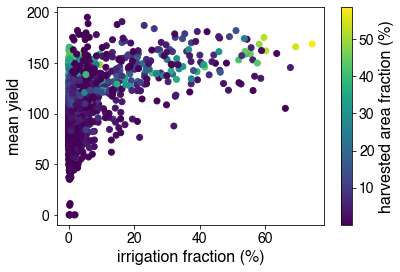

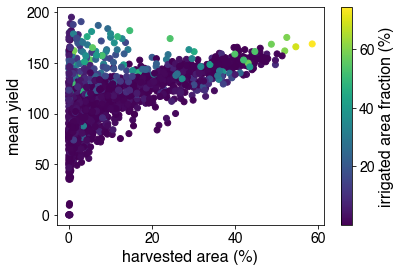

In [130]:
pa = np.array([a for a in usCounties['maizeHarvestedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
yt = np.array([a for a in usCounties['maizeYield']])
pa = np.nanmean(pa,axis=1)*100
yt = np.nanmean(yt,axis=1)
plt.figure()
plt.scatter(ir,yt,c=pa)
plt.xlabel('irrigation fraction (%)')
plt.ylabel('mean yield')
cbar = plt.colorbar()
cbar.set_label('harvested area fraction (%)')

plt.figure()
plt.scatter(pa,yt,c=ir)
plt.xlabel('harvested area (%)')
plt.ylabel('mean yield')
cbar = plt.colorbar()
cbar.set_label('irrigated area fraction (%)')

In [131]:
yt = []
kt = []
pr = []
sh = []
lh = []
prod = []

for state in usStateAbbrev.values():
    n =  list(usCounties['STATE']).count(state)
    if n >= 2: 
        p = np.array([np.array(x) for x in np.array(usCounties[usCounties['STATE']==state]['maizeProd'])])
        prod.append(p)
        yt.append(usCounties[usCounties['STATE']==state]['maizeYieldTrendDeepak'].mean().mean())
        kt.append(usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean())
        pr.append(usCounties[usCounties['STATE']==state]['seasonalPrecipTrend'].mean().mean())
        sh.append(usCounties[usCounties['STATE']==state]['seasonalSshfTrend'].mean().mean())
        lh.append(usCounties[usCounties['STATE']==state]['seasonalSlhfTrend'].mean().mean())
        usCounties[usCounties['STATE']==state]['maizeProd']


yield trend vs. kdd trend: coef = -1.57, p = 0.00, r2 = 0.10


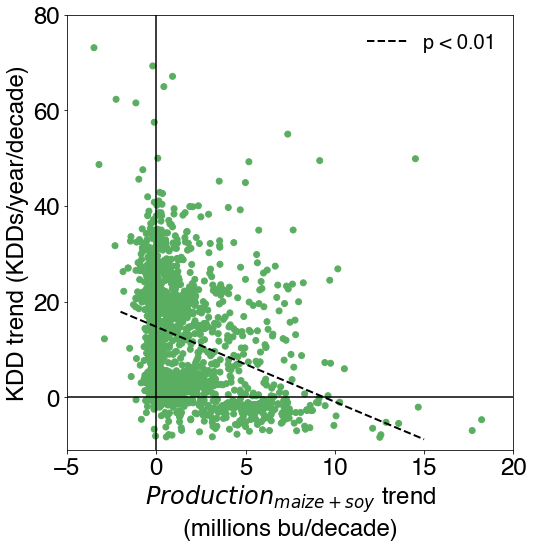

In [132]:

countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])

countyMaizeYield = np.array(list(usCounties['maizeYield']))
countySoybeanYield = np.array(list(usCounties['soybeanYield']))

countyTotalProd = np.full(countySoybeanYield.shape, np.nan)
countyProdTrend = np.full([countySoybeanYield.shape[0]], np.nan)
for c in range(countyTotalProd.shape[0]):
    p_maize = np.array([x[0]*x[1] for x in zip(countyMaizeYield[c,:], countyMaizeHaAc[c,:])])
    p_soybean = np.array([x[0]*x[1] for x in zip(countySoybeanYield[c,:], countySoybeanHaAc[c,:])])
    countyTotalProd[c,:] = p_maize + p_soybean
    
    nn = np.where(~np.isnan(countyTotalProd[c,:]))[0]
    if len(nn) >= 10:
        X = sm.add_constant(range(len(countyTotalProd[c,nn])))
        mdl1 = sm.OLS(countyTotalProd[c,nn], X).fit()
        countyProdTrend[c] = mdl1.params[1]/1e6*10

kddTrendAgg = np.array([x*10 for x in usCounties['kddTrend']])
nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(countyProdTrend)))[0]
kddTrendAgg = kddTrendAgg[nn]
countyProdTrend = countyProdTrend[nn]
    
f, (ax1) = plt.subplots(figsize=(8,8), nrows=1, ncols=1, squeeze=True)

X = sm.add_constant(countyProdTrend)
mdl1 = sm.OLS(kddTrendAgg, X).fit()

x1 = -2
x2 = 15

cmap = plt.cm.get_cmap('PRGn')

ax1.set_xlim([-5, 20])
ax1.set_ylim([-11, 80])
ax1.scatter(countyProdTrend, kddTrendAgg, c = [cmap(.8)]*len(kddTrendAgg))
ax1.plot([x1, x2], mdl1.params[0]+[x1*mdl1.params[1], x2*mdl1.params[1]], '--k', lw=2, label = 'p < 0.01')
ax1.plot([-5, 20], [0, 0], '-k')
ax1.plot([0, 0], [-11, 80], '-k')
ax1.set_xlabel('$Production_{maize+soy}$ trend\n(millions bu/decade)', fontsize=24)
ax1.set_ylabel('KDD trend (KDDs/year/decade)', fontsize=24)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
l1 = ax1.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('us-kdd-trends-prod-trends.eps', format='eps', dpi=100, bbox_inches = 'tight', pad_inches = 0)

print('yield trend vs. kdd trend: coef = %.2f, p = %.2f, r2 = %.2f'%(mdl1.params[1], mdl1.pvalues[1], mdl1.rsquared))


In [133]:
curCountyList = usCounties.copy()

ha = np.array([a for a in usCounties['maizeHarvestedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
ha = np.nanmean(ha,axis=1)*100

kddAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['kddDetrendNorm']))])))
gddAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['gddDetrendNorm']))])))
prAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalPrecipDetrendNorm']))])))
sshfAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSshfDetrendNorm']))])))
slhfAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSlhfDetrendNorm']))])))

ssrAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSsrDetrendNorm']))])))
strAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalStrDetrendNorm']))])))

u10AnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalU10DetrendNorm']))])))
v10AnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalV10DetrendNorm']))])))

maizeYieldAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['maizeYieldDetrendNorm']))])))
soybeanYieldAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['soybeanYieldDetrendNorm']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(ha))])))

nn = np.where((~np.isnan(kddAnomNormAgg)) & (~np.isnan(prAnomNormAgg)) & \
              (~np.isnan(maizeYieldAnomNormAgg) | ~np.isnan(soybeanYieldAnomNormAgg)) & (~np.isnan(sshfAnomNormAgg)) & (~np.isnan(slhfAnomNormAgg)))[0]

kddAnomNormAgg = kddAnomNormAgg[nn]
gddAnomNormAgg = gddAnomNormAgg[nn]
sshfAnomNormAgg = sshfAnomNormAgg[nn]
slhfAnomNormAgg = slhfAnomNormAgg[nn]
ssrAnomNormAgg = ssrAnomNormAgg[nn]
strAnomNormAgg = strAnomNormAgg[nn]

u10AnomNormAgg = u10AnomNormAgg[nn]
v10AnomNormAgg = v10AnomNormAgg[nn]

prAnomNormAgg = prAnomNormAgg[nn]
maizeYieldAnomNormAgg = maizeYieldAnomNormAgg[nn]
soybeanYieldAnomNormAgg = soybeanYieldAnomNormAgg[nn]

data = {'KDD':kddAnomNormAgg, \
        'GDD':gddAnomNormAgg, \
        'SSHF':-sshfAnomNormAgg, \
        'SLHF':-slhfAnomNormAgg, \
        'SSR':ssrAnomNormAgg, \
        'STR':strAnomNormAgg, \
        'NetRad':(ssrAnomNormAgg+strAnomNormAgg), \
        'U10':-u10AnomNormAgg, \
        'V10':-v10AnomNormAgg, \
        'Pr':prAnomNormAgg, \
        'MaizeYield':maizeYieldAnomNormAgg, \
        'SoybeanYield':soybeanYieldAnomNormAgg}

df = pd.DataFrame(data, \
                  columns=['KDD', 'GDD', 'SLHF', 'SSHF', 'SSR', 'STR', 'NetRad', 'Pr', 'U10', 'V10', \
                           'MaizeYield', 'SoybeanYield'])

mdl1 = smf.ols(formula='SLHF ~ MaizeYield + SoybeanYield + Pr + NetRad + U10 + V10', data=df).fit()


In [134]:
mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SLHF   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                 1.215e+04
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:09:41   Log-Likelihood:                 43490.
No. Observations:               49144   AIC:                        -8.697e+04
Df Residuals:                   49137   BIC:                        -8.690e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0001      0.000      0.224      0.823      -0.001       0.001
MaizeYield       0.1463      0.003     47.355      0.000       0.140       0.152
SoybeanYield     0.1351      0.003     44.570      0.000       0.129       0.141
Pr               0.5631      0.003    190.087      0.000       0.557       0.569
NetRad           0.6824      0.007    100.784      0.000       0.669       0.696
U10             -0.1053      0.003    -36.630      0.000      -0.111      -0.100
V10             -0.0140      0.003     -4.767      0.000      -0.020      -0.008
==============================================================================
Omnibus:                     2531.444   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8580.811
Skew:                          -0.171   Prob(JB):                         0.00
Kurtosis:                       5.018   Cond. No.                         15.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [135]:
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['kddDetrend']))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['seasonalPrecipDetrend']))])))
maizeYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['maizeYieldDetrend']))])))
soybeanYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties['soybeanYieldDetrend']))])))

nn = np.where((~np.isnan(gddAnomAgg)) & (~np.isnan(kddAnomAgg)) & (~np.isnan(prAnomAgg)) & (~np.isnan(maizeYieldAnomAgg)) & (~np.isnan(soybeanYieldAnomAgg)))[0]

data = {'GDD':gddAnomAgg[nn], \
        'KDD':kddAnomAgg[nn], \
        'Pr':prAnomAgg[nn], \
        'MaizeYield':maizeYieldAnomAgg[nn], \
        'SoybeanYield':soybeanYieldAnomAgg[nn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', \
                           'MaizeYield', 'SoybeanYield'])
yieldMdl = smf.ols(formula='MaizeYield ~ GDD + KDD + Pr', data=df).fit()
yieldMdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             MaizeYield   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     6052.
Date:                Wed, 28 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:09:41   Log-Likelihood:            -2.1097e+05
No. Observations:               49144   AIC:                         4.220e+05
Df Residuals:                   49140   BIC:                         4.220e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1251      0.080     -1.564      0.118      -0.282       0.032
GDD            0.0269      0.001     28.620      0.000       0.025       0.029
KDD           -0.1903      0.002   -106.713      0.000      -0.194      -0.187
Pr            -0.3869      0.025    -15.681      0.000      -0.435      -0.339
==============================================================================
Omnibus:                     3361.099   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4961.665
Skew:                          -0.574   Prob(JB):                         0.00
Kurtosis:                       4.052   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))])
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))])

countyMaizeYieldDetrend = np.array(list(usCounties['maizeYieldDetrendPlusMean']))
countyMaizeYield = np.array(list(usCounties['maizeYield']))
countyMaizeYieldDetrendAnom = np.array(list(usCounties['maizeYieldDetrend']))

countySoybeanYieldDetrend = np.array(list(usCounties['soybeanYieldDetrendPlusMean']))
countySoybeanYield = np.array(list(usCounties['soybeanYield']))
countySoybeanYieldDetrendAnom = np.array(list(usCounties['soybeanYieldDetrend']))

countyTotalProd = np.array([y*a for y,a in zip(countyMaizeYield, countyMaizeHaAc)] + [y*a for y,a in zip(countySoybeanYield, countySoybeanHaAc)])

In [138]:
# CURRENT VERSION - 2020-09-02

from sklearn.preprocessing import normalize

curCountyList = usCounties.copy()

useDeepak = False

adjustForHarvestedArea = False

areaLimit = [30]
irrLimit = 10


def normWithNan(x):
    x1d = np.reshape(x, [x.size])
    nn = np.where(~np.isnan(x1d))[0]
    x1d = x1d[nn]
    x_norm = x.copy()/np.linalg.norm(x1d)
    return x_norm


haMeanAggAll = np.nanmean(np.array([a for a in usCounties['maizeHarvestedAreaFraction']]), axis=1)*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeAllAc = np.array([a for a in usCounties['maizeHarvestedArea']])
haSoybeanAllAc = np.array([a for a in usCounties['soybeanHarvestedArea']])
haMaizeMeanAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanMeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeMeanAllAc + haSoybeanMeanAllAc
haTotalFracAll = haTotalAllAc/countyAcAll

countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))

if useDeepak:
    countyYieldDetrend = np.array(list(curCountyList['maizeYieldDetrendPlusMeanDeepak'])) 
    countyYield = np.array(list(curCountyList['maizeYieldDeepak']))
    countyYieldDetrendAnom = np.array(list(curCountyList['maizeYieldDetrendDeepak']))
else:
    countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countyMaizeHaFrac = np.array([a for a in np.array(list(usCounties['maizeHarvestedAreaFraction']))])*100
    countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    countySoybeanHaFrac = np.array([a for a in np.array(list(usCounties['soybeanHarvestedAreaFraction']))])*100

    countyMaizeYield = np.array(list(curCountyList['maizeYield']))
    countyMaizeYieldDetrendAnom = np.array(list(curCountyList['maizeYieldDetrend']))

    countySoybeanYield = np.array(list(curCountyList['soybeanYield']))
    countySoybeanYieldDetrendAnom = np.array(list(curCountyList['soybeanYieldDetrend']))

    countyTotalProd = np.full(countySoybeanYield.shape, np.nan)
    for c in range(countyTotalProd.shape[0]):
        p_maize = np.array([x[0]*x[1] for x in zip(countyMaizeYield[c,:], countyMaizeHaAc[c,:])])
        p_soybean = np.array([x[0]*x[1] for x in zip(countySoybeanYield[c,:], countySoybeanHaAc[c,:])])
        countyTotalProd[c,:] = p_maize + p_soybean


countyIr = np.array(list(usCounties['maizeCountyIrrigationFraction']))
countyState = np.array(list(usCounties['STATE']))
countyFips = np.array(list(usCounties['FIPS']))

countyPr = np.array(list(curCountyList['seasonalPrecip']))  # mm
countyT = np.array(list(curCountyList['seasonalT']))  # growing season mean monthly temperature
countyKdd = np.array(list(curCountyList['kdd']))
countyGdd = np.array(list(curCountyList['gdd']))

# now these are in w/m2
countySlhf = -np.array(list(curCountyList['seasonalSlhf']))
countySshf = -np.array(list(curCountyList['seasonalSshf']))
countySsr = np.array(list(curCountyList['seasonalSsr']))
countyStr = np.array(list(curCountyList['seasonalStr']))

if wxData == 'era5':
    # convert from J/growing season/m2 to W/m2
    countySlhf /= np.matlib.repmat(countySeasonLenSec, 39, 1).T
    countySshf /= np.matlib.repmat(countySeasonLenSec, 39, 1).T
    countySsr /= np.matlib.repmat(countySeasonLenSec, 39, 1).T
    countyStr /= np.matlib.repmat(countySeasonLenSec, 39, 1).T

countyNetRad = (countySsr+countyStr)
countyU10 = np.array(list(curCountyList['seasonalU10']))
countyV10 = np.array(list(curCountyList['seasonalV10']))

countyT_Norm = normWithNan(countyT)
countyPr_Norm = normWithNan(countyPr)
countyKdd_Norm = normWithNan(countyKdd)
countyGdd_Norm = normWithNan(countyGdd)
countySlhf_Norm = normWithNan(countySlhf)
countySshf_Norm = normWithNan(countySshf)
countyNetRad_Norm = normWithNan(countyNetRad)
countyU10_Norm = normWithNan(countyU10)
countyV10_Norm = normWithNan(countyV10)
countyMaizeYield_Norm = normWithNan(countyMaizeYield)
countySoybeanYield_Norm = normWithNan(countySoybeanYield)
countyTotalProd_Norm = normWithNan(countyTotalProd)

NCounties = countyKdd.shape[0]
NYears = countyKdd.shape[1]

maizeYieldFromFeedback_SensTest = np.full([NCounties, len(areaLimit)], np.nan)
soybeanYieldFromFeedback_SensTest = np.full([NCounties, len(areaLimit)], np.nan)

for a, curAreaLimit in enumerate(areaLimit):
    
    if len(areaLimit) > 1:
        print('area limit %d%%'%curAreaLimit)

    lhTrendFrac = np.full([NCounties], np.nan)
    shTrendFrac = np.full([NCounties], np.nan)
    lhFromFeedback = np.full([NCounties], np.nan)
    shFromFeedback = np.full([NCounties], np.nan)
    tFromFeedback = np.full([NCounties], np.nan)
    kddTrendFrac = np.full([NCounties], np.nan)
    kddFromFeedback = np.full([NCounties], np.nan)
    gddTrendFrac = np.full([NCounties], np.nan)
    gddFromFeedback = np.full([NCounties], np.nan)
    maizeYieldTrendFrac = np.full([NCounties], np.nan)
    maizeYieldFromFeedback = np.full([NCounties], np.nan)
    soybeanYieldTrendFrac = np.full([NCounties], np.nan)
    soybeanYieldFromFeedback = np.full([NCounties], np.nan)
    prodFromFeedback = np.full([NCounties], np.nan)

    maizeYieldChgFeedbackWithAgInt = np.full([NCounties], np.nan)
    maizeYieldChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

    soybeanYieldChgFeedbackWithAgInt = np.full([NCounties], np.nan)
    soybeanYieldChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

    lhChgFeedbackWithAgInt = np.full([NCounties], np.nan)
    lhChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

    shChgFeedbackWithAgInt = np.full([NCounties], np.nan)
    shChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

    kddChgFeedbackWithAgInt = np.full([NCounties], np.nan)
    kddChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

    gddChgFeedbackWithAgInt = np.full([NCounties], np.nan)
    gddChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

    lhObsTrend = np.full([NCounties], np.nan)
    shObsTrend = np.full([NCounties], np.nan)
    netRadObsTrend = np.full([NCounties], np.nan)

    lhMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
    lhMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
    lhModTrend_yieldGrowth = np.full([NCounties], np.nan)
    lhModTrend_noYieldGrowth = np.full([NCounties], np.nan)

    shMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
    shMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
    shModTrend_yieldGrowth = np.full([NCounties], np.nan)
    shModTrend_noYieldGrowth = np.full([NCounties], np.nan)

    tMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
    tMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
    tModTrend_yieldGrowth = np.full([NCounties], np.nan)
    tModTrend_noYieldGrowth = np.full([NCounties], np.nan)
    
    gddMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
    gddMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
    gddModTrend_yieldGrowth = np.full([NCounties], np.nan)
    gddModTrend_noYieldGrowth = np.full([NCounties], np.nan)

    kddMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
    kddMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
    kddModTrend_yieldGrowth = np.full([NCounties], np.nan)
    kddModTrend_noYieldGrowth = np.full([NCounties], np.nan)

    maizeYieldMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
    maizeYieldMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
    maizeYieldModTrend_yieldGrowth = np.full([NCounties], np.nan)
    maizeYieldModTrend_noYieldGrowth = np.full([NCounties], np.nan)

    soybeanYieldMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
    soybeanYieldMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
    soybeanYieldModTrend_yieldGrowth = np.full([NCounties], np.nan)
    soybeanYieldModTrend_noYieldGrowth = np.full([NCounties], np.nan)

    mdl_Param_Corr = {'Prod-Pr':np.full([NCounties], np.nan), 
                        'Prod-NetRad':np.full([NCounties], np.nan), 
                      'Prod-Wind':np.full([NCounties], np.nan), 
                      'Pr-NetRad':np.full([NCounties], np.nan), 
                      'Pr-Wind':np.full([NCounties], np.nan), 
                      'NetRad-Wind':np.full([NCounties], np.nan)}

    mdl_LH_Y_Coefs = {'MaizeYield_DetrendAnom':np.full([NCounties], np.nan), 
                      'SoybeanYield_DetrendAnom':np.full([NCounties], np.nan), 
                      'TotalProd_DetrendAnom':np.full([NCounties], np.nan), 
                           'Pr_DetrendAnom':np.full([NCounties], np.nan),
                           'NetRad_DetrendAnom':np.full([NCounties], np.nan),
                           'Wind_DetrendAnom':np.full([NCounties], np.nan), 
                         'R2':np.full([NCounties], np.nan)}
    mdl_LH_Y_PValues = {'MaizeYield_DetrendAnom':np.full([NCounties], np.nan), 
                        'SoybeanYield_DetrendAnom':np.full([NCounties], np.nan), 
                        'TotalProd_DetrendAnom':np.full([NCounties], np.nan), 
                           'Pr_DetrendAnom':np.full([NCounties], np.nan),
                           'NetRad_DetrendAnom':np.full([NCounties], np.nan),
                           'Wind_DetrendAnom':np.full([NCounties], np.nan)}

    mdl_LH_Y_Norm_Coefs = {'MaizeYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'SoybeanYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'TotalProd_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'Pr_DetrendAnom_Norm':np.full([NCounties], np.nan),
                           'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan),
                           'Wind_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_LH_Y_Norm_PValues = {'MaizeYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                             'SoybeanYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                             'TotalProd_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'Pr_DetrendAnom_Norm':np.full([NCounties], np.nan),
                           'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan),
                           'Wind_DetrendAnom_Norm':np.full([NCounties], np.nan)}

    mdl_LH_Y_Decomp_Coefs = {'TotalYield_DetrendAnom':np.full([NCounties], np.nan), 
                              'TotalHA':np.full([NCounties], np.nan)}
    mdl_LH_Y_Decomp_PValues = {'TotalYield_DetrendAnom':np.full([NCounties], np.nan), 
                              'TotalHA':np.full([NCounties], np.nan)}

    mdl_LH_SH_Coefs = {'SLHF_DetrendAnom':np.full([NCounties], np.nan), 
                           'NetRad_DetrendAnom':np.full([NCounties], np.nan),
                          'R2':np.full([NCounties], np.nan)}
    mdl_LH_SH_PValues = {'SLHF_DetrendAnom':np.full([NCounties], np.nan), 
                           'NetRad_DetrendAnom':np.full([NCounties], np.nan)}

    mdl_LH_SH_Norm_Coefs = {'SLHF_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_LH_SH_Norm_PValues = {'SLHF_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                           'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan)}

    mdl_SH_KDD_Coefs = {'SSHF_DetrendAnom':np.full([NCounties], np.nan),
                       'R2':np.full([NCounties], np.nan)}
    mdl_SH_KDD_PValues = {'SSHF_DetrendAnom':np.full([NCounties], np.nan)}
    mdl_SH_GDD_Coefs = {'SSHF_DetrendAnom':np.full([NCounties], np.nan), 
                       'R2':np.full([NCounties], np.nan)}
    mdl_SH_GDD_PValues = {'SSHF_DetrendAnom':np.full([NCounties], np.nan)}

    mdl_SH_KDD_Norm_Coefs = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_SH_KDD_Norm_PValues = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_SH_GDD_Norm_Coefs = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}
    mdl_SH_GDD_Norm_PValues = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}

    mdl_KDD_GDD_MaizeYield_Coefs = {'KDD_Detrend':np.full([NCounties], np.nan),
                                    'GDD_Detrend':np.full([NCounties], np.nan), 
                                    'Pr_Detrend':np.full([NCounties], np.nan),
                                    'R2':np.full([NCounties], np.nan)}
    mdl_KDD_GDD_MaizeYield_PValues = {'KDD_Detrend':np.full([NCounties], np.nan),
                                      'GDD_Detrend':np.full([NCounties], np.nan), 
                                      'Pr_Detrend':np.full([NCounties], np.nan)}

    mdl_KDD_GDD_MaizeYield_Norm_Coefs = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                    'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                    'Pr_DetrendNorm':np.full([NCounties], np.nan),
                                    'R2':np.full([NCounties], np.nan)}
    mdl_KDD_GDD_MaizeYield_Norm_PValues = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                      'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                      'Pr_DetrendNorm':np.full([NCounties], np.nan)}

    mdl_KDD_GDD_SoybeanYield_Coefs = {'KDD_Detrend':np.full([NCounties], np.nan),
                                    'GDD_Detrend':np.full([NCounties], np.nan), 
                                    'Pr_Detrend':np.full([NCounties], np.nan),
                                    'R2':np.full([NCounties], np.nan)}
    mdl_KDD_GDD_SoybeanYield_PValues = {'KDD_Detrend':np.full([NCounties], np.nan),
                                      'GDD_Detrend':np.full([NCounties], np.nan), 
                                      'Pr_Detrend':np.full([NCounties], np.nan)}

    mdl_KDD_GDD_SoybeanYield_Norm_Coefs = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                    'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                    'Pr_DetrendNorm':np.full([NCounties], np.nan),
                                    'R2':np.full([NCounties], np.nan)}
    mdl_KDD_GDD_SoybeanYield_Norm_PValues = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                      'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                      'Pr_DetrendNorm':np.full([NCounties], np.nan)}
    
    fipsSel = []
    fipsAll = []
    irSel = []
    haExclude = []
    shortSeriesExclude = []
    nonSigExclude = []
    stateSel = []

    for i in range(NCounties):

        fipsAll.append(countyFips[i])

        if i % 200 == 0:
            print('%d of %d'%(i, NCounties))

        curMaizeYieldDetrendAnom = countyMaizeYieldDetrendAnom[i,:]
        curMaizeYield = countyMaizeYield[i,:]
        curMaizeYield_Norm = countyMaizeYield_Norm[i,:]

        curSoybeanYieldDetrendAnom = countySoybeanYieldDetrendAnom[i,:]
        curSoybeanYield = countySoybeanYield[i,:]
        curSoybeanYield_Norm = countySoybeanYield_Norm[i,:]

        curTotalProd = countyTotalProd[i,:]
        curTotalProd_Norm = countyTotalProd_Norm[i,:]

        curTotalHaFrac = (haMaizeAllAc[i,:] + haSoybeanAllAc[i,:])/countyAcAll[i]

        curKdd = countyKdd[i,:]
        curKdd_Norm = countyKdd_Norm[i,:]
        curGdd = countyGdd[i,:]
        curGdd_Norm = countyGdd_Norm[i,:]
        curT = countyT[i,:]
        curT_Norm = countyT_Norm[i,:]
        curSshf = countySshf[i,:]
        curSshf_Norm = countySshf_Norm[i,:]
        curSlhf = countySlhf[i,:]
        curSlhf_Norm = countySlhf_Norm[i,:]
        curNetRad = countyNetRad[i,:]
        curNetRad_Norm = countyNetRad_Norm[i,:]
        curU10 = countyU10[i,:]
        curU10_Norm = countyU10_Norm[i,:]
        curV10 = countyV10[i,:]
        curV10_Norm = countyV10_Norm[i,:]
        curPr = countyPr[i,:]
        curPr_Norm = countyPr_Norm[i,:]

        nnProd = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                          (~np.isnan(curTotalProd)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
        nnMaize = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                          (~np.isnan(curMaizeYield)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
        nnSoybean = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                          (~np.isnan(curSoybeanYield)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]

        stateSel.append(countyState[i])

        exclude = False
        # identify counties excluded bc they have a short production time series
        if np.nansum(curTotalProd) == 0 or len(nnProd) < 10:
            shortSeriesExclude.append(countyFips[i])
            fipsSel.append(np.nan)
            exclude = True

        # identify counties excluded bc they have too little harvested area
        if np.nanmean(countyMaizeHaFrac[i,:]+countySoybeanHaFrac[i,:]) < curAreaLimit:
            haExclude.append(countyFips[i])
            if not exclude: fipsSel.append(np.nan)
            exclude = True

        # identify counties that are irrigated
        if countyIr[i] > (irrLimit/100)*np.nanmean(countyMaizeHaFrac[i,:]+countySoybeanHaFrac[i,:]):
            irSel.append(i)
        else:
            irSel.append(np.nan)

        if exclude:
            continue

        if len(nnMaize) >= 10:
            X = sm.add_constant(range(len(curMaizeYield[nnMaize])))
            mdl = sm.OLS(curMaizeYield[nnMaize], X).fit()
            curMaizeYieldIntercept = mdl.params[0]

            X = sm.add_constant(range(len(curMaizeYield_Norm[nnMaize])))
            mdl = sm.OLS(curMaizeYield_Norm[nnMaize], X).fit()
            curMaizeYieldIntercept_Norm = mdl.params[0]

        if len(nnSoybean) >= 10:
            X = sm.add_constant(range(len(curSoybeanYield[nnSoybean])))
            mdl = sm.OLS(curSoybeanYield[nnSoybean], X).fit()
            curSoybeanYieldIntercept = mdl.params[0]

            X = sm.add_constant(range(len(curSoybeanYield_Norm[nnSoybean])))
            mdl = sm.OLS(curSoybeanYield_Norm[nnSoybean], X).fit()
            curSoybeanYieldIntercept_Norm = mdl.params[0]

        X = sm.add_constant(range(len(curTotalProd[nnProd])))
        mdl = sm.OLS(curTotalProd[nnProd], X).fit()
        curTotalProdIntercept = mdl.params[0]

        X = sm.add_constant(range(len(curTotalProd_Norm[nnProd])))
        mdl = sm.OLS(curTotalProd_Norm[nnProd], X).fit()
        curTotalProdIntercept_Norm = mdl.params[0]

        X = sm.add_constant(range(len(curPr)))
        mdl = sm.OLS(curPr, X).fit()
        curPrIntercept = mdl.params[0]

        X = sm.add_constant(range(len((curNetRad))))
        mdl = sm.OLS((curNetRad), X).fit()
        curNetRadIntercept = mdl.params[0]

        X = sm.add_constant(range(len(curU10)))
        mdl = sm.OLS(curU10, X).fit()
        curU10Intercept = mdl.params[0]

        X = sm.add_constant(range(len(curV10)))
        mdl = sm.OLS(curV10, X).fit()
        curV10Intercept = mdl.params[0]

        curWindProd = (curU10[nnProd]**2 + curV10[nnProd]**2)**.5
        curWindProd_Norm = (curU10_Norm[nnProd]**2 + curV10_Norm[nnProd]**2)**.5
        curWindMaize = (curU10[nnMaize]**2 + curV10[nnMaize]**2)**.5
        curWindMaize_Norm = (curU10_Norm[nnMaize]**2 + curV10_Norm[nnMaize]**2)**.5
        curWindSoybean = (curU10[nnSoybean]**2 + curV10[nnSoybean]**2)**.5
        curWindSoybean_Norm = (curU10_Norm[nnSoybean]**2 + curV10_Norm[nnSoybean]**2)**.5

        dataProd = {'KDD_DetrendAnom_Norm':scipy.signal.detrend(curKdd_Norm[nnProd]), \
                'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnProd]), \
                'KDD_DetrendNorm':scipy.signal.detrend(curKdd_Norm[nnProd])+np.nanmean(curKdd_Norm[nnProd]), \
                'KDD_Detrend':scipy.signal.detrend(curKdd[nnProd])+np.nanmean(curKdd[nnProd]), \
                'KDD':curKdd[nnProd], \
                'GDD_DetrendAnom_Norm':scipy.signal.detrend(curGdd_Norm[nnProd]), \
                'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnProd]), \
                'GDD_DetrendNorm':scipy.signal.detrend(curGdd_Norm[nnProd])+np.nanmean(curGdd_Norm[nnProd]), \
                'GDD_Detrend':scipy.signal.detrend(curGdd[nnProd])+np.nanmean(curGdd[nnProd]), \
                'GDD':curGdd[nnProd], \
                'T':curT[nnProd], \
                'T_DetrendAnom_Norm':scipy.signal.detrend(curT_Norm[nnProd]), \
                'T_DetrendAnom':scipy.signal.detrend(curT[nnProd]), \
                'SSHF':curSshf[nnProd], \
                'SSHF_DetrendAnom_Norm':scipy.signal.detrend(curSshf_Norm[nnProd]), \
                'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnProd]), \
                'SLHF_DetrendAnom_Norm':scipy.signal.detrend(curSlhf_Norm[nnProd]), \
                'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnProd]), \
                'SLHF':curSlhf[nnProd], \
                'Wind_DetrendAnom_Norm':scipy.signal.detrend(curWindProd_Norm), \
                'Wind_DetrendAnom':scipy.signal.detrend(curWindProd), \
                'Wind':curWindProd, \
                'Pr_DetrendAnom_Norm':scipy.signal.detrend(curPr_Norm[nnProd]), \
                'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnProd]), \
                'Pr_Detrend':(scipy.signal.detrend(curPr[nnProd])+np.nanmean(curPr[nnProd])), \
                'Pr_DetrendNorm':scipy.signal.detrend(curPr_Norm[nnProd])+np.nanmean(curPr_Norm[nnProd]), \
                'Pr':curPr[nnProd], \
                'NetRad_DetrendAnom_Norm':scipy.signal.detrend(curNetRad_Norm[nnProd]), \
                'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnProd]), \
                'NetRad':curNetRad[nnProd], \
                'TotalYield_DetrendAnom':scipy.signal.detrend(curMaizeYield[nnProd]+curSoybeanYield[nnProd]), \
                'TotalHA':scipy.signal.detrend(curTotalHaFrac[nnProd]), \
                'TotalProd_DetrendAnom':scipy.signal.detrend(curTotalProd[nnProd]), \
                'TotalProd_DetrendAnom_Norm':scipy.signal.detrend(curTotalProd_Norm[nnProd]), \
                'TotalProd':curTotalProd[nnProd], \
                'TotalProd_Detrend':scipy.signal.detrend(curTotalProd[nnProd])+curTotalProdIntercept, \
                'TotalProd_DetrendNorm':scipy.signal.detrend(curTotalProd_Norm[nnProd])+curTotalProdIntercept_Norm}

        dfProd = pd.DataFrame(dataProd, \
                          columns=['KDD_DetrendAnom_Norm', 'KDD_DetrendAnom', 'KDD', 'KDD_Detrend', 'KDD_DetrendNorm', \
                                   'GDD_DetrendAnom_Norm', 'GDD_DetrendAnom', 'GDD', 'GDD_Detrend', 'GDD_DetrendNorm', \
                                   'T_DetrendAnom_Norm', 'T_DetrendAnom', 'T', \
                                   'SLHF_DetrendAnom_Norm', 'SLHF_DetrendAnom', 'SLHF', \
                                   'SSHF_DetrendAnom_Norm', 'SSHF_DetrendAnom', 'SSHF', \
                                   'NetRad_DetrendAnom_Norm', 'NetRad_DetrendAnom', 'NetRad', \
                                   'Pr_DetrendAnom_Norm', 'Pr_DetrendAnom', 'Pr', 'Pr_Detrend', 'Pr_DetrendNorm', \
                                   'Wind_DetrendAnom_Norm', 'Wind_DetrendAnom', 'Wind', \
                                   'TotalYield_DetrendAnom', 'TotalHA', \
                                   'TotalProd', 'TotalProd_Detrend', 'TotalProd_DetrendNorm', 'TotalProd_DetrendAnom', 'TotalProd_DetrendAnom_Norm'])

        if len(nnMaize) >= 10:
            dataMaize = {'KDD_DetrendAnom_Norm':scipy.signal.detrend(curKdd_Norm[nnMaize]), \
                    'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnMaize]), \
                    'KDD_DetrendNorm':scipy.signal.detrend(curKdd_Norm[nnMaize])+np.nanmean(curKdd_Norm[nnMaize]), \
                    'KDD_Detrend':scipy.signal.detrend(curKdd[nnMaize])+np.nanmean(curKdd[nnMaize]), \
                    'KDD':curKdd[nnMaize], \
                    'GDD_DetrendAnom_Norm':scipy.signal.detrend(curGdd_Norm[nnMaize]), \
                    'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnMaize]), \
                    'GDD_DetrendNorm':scipy.signal.detrend(curGdd_Norm[nnMaize])+np.nanmean(curGdd_Norm[nnMaize]), \
                    'GDD_Detrend':scipy.signal.detrend(curGdd[nnMaize])+np.nanmean(curGdd[nnMaize]), \
                    'GDD':curGdd[nnMaize], \
                    'SSHF':curSshf[nnMaize], \
                    'SSHF_DetrendAnom_Norm':scipy.signal.detrend(curSshf_Norm[nnMaize]), \
                    'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnMaize]), \
                    'SLHF_DetrendAnom_Norm':scipy.signal.detrend(curSlhf_Norm[nnMaize]), \
                    'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnMaize]), \
                    'SLHF':curSlhf[nnMaize], \
                    'Wind_DetrendAnom_Norm':scipy.signal.detrend(curWindMaize_Norm), \
                    'Wind_DetrendAnom':scipy.signal.detrend(curWindMaize), \
                    'Wind':curWindMaize, \
                    'Pr_DetrendAnom_Norm':scipy.signal.detrend(curPr_Norm[nnMaize]), \
                    'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnMaize]), \
                    'Pr_Detrend':(scipy.signal.detrend(curPr[nnMaize])+np.nanmean(curPr[nnMaize])), \
                    'Pr_DetrendNorm':scipy.signal.detrend(curPr_Norm[nnMaize])+np.nanmean(curPr_Norm[nnMaize]), \
                    'Pr':curPr[nnMaize], \
                    'NetRad_DetrendAnom_Norm':scipy.signal.detrend(curNetRad_Norm[nnMaize]), \
                    'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnMaize]), \
                    'NetRad':curNetRad[nnMaize], \
                    'MaizeYield_DetrendAnom':scipy.signal.detrend(curMaizeYield[nnMaize]), \
                    'MaizeYield_DetrendAnom_Norm':scipy.signal.detrend(curMaizeYield_Norm[nnMaize]), \
                    'MaizeYield':curMaizeYield[nnMaize], \
                    'MaizeYield_Detrend':scipy.signal.detrend(curMaizeYield[nnMaize])+curMaizeYieldIntercept, \
                    'MaizeYield_DetrendNorm':scipy.signal.detrend(curMaizeYield_Norm[nnMaize])+curMaizeYieldIntercept_Norm}

            dfMaize = pd.DataFrame(dataMaize, \
                          columns=['KDD_DetrendAnom_Norm', 'KDD_DetrendAnom', 'KDD', 'KDD_Detrend', 'KDD_DetrendNorm', \
                                   'GDD_DetrendAnom_Norm', 'GDD_DetrendAnom', 'GDD', 'GDD_Detrend', 'GDD_DetrendNorm', \
                                   'SLHF_DetrendAnom_Norm', 'SLHF_DetrendAnom', 'SLHF', \
                                   'SSHF_DetrendAnom_Norm', 'SSHF_DetrendAnom', 'SSHF', \
                                   'NetRad_DetrendAnom_Norm', 'NetRad_DetrendAnom', 'NetRad', \
                                   'Pr_DetrendAnom_Norm', 'Pr_DetrendAnom', 'Pr', 'Pr_Detrend', 'Pr_DetrendNorm', \
                                   'Wind_DetrendAnom_Norm', 'Wind_DetrendAnom', 'Wind', \
                                   'MaizeYield', 'MaizeYield_Detrend', 'MaizeYield_DetrendNorm', 'MaizeYield_DetrendAnom', 'MaizeYield_DetrendAnom_Norm'])

        if len(nnSoybean) >= 10:
            dataSoybean = {'KDD_DetrendAnom_Norm':scipy.signal.detrend(curKdd_Norm[nnSoybean]), \
                    'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnSoybean]), \
                    'KDD_DetrendNorm':scipy.signal.detrend(curKdd_Norm[nnSoybean])+np.nanmean(curKdd_Norm[nnSoybean]), \
                    'KDD_Detrend':scipy.signal.detrend(curKdd[nnSoybean])+np.nanmean(curKdd[nnSoybean]), \
                    'KDD':curKdd[nnSoybean], \
                    'GDD_DetrendAnom_Norm':scipy.signal.detrend(curGdd_Norm[nnSoybean]), \
                    'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnSoybean]), \
                    'GDD_DetrendNorm':scipy.signal.detrend(curGdd_Norm[nnSoybean])+np.nanmean(curGdd_Norm[nnSoybean]), \
                    'GDD_Detrend':scipy.signal.detrend(curGdd[nnSoybean])+np.nanmean(curGdd[nnSoybean]), \
                    'GDD':curGdd[nnSoybean], \
                    'SSHF':curSshf[nnSoybean], \
                    'SSHF_DetrendAnom_Norm':scipy.signal.detrend(curSshf_Norm[nnSoybean]), \
                    'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnSoybean]), \
                    'SLHF_DetrendAnom_Norm':scipy.signal.detrend(curSlhf_Norm[nnSoybean]), \
                    'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnSoybean]), \
                    'SLHF':curSlhf[nnSoybean], \
                    'Wind_DetrendAnom_Norm':scipy.signal.detrend(curWindSoybean_Norm), \
                    'Wind_DetrendAnom':scipy.signal.detrend(curWindSoybean), \
                    'Wind':curWindSoybean, \
                    'Pr_DetrendAnom_Norm':scipy.signal.detrend(curPr_Norm[nnSoybean]), \
                    'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnSoybean]), \
                    'Pr_Detrend':(scipy.signal.detrend(curPr[nnSoybean])+np.nanmean(curPr[nnSoybean])), \
                    'Pr_DetrendNorm':scipy.signal.detrend(curPr_Norm[nnSoybean])+np.nanmean(curPr_Norm[nnSoybean]), \
                    'Pr':curPr[nnSoybean], \
                    'NetRad_DetrendAnom_Norm':scipy.signal.detrend(curNetRad_Norm[nnSoybean]), \
                    'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnSoybean]), \
                    'NetRad':curNetRad[nnSoybean], \
                    'SoybeanYield_DetrendAnom':scipy.signal.detrend(curSoybeanYield[nnSoybean]), \
                    'SoybeanYield_DetrendAnom_Norm':scipy.signal.detrend(curSoybeanYield_Norm[nnSoybean]), \
                    'SoybeanYield':curSoybeanYield[nnSoybean], \
                    'SoybeanYield_Detrend':scipy.signal.detrend(curSoybeanYield[nnSoybean])+curSoybeanYieldIntercept, \
                    'SoybeanYield_DetrendNorm':scipy.signal.detrend(curSoybeanYield_Norm[nnSoybean])+curSoybeanYieldIntercept_Norm}

            dfSoybean = pd.DataFrame(dataSoybean, \
                          columns=['KDD_DetrendAnom_Norm', 'KDD_DetrendAnom', 'KDD', 'KDD_Detrend', 'KDD_DetrendNorm', \
                                   'GDD_DetrendAnom_Norm', 'GDD_DetrendAnom', 'GDD', 'GDD_Detrend', 'GDD_DetrendNorm', \
                                   'SLHF_DetrendAnom_Norm', 'SLHF_DetrendAnom', 'SLHF', \
                                   'SSHF_DetrendAnom_Norm', 'SSHF_DetrendAnom', 'SSHF', \
                                   'NetRad_DetrendAnom_Norm', 'NetRad_DetrendAnom', 'NetRad', \
                                   'Pr_DetrendAnom_Norm', 'Pr_DetrendAnom', 'Pr', 'Pr_Detrend', 'Pr_DetrendNorm', \
                                   'Wind_DetrendAnom_Norm', 'Wind_DetrendAnom', 'Wind', \
                                   'SoybeanYield', 'SoybeanYield_Detrend', 'SoybeanYield_DetrendNorm', 'SoybeanYield_DetrendAnom', 'SoybeanYield_DetrendAnom_Norm'])



        mdl_LH_Y = smf.ols(formula='SLHF_DetrendAnom ~ TotalProd_DetrendAnom + Pr_DetrendAnom + NetRad_DetrendAnom + Wind_DetrendAnom', \
                           data=dfProd).fit()
        mdl_LH_Y_Norm = smf.ols(formula='SLHF_DetrendAnom_Norm ~ TotalProd_DetrendAnom_Norm + Pr_DetrendAnom_Norm + NetRad_DetrendAnom_Norm + Wind_DetrendAnom_Norm', \
                                data=dfProd).fit()

        mdl_LH_Y_Decomp = smf.ols(formula='SLHF_DetrendAnom ~ TotalHA + TotalYield_DetrendAnom + Pr_DetrendAnom + NetRad_DetrendAnom + Wind_DetrendAnom', \
                           data=dfProd).fit()

        mdl_Param_Corr['Prod-Pr'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['Pr_DetrendAnom'])[0,1]
        mdl_Param_Corr['Prod-NetRad'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['NetRad_DetrendAnom'])[0,1]
        mdl_Param_Corr['Prod-Wind'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
        mdl_Param_Corr['Pr-NetRad'][i] = np.corrcoef(dfProd['Pr_DetrendAnom'], dfProd['NetRad_DetrendAnom'])[0,1]
        mdl_Param_Corr['Pr-Wind'][i] = np.corrcoef(dfProd['Pr_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
        mdl_Param_Corr['NetRad-Wind'][i] = np.corrcoef(dfProd['NetRad_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]

        mdl_LH_Y_Decomp_Coefs['TotalYield_DetrendAnom'][i] = mdl_LH_Y_Decomp.params['TotalYield_DetrendAnom']
        mdl_LH_Y_Decomp_Coefs['TotalHA'][i] = mdl_LH_Y_Decomp.params['TotalHA']
        mdl_LH_Y_Decomp_PValues['TotalYield_DetrendAnom'][i] = mdl_LH_Y_Decomp.pvalues['TotalYield_DetrendAnom']
        mdl_LH_Y_Decomp_PValues['TotalHA'][i] = mdl_LH_Y_Decomp.pvalues['TotalHA']

        mdl_LH_SH = smf.ols(formula='SSHF_DetrendAnom ~ SLHF_DetrendAnom + NetRad_DetrendAnom', data=dfProd).fit()
        mdl_LH_SH_Norm = smf.ols(formula='SSHF_DetrendAnom_Norm ~ SLHF_DetrendAnom_Norm + NetRad_DetrendAnom_Norm', data=dfProd).fit()
        mdl_SH_KDD = smf.ols(formula='KDD_DetrendAnom ~ SSHF_DetrendAnom', data=dfProd).fit()
        mdl_SH_KDD_Norm = smf.ols(formula='KDD_DetrendAnom_Norm ~ SSHF_DetrendAnom_Norm', data=dfProd).fit()
        mdl_SH_GDD = smf.ols(formula='GDD_DetrendAnom ~ SSHF_DetrendAnom', data=dfProd).fit()
        mdl_SH_GDD_Norm = smf.ols(formula='GDD_DetrendAnom_Norm ~ SSHF_DetrendAnom_Norm', data=dfProd).fit()

        mdl_SH_T = smf.ols(formula='T_DetrendAnom ~ SSHF_DetrendAnom', data=dfProd).fit()
        
        if len(nnMaize) >= 10:
            mdl_KDD_GDD_PR_MaizeYield = smf.ols(formula='MaizeYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfMaize).fit()
            mdl_KDD_GDD_PR_MaizeYield_Norm = smf.ols(formula='MaizeYield_DetrendNorm ~ GDD_DetrendNorm + KDD_DetrendNorm + Pr_DetrendNorm', data=dfMaize).fit()

        if len(nnSoybean) >= 10:
            mdl_KDD_GDD_PR_SoybeanYield = smf.ols(formula='SoybeanYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfSoybean).fit()
            mdl_KDD_GDD_PR_SoybeanYield_Norm = smf.ols(formula='SoybeanYield_DetrendNorm ~ GDD_DetrendNorm + KDD_DetrendNorm + Pr_DetrendNorm', data=dfSoybean).fit()

    #     mdl_LH_Y_Coefs['Yield_DetrendAnom'][i] = mdl_LH_Y.params['Yield_DetrendAnom']
        mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][i] = mdl_LH_Y.params['TotalProd_DetrendAnom']
        mdl_LH_Y_Coefs['Pr_DetrendAnom'][i] = mdl_LH_Y.params['Pr_DetrendAnom']
        mdl_LH_Y_Coefs['NetRad_DetrendAnom'][i] = mdl_LH_Y.params['NetRad_DetrendAnom']
        mdl_LH_Y_Coefs['Wind_DetrendAnom'][i] = mdl_LH_Y.params['Wind_DetrendAnom']
        mdl_LH_Y_Coefs['R2'][i] = mdl_LH_Y.rsquared
    #     mdl_LH_Y_PValues['Yield_DetrendAnom'][i] = mdl_LH_Y.pvalues['Yield_DetrendAnom']
        mdl_LH_Y_PValues['TotalProd_DetrendAnom'][i] = mdl_LH_Y.pvalues['TotalProd_DetrendAnom']
        mdl_LH_Y_PValues['Pr_DetrendAnom'][i] = mdl_LH_Y.pvalues['Pr_DetrendAnom']
        mdl_LH_Y_PValues['NetRad_DetrendAnom'][i] = mdl_LH_Y.pvalues['NetRad_DetrendAnom']
        mdl_LH_Y_PValues['Wind_DetrendAnom'][i] = mdl_LH_Y.pvalues['Wind_DetrendAnom']

    #     mdl_LH_Y_Norm_Coefs['Yield_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['Yield_DetrendAnom_Norm']
        mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['TotalProd_DetrendAnom_Norm']
        mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['Pr_DetrendAnom_Norm']
        mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['NetRad_DetrendAnom_Norm']
        mdl_LH_Y_Norm_Coefs['Wind_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['Wind_DetrendAnom_Norm']
    #     mdl_LH_Y_Norm_PValues['Yield_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['Yield_DetrendAnom_Norm']
        mdl_LH_Y_Norm_PValues['TotalProd_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['TotalProd_DetrendAnom_Norm']
        mdl_LH_Y_Norm_PValues['Pr_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['Pr_DetrendAnom_Norm']
        mdl_LH_Y_Norm_PValues['NetRad_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['NetRad_DetrendAnom_Norm']
        mdl_LH_Y_Norm_PValues['Wind_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['Wind_DetrendAnom_Norm']

        mdl_LH_SH_Coefs['SLHF_DetrendAnom'][i] = mdl_LH_SH.params['SLHF_DetrendAnom']
        mdl_LH_SH_Coefs['NetRad_DetrendAnom'][i] = mdl_LH_SH.params['NetRad_DetrendAnom']
        mdl_LH_SH_Coefs['R2'][i] = mdl_LH_SH.rsquared
        mdl_LH_SH_PValues['SLHF_DetrendAnom'][i] = mdl_LH_SH.pvalues['SLHF_DetrendAnom']
        mdl_LH_SH_PValues['NetRad_DetrendAnom'][i] = mdl_LH_SH.pvalues['NetRad_DetrendAnom']

        mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.params['SLHF_DetrendAnom_Norm']
        mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.params['NetRad_DetrendAnom_Norm']
        mdl_LH_SH_Norm_PValues['SLHF_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.pvalues['SLHF_DetrendAnom_Norm']
        mdl_LH_SH_Norm_PValues['NetRad_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.pvalues['NetRad_DetrendAnom_Norm']

        mdl_SH_KDD_Coefs['SSHF_DetrendAnom'][i] = mdl_SH_KDD.params['SSHF_DetrendAnom']
        mdl_SH_KDD_Coefs['R2'][i] = mdl_SH_KDD.rsquared
        mdl_SH_GDD_Coefs['SSHF_DetrendAnom'][i] = mdl_SH_GDD.params['SSHF_DetrendAnom']
        mdl_SH_GDD_Coefs['R2'][i] = mdl_SH_GDD.rsquared
        mdl_SH_KDD_PValues['SSHF_DetrendAnom'][i] = mdl_SH_KDD.pvalues['SSHF_DetrendAnom']
        mdl_SH_GDD_PValues['SSHF_DetrendAnom'][i] = mdl_SH_GDD.pvalues['SSHF_DetrendAnom']

        mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][i] = mdl_SH_KDD_Norm.params['SSHF_DetrendAnom_Norm']
        mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][i] = mdl_SH_GDD_Norm.params['SSHF_DetrendAnom_Norm']
        mdl_SH_KDD_Norm_PValues['SSHF_DetrendAnom_Norm'][i] = mdl_SH_KDD_Norm.pvalues['SSHF_DetrendAnom_Norm']
        mdl_SH_GDD_Norm_PValues['SSHF_DetrendAnom_Norm'][i] = mdl_SH_GDD_Norm.pvalues['SSHF_DetrendAnom_Norm']

        if len(nnMaize) >= 10:
            mdl_KDD_GDD_MaizeYield_Coefs['KDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.params['KDD_Detrend']
            mdl_KDD_GDD_MaizeYield_Coefs['GDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.params['GDD_Detrend']
            mdl_KDD_GDD_MaizeYield_Coefs['Pr_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.params['Pr_Detrend']
            mdl_KDD_GDD_MaizeYield_Coefs['R2'][i] = mdl_KDD_GDD_PR_MaizeYield.rsquared
            mdl_KDD_GDD_MaizeYield_PValues['KDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.pvalues['KDD_Detrend']
            mdl_KDD_GDD_MaizeYield_PValues['GDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.pvalues['GDD_Detrend']
            mdl_KDD_GDD_MaizeYield_PValues['Pr_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.pvalues['Pr_Detrend']

            mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.params['KDD_DetrendNorm']
            mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.params['GDD_DetrendNorm']
            mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.params['Pr_DetrendNorm']
            mdl_KDD_GDD_MaizeYield_Norm_Coefs['R2'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.rsquared
            mdl_KDD_GDD_MaizeYield_Norm_PValues['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.pvalues['KDD_DetrendNorm']
            mdl_KDD_GDD_MaizeYield_Norm_PValues['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.pvalues['GDD_DetrendNorm']
            mdl_KDD_GDD_MaizeYield_Norm_PValues['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.pvalues['Pr_DetrendNorm']

        if len(nnSoybean) >= 10:
            mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.params['KDD_Detrend']
            mdl_KDD_GDD_SoybeanYield_Coefs['GDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.params['GDD_Detrend']
            mdl_KDD_GDD_SoybeanYield_Coefs['Pr_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.params['Pr_Detrend']
            mdl_KDD_GDD_SoybeanYield_Coefs['R2'][i] = mdl_KDD_GDD_PR_SoybeanYield.rsquared
            mdl_KDD_GDD_SoybeanYield_PValues['KDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.pvalues['KDD_Detrend']
            mdl_KDD_GDD_SoybeanYield_PValues['GDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.pvalues['GDD_Detrend']
            mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.pvalues['Pr_Detrend']

            mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.params['KDD_DetrendNorm']
            mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.params['GDD_DetrendNorm']
            mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.params['Pr_DetrendNorm']
            mdl_KDD_GDD_SoybeanYield_Norm_Coefs['R2'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.rsquared
            mdl_KDD_GDD_SoybeanYield_Norm_PValues['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.pvalues['KDD_DetrendNorm']
            mdl_KDD_GDD_SoybeanYield_Norm_PValues['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.pvalues['GDD_DetrendNorm']
            mdl_KDD_GDD_SoybeanYield_Norm_PValues['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.pvalues['Pr_DetrendNorm']

        # with yield growth and warming - this is just the historical LH trend
        curLhMod_yieldGrowth = curSlhf[nnProd]
        lhMod_yieldGrowth[i, 0:len(curLhMod_yieldGrowth)] = curLhMod_yieldGrowth

        # now calculate how much yield variation contributed to latent heat using our regression (above)
        # trained with detrended anomalies. run this using yield variation (minus the 1981 intercept), so we
        # capture both variability and trend
    #     X = {'MaizeYield_DetrendAnom':data['MaizeYield']-curMaizeYieldIntercept,
    #          'Pr_DetrendAnom':[0]*len(data['MaizeYield']),
    #          'NetRad_DetrendAnom':[0]*len(data['MaizeYield']),
    #          'U10_DetrendAnom':[0]*len(data['MaizeYield']),
    #          'V10_DetrendAnom':[0]*len(data['MaizeYield'])}
        X = {'TotalProd_DetrendAnom':dataProd['TotalProd']-curTotalProdIntercept,
             'Pr_DetrendAnom':[0]*len(dataProd['TotalProd']),
             'NetRad_DetrendAnom':[0]*len(dataProd['TotalProd']),
             'Wind_DetrendAnom':[0]*len(dataProd['TotalProd'])}
        lhFromYieldGrowth = mdl_LH_Y.predict(X).values

        # the lh without yield growth is just the total lh minus this estimated lh that
        # resulted from yield growth
        curLhMod_noYieldGrowth = curSlhf[nnProd] - lhFromYieldGrowth
        lhMod_noYieldGrowth[i, 0:len(curLhMod_noYieldGrowth)] = curLhMod_noYieldGrowth

        # now do the same for sh
        curShMod_yieldGrowth = curSshf[nnProd]
        shMod_yieldGrowth[i, 0:len(curShMod_yieldGrowth)] = curShMod_yieldGrowth

        # how much did the lh change (from yield) change sh - estimate using the lh produced by yield 
        # from above
        X = {'SLHF_DetrendAnom':lhFromYieldGrowth,
             'NetRad_DetrendAnom':[0]*len(lhFromYieldGrowth)}
        shFromYieldGrowth = mdl_LH_SH.predict(X).values 
        curShMod_noYieldGrowth = curSshf[nnProd] - shFromYieldGrowth
        shMod_noYieldGrowth[i, 0:len(curShMod_noYieldGrowth)] = curShMod_noYieldGrowth

        # with yield growth - gdd/kdd are observed values
        curKddMod_yieldGrowth = curKdd[nnProd]
        kddMod_yieldGrowth[i, 0:len(curKddMod_yieldGrowth)] = curKddMod_yieldGrowth
        curGddMod_yieldGrowth = curGdd[nnProd]
        gddMod_yieldGrowth[i, 0:len(curGddMod_yieldGrowth)] = curGddMod_yieldGrowth


        # without yield growth - predict gdd/kdd change from sh change
        # resulting from yield, estimated above
        X = {'SSHF_DetrendAnom':shFromYieldGrowth, 
             'NetRad':[0]*len(shFromYieldGrowth)}
        kddFromYieldGrowth = mdl_SH_KDD.predict(X).values
        curKddMod_noYieldGrowth = curKdd[nnProd] - kddFromYieldGrowth
        kddMod_noYieldGrowth[i, 0:len(curKddMod_noYieldGrowth)] = curKddMod_noYieldGrowth

        gddFromYieldGrowth = mdl_SH_GDD.predict(X).values
        curGddMod_noYieldGrowth = curGdd[nnProd] - gddFromYieldGrowth
        gddMod_noYieldGrowth[i, 0:len(curGddMod_noYieldGrowth)] = curGddMod_noYieldGrowth


        curTMod_yieldGrowth = curT[nnProd]
        tMod_yieldGrowth[i, 0:len(curTMod_yieldGrowth)] = curTMod_yieldGrowth
        X = {'SSHF_DetrendAnom':shFromYieldGrowth}
        tFromYieldGrowth = mdl_SH_T.predict(X).values
        curTMod_noYieldGrowth = curT[nnProd] - tFromYieldGrowth
        

        # MAIZE ---------------------------------------------------
        if len(nnMaize) >= 10:
            # and now calculate yield using gdd/kdd/pr
            X = {'GDD_Detrend':curGddMod_yieldGrowth,
                 'KDD_Detrend':curKddMod_yieldGrowth, 
                 'Pr_Detrend':dataProd['Pr']}
            curMaizeYieldMod_yieldGrowth = mdl_KDD_GDD_PR_MaizeYield.predict(X).values+np.nanmean(curMaizeYield)
            maizeYieldMod_yieldGrowth[i, 0:len(curMaizeYieldMod_yieldGrowth)] = curMaizeYieldMod_yieldGrowth

            X = {'GDD_Detrend':curGddMod_noYieldGrowth, 
                 'KDD_Detrend':curKddMod_noYieldGrowth, 
                 'Pr_Detrend':dataProd['Pr']}
            curMaizeYieldMod_noYieldGrowth = mdl_KDD_GDD_PR_MaizeYield.predict(X).values+np.nanmean(curMaizeYield)
            maizeYieldMod_noYieldGrowth[i, 0:len(curMaizeYieldMod_noYieldGrowth)] = curMaizeYieldMod_noYieldGrowth

        # SOYBEAN ---------------------------------------------------
        if len(nnSoybean) >= 10:
            # and now calculate yield using gdd/kdd/pr
            X = {'GDD_Detrend':curGddMod_yieldGrowth,
                 'KDD_Detrend':curKddMod_yieldGrowth, 
                 'Pr_Detrend':dataProd['Pr']}
            curSoybeanYieldMod_yieldGrowth = mdl_KDD_GDD_PR_SoybeanYield.predict(X).values+np.nanmean(curSoybeanYield)
            soybeanYieldMod_yieldGrowth[i, 0:len(curSoybeanYieldMod_yieldGrowth)] = curSoybeanYieldMod_yieldGrowth

            X = {'GDD_Detrend':curGddMod_noYieldGrowth, 
                 'KDD_Detrend':curKddMod_noYieldGrowth, 
                 'Pr_Detrend':dataProd['Pr']}
            curSoybeanYieldMod_noYieldGrowth = mdl_KDD_GDD_PR_SoybeanYield.predict(X).values+np.nanmean(curSoybeanYield)
            soybeanYieldMod_noYieldGrowth[i, 0:len(curSoybeanYieldMod_noYieldGrowth)] = curSoybeanYieldMod_noYieldGrowth

        # now take linear trends over predicted lh, sh, gdd, kdd, yield values to calculate 1981-2018 trends
        # this smooths out variability and ensures that values exist for all years (for counties with short yield time series)
        X = sm.add_constant(range(len((curNetRad))))
        mdl = sm.OLS((curNetRad), X).fit()
        netRadObsTrend[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        # SH
        X = sm.add_constant(range(len(curShMod_yieldGrowth)))
        mdl = sm.OLS(curShMod_yieldGrowth, X).fit()
        shModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curShMod_noYieldGrowth)))
        mdl = sm.OLS(curShMod_noYieldGrowth, X).fit()
        shModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curSshf)))
        mdl = sm.OLS(curSshf, X).fit()
        curSshfTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        shTrendFrac[i] = (shModTrend_yieldGrowth[i]-shModTrend_noYieldGrowth[i]) / curSshfTrend
        shFromFeedback[i] = shModTrend_yieldGrowth[i]-shModTrend_noYieldGrowth[i]

        shChgFeedbackWithAgInt[i] = shModTrend_yieldGrowth[i]
        shChgFeedbackWithoutAgInt[i] = shModTrend_noYieldGrowth[i]
        shObsTrend[i] = curSshfTrend


        # LH
        X = sm.add_constant(range(len(curLhMod_yieldGrowth)))
        mdl = sm.OLS(curLhMod_yieldGrowth, X).fit()
        lhModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curLhMod_noYieldGrowth)))
        mdl = sm.OLS(curLhMod_noYieldGrowth, X).fit()
        lhModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curSlhf)))
        mdl = sm.OLS(curSlhf, X).fit()
        curSlhfTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        lhTrendFrac[i] = (lhModTrend_yieldGrowth[i]-lhModTrend_noYieldGrowth[i]) / curSlhfTrend
        lhFromFeedback[i] = lhModTrend_yieldGrowth[i]-lhModTrend_noYieldGrowth[i]

        lhChgFeedbackWithAgInt[i] = lhModTrend_yieldGrowth[i]
        lhChgFeedbackWithoutAgInt[i] = lhModTrend_noYieldGrowth[i]
        lhObsTrend[i] = curSlhfTrend

        
        # SEASONAL MEAN T
        X = sm.add_constant(range(len(curTMod_yieldGrowth)))
        mdl = sm.OLS(curTMod_yieldGrowth, X).fit()
        tModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curTMod_noYieldGrowth)))
        mdl = sm.OLS(curTMod_noYieldGrowth, X).fit()
        tModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curT)))
        mdl = sm.OLS(curT, X).fit()
        curTTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        tFromFeedback[i] = tModTrend_yieldGrowth[i]-tModTrend_noYieldGrowth[i]
        

        # KDD
        X = sm.add_constant(range(len(curKddMod_yieldGrowth)))
        mdl = sm.OLS(curKddMod_yieldGrowth, X).fit()
        kddModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curKddMod_noYieldGrowth)))
        mdl = sm.OLS(curKddMod_noYieldGrowth, X).fit()
        kddModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curKdd)))
        mdl = sm.OLS(curKdd, X).fit()
        curKddTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        kddTrendFrac[i] = (kddModTrend_yieldGrowth[i]-kddModTrend_noYieldGrowth[i]) / curKddTrend
        kddFromFeedback[i] = kddModTrend_yieldGrowth[i]-kddModTrend_noYieldGrowth[i]

        kddChgFeedbackWithAgInt[i] = kddModTrend_yieldGrowth[i]
        kddChgFeedbackWithoutAgInt[i] = kddModTrend_noYieldGrowth[i]


        # GDD
        X = sm.add_constant(range(len(curGddMod_yieldGrowth)))
        mdl = sm.OLS(curGddMod_yieldGrowth, X).fit()
        gddModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curGddMod_noYieldGrowth)))
        mdl = sm.OLS(curGddMod_noYieldGrowth, X).fit()
        gddModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curGdd)))
        mdl = sm.OLS(curGdd, X).fit()
        curGddTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        gddTrendFrac[i] = (gddModTrend_yieldGrowth[i]-gddModTrend_noYieldGrowth[i]) / curGddTrend
        gddFromFeedback[i] = gddModTrend_yieldGrowth[i]-gddModTrend_noYieldGrowth[i]

        gddChgFeedbackWithAgInt[i] = gddModTrend_yieldGrowth[i]
        gddChgFeedbackWithoutAgInt[i] = gddModTrend_noYieldGrowth[i]

        # MAIZE Yield ----------------------------------------
        if len(nnMaize) >= 10:
            X = sm.add_constant(range(len(curMaizeYieldMod_yieldGrowth)))
            mdl = sm.OLS(curMaizeYieldMod_yieldGrowth, X).fit()
            maizeYieldModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            X = sm.add_constant(range(len(curMaizeYieldMod_noYieldGrowth)))
            mdl = sm.OLS(curMaizeYieldMod_noYieldGrowth, X).fit()
            maizeYieldModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            X = sm.add_constant(range(len(curMaizeYield[nnMaize])))
            mdl = sm.OLS(curMaizeYield[nnMaize], X).fit()
            curMaizeYieldTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            maizeYieldTrendFrac[i] = (maizeYieldModTrend_yieldGrowth[i]-maizeYieldModTrend_noYieldGrowth[i]) / curMaizeYieldTrend
            maizeYieldFromFeedback[i] = maizeYieldModTrend_yieldGrowth[i]-maizeYieldModTrend_noYieldGrowth[i]

            maizeYieldChgFeedbackWithAgInt[i] = maizeYieldModTrend_yieldGrowth[i]
            maizeYieldChgFeedbackWithoutAgInt[i] = maizeYieldModTrend_noYieldGrowth[i]


        # SOYBEAN Yield ----------------------------------------
        if len(nnSoybean) >= 10:
            X = sm.add_constant(range(len(curSoybeanYieldMod_yieldGrowth)))
            mdl = sm.OLS(curSoybeanYieldMod_yieldGrowth, X).fit()
            soybeanYieldModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            X = sm.add_constant(range(len(curSoybeanYieldMod_noYieldGrowth)))
            mdl = sm.OLS(curSoybeanYieldMod_noYieldGrowth, X).fit()
            soybeanYieldModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            X = sm.add_constant(range(len(curSoybeanYield[nnSoybean])))
            mdl = sm.OLS(curSoybeanYield[nnSoybean], X).fit()
            curSoybeanYieldTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

            soybeanYieldTrendFrac[i] = (soybeanYieldModTrend_yieldGrowth[i]-soybeanYieldModTrend_noYieldGrowth[i]) / curSoybeanYieldTrend
            soybeanYieldFromFeedback[i] = soybeanYieldModTrend_yieldGrowth[i]-soybeanYieldModTrend_noYieldGrowth[i]

            soybeanYieldChgFeedbackWithAgInt[i] = soybeanYieldModTrend_yieldGrowth[i]
            soybeanYieldChgFeedbackWithoutAgInt[i] = soybeanYieldModTrend_noYieldGrowth[i]

        fipsSel.append(countyFips[i])

    maizeYieldFromFeedback_SensTest[:,a] = maizeYieldFromFeedback
    soybeanYieldFromFeedback_SensTest[:,a] = soybeanYieldFromFeedback
    
    fipsSel = np.array(fipsSel)
    fipsAll = np.array(fipsAll)
    haExclude = np.array(haExclude)
    irSel = np.array(irSel)
    shortSeriesExclude = np.array(shortSeriesExclude)
    nonSigExclude = np.array(nonSigExclude)
    lhTrendFrac *= 100
    shTrendFrac *= 100
    kddTrendFrac *= 100
    gddTrendFrac *= 100
    maizeYieldTrendFrac *= 100
    soybeanYieldTrendFrac *= 100


0 of 2249
200 of 2249
400 of 2249
600 of 2249
800 of 2249
1000 of 2249
1200 of 2249
1400 of 2249
1600 of 2249
1800 of 2249
2000 of 2249
2200 of 2249


(array([  2.,   1.,   8.,  17.,  79., 227., 135.,  24.,   3.,   3.]),
 array([-0.49329095, -0.42548602, -0.35768109, -0.28987615, -0.22207122,
        -0.15426629, -0.08646135, -0.01865642,  0.04914851,  0.11695344,
         0.18475838]),
 <a list of 10 Patch objects>)

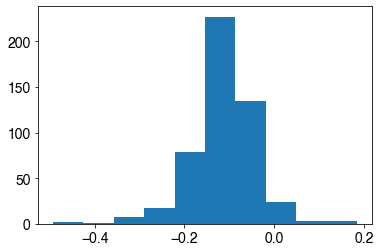

In [140]:
plt.hist(tFromFeedback)

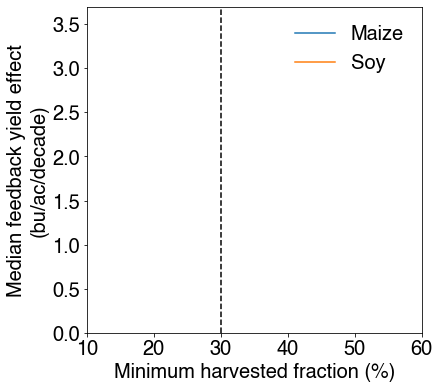

In [36]:

plt.figure(figsize=(6,6))
plt.ylim([0,3.7])
plt.plot(areaLimit, np.nanmedian(maizeYieldFromFeedback_SensTest,axis=0), label='Maize')
plt.plot(areaLimit, np.nanmedian(soybeanYieldFromFeedback_SensTest,axis=0), label='Soy')
plt.plot([30,30],[0,3.7], '--k')
plt.xlabel('Minimum harvested fraction (%)',fontsize=20)
plt.ylabel('Median feedback yield effect\n(bu/ac/decade)', fontsize=20)
plt.xticks([10,20,30,40,50,60])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('feedback-ha-sens-test.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)


In [37]:
# calculate mean yield, kdd, gdd, and trends across all counties to use for percent corrections in maps below

countyAcAll = np.array([np.nanmean(a) for a in usCounties['maizeCountyArea']])
haMaizeAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haSoybeanAllAc = np.array([np.nanmean(a) for a in usCounties['soybeanHarvestedArea']])
haTotalAllAc = haMaizeAllAc + haSoybeanAllAc
haAllFrac = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedAreaFraction']])*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
kddTrendAll = np.array([a for a in usCounties['kddTrend']])*10
gddTrendAll = np.array([a for a in usCounties['gddTrend']])*10
prTrendAll = np.array([a for a in usCounties['seasonalPrecipTrend']])*10

meanPrAll = np.array([np.nanmean(a) for a in usCounties['seasonalPrecip']])

meanNetRadAll = np.array([np.nanmean(a) for a in usCounties['seasonalNetRad']])
meanSlhfAll = -np.array([np.nanmean(a) for a in usCounties['seasonalSlhf']])

if wxData == 'era5':
    countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))
    meanNetRadAll /= countySeasonLenSec
    meanSlhfAll /= countySeasonLenSec

meanKddAll = np.array([np.nanmean(a) for a in usCounties['kdd']])
meanGddAll = np.array([np.nanmean(a) for a in usCounties['gdd']])

# convert slhf trend to w/m2/decade
slhfTrendAll = -np.array([a for a in usCounties['seasonalSlhfTrend']])
sshfTrendAll = -np.array([a for a in usCounties['seasonalSshfTrend']])
netRadTrendAll = np.array([a for a in usCounties['seasonalNetRadTrend']])

if wxData == 'era5':
    slhfTrendAll = [a*10/t for a,t in zip(slhfTrendAll, countySeasonLenSec)]
    sshfTrendAll = [a*10/t for a,t in zip(sshfTrendAll, countySeasonLenSec)]
    netRadTrendAll = [a*10/t for a,t in zip(netRadTrendAll, countySeasonLenSec)]

if useDeepak:
    yieldTrendAll = np.array([a for a in usCounties['maizeYieldTrendDeepak']])
    meanYieldAll = np.nanmean(np.array([a for a in usCounties['maizeYieldDeepak']]), axis=1)
    meanProdAll = meanYieldAll * haAllAc
else:
    maizeYieldTrendAll = np.array([a for a in usCounties['maizeYieldTrend']])*10
    maizeYieldAll = np.array([a for a in usCounties['maizeYield']])
    maizeYieldMeanAll = np.nanmean(np.array([a for a in usCounties['maizeYield']]), axis=1)
    
    soybeanYieldTrendAll = np.array([a for a in usCounties['soybeanYieldTrend']])*10
    soybeanYieldAll = np.array([a for a in usCounties['soybeanYield']])
    soybeanYieldStdAll = np.array([np.nanstd(a) for a in usCounties['soybeanYield']])
    soybeanYieldMeanAll = np.nanmean(np.array([a for a in usCounties['soybeanYield']]), axis=1)
    
    maizeYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    soybeanYieldStdAll = np.full(maizeYieldTrendAll.shape, np.nan)
    for c in range(maizeYieldAll.shape[0]):
        nn = np.where(~np.isnan(maizeYieldAll[c,:]))[0]
        if np.nansum(maizeYieldAll[c,nn]) > 0:
            maizeYieldStdAll[c] = np.nanstd(scipy.signal.detrend(maizeYieldAll[c,nn]))
        
        nn = np.where(~np.isnan(soybeanYieldAll[c,:]))[0]
        if np.nansum(soybeanYieldAll[c,nn]) > 0:
            soybeanYieldStdAll[c] = np.nanstd(scipy.signal.detrend(soybeanYieldAll[c,nn]))
    
    countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    
    totalProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)]) + np.array([x[0]*np.nanmean(x[1]) for x in zip(soybeanYieldMeanAll, countySoybeanHaAc)])
    maizeProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)])
    totalProdMeanLast5All = np.full(totalProdMeanAll.shape, np.nan)
    totalProdTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    totalHaTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    for c in range(totalProdMeanAll.size):
        p_maize = np.array([x[0]*x[1] for x in zip(maizeYieldAll[c,:], countyMaizeHaAc[c,:])])
        p_soybean = np.array([x[0]*x[1] for x in zip(soybeanYieldAll[c,:], countySoybeanHaAc[c,:])])
        nn_maize = np.where(~np.isnan(p_maize))[0]
        nn_soybean = np.where(~np.isnan(p_soybean))[0]
        
        totalProdMeanLast5All[c] = np.nanmean(p_maize[nn_maize[-5:]]) + np.nanmean(p_soybean[nn_soybean[-5:]])
        
        if len(nn_maize) >= 10:
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(p_maize[nn_maize],X).fit()
            totalProdTrendAll[c] = mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(countyMaizeHaAc[c,nn_maize],X).fit()
            totalHaTrendAll[c] = mdl.params[1]
        if len(nn_soybean) >= 10:
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(p_soybean[nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalProdTrendAll[c] = mdl.params[1]
            else:
                totalProdTrendAll[c] += mdl.params[1]
            
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(countySoybeanHaAc[c, nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalHaTrendAll[c] = mdl.params[1]
            else:
                totalHaTrendAll[c] += mdl.params[1]

nn = np.where((totalProdTrendAll > 0) & (~np.isnan(lhFromFeedback)) & (~np.isnan(haTotalFracAll)))[0]
nnIr = np.where((totalProdTrendAll > 0) & (~np.isnan(lhFromFeedback)) & (~np.isnan(haTotalFracAll)) & (~np.isnan(irSel)))[0]
nnNonIr = np.where((totalProdTrendAll > 0) & (~np.isnan(lhFromFeedback)) & (~np.isnan(haTotalFracAll)) & (np.isnan(irSel)))[0]
# noOutlierInd = np.where((abs(scipy.stats.zscore(lhFromFeedback[nn]/haTotalFracAll[nn])) < 1))[0]
adjNn = nn#[noOutlierInd]
# adjNnIr = np.intersect1d(adjNn, irSel)

In [82]:

print(np.nanmedian(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][nnNonIr]*1e6))
print(np.nanmedian(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][nnIr]*1e6))

0.5504247969922063
0.6925782486725701


In [83]:
len(nnIr)/len(adjNn)

0.1927710843373494

In [39]:
adjNn.shape

(498,)

In [42]:
# median prod coefficient value
np.nanmedian(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][adjNn])*1e6

0.5647726090447931

In [42]:
# fraction counties with positive signficant prod coefficient

nnSig = np.where((mdl_LH_Y_PValues['TotalProd_DetrendAnom'][adjNn]<0.05) & (mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][adjNn]>0))[0]
len(nnSig)/len(adjNn)


0.7811244979919679

In [44]:
# fraction of prod in counties w/ positive and sig. prod coefficient
np.nansum(totalProdMeanAll[adjNn[nnSig]])/np.nansum(totalProdMeanAll[adjNn])

0.8469364595257713

In [235]:
# median lh r2 value

np.nanmedian(mdl_LH_Y_Coefs['R2'][adjNn])

0.7415947166491339

In [236]:
# number of included counties
len(adjNn)

498

In [237]:
# total maize/soy production in included counties
np.nansum(totalProdMeanAll[adjNn])/np.nansum(totalProdMeanAll)

0.728483122481659

In [40]:
# % production occurring in counties with > 50% harvested area
indHa = np.where((haTotalAllAc[adjNn]/countyAcAll[adjNn]>.5))[0]
np.nansum(totalProdMeanAll[adjNn[indHa]])/np.nansum(totalProdMeanAll[adjNn])

0.7402204446874749

In [45]:
# FUTURE ANALYSIS

curCountyList = usCounties.copy()

countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))])
countyMaizeHaFrac = np.array([a for a in np.array(list(usCounties['maizeHarvestedAreaFraction']))])*100
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))])
countySoybeanHaFrac = np.array([a for a in np.array(list(usCounties['soybeanHarvestedAreaFraction']))])*100

countyMaizeYield = np.array(list(curCountyList['maizeYield']))
countyMaizeYieldDetrendAnom = np.array(list(curCountyList['maizeYieldDetrend']))

countySoybeanYield = np.array(list(curCountyList['soybeanYield']))
countySoybeanYieldDetrendAnom = np.array(list(curCountyList['soybeanYieldDetrend']))

countyTotalProd = np.full(countySoybeanYield.shape, np.nan)
for c in range(countyTotalProd.shape[0]):
    p_maize = np.array([x[0]*x[1] for x in zip(countyMaizeYield[c,:], countyMaizeHaAc[c,:])])
    p_soybean = np.array([x[0]*x[1] for x in zip(countySoybeanYield[c,:], countySoybeanHaAc[c,:])])
    countyTotalProd[c,:] = p_maize + p_soybean

countyPr = np.array(list(curCountyList['seasonalPrecip']))  # mm
countyKdd = np.array(list(curCountyList['kdd']))
countyGdd = np.array(list(curCountyList['gdd']))

# now these are in w/m2
countySlhf = -np.array(list(curCountyList['seasonalSlhf']))
countySshf = -np.array(list(curCountyList['seasonalSshf']))
countySsr = np.array(list(curCountyList['seasonalSsr']))
countyStr = np.array(list(curCountyList['seasonalStr']))

if wxData == 'era5':
    # convert from J/growing season/m2 to W/m2
    countySlhf /= np.matlib.repmat(countySeasonLenSec, 39, 1).T
    countySshf /= np.matlib.repmat(countySeasonLenSec, 39, 1).T
    countySsr /= np.matlib.repmat(countySeasonLenSec, 39, 1).T
    countyStr /= np.matlib.repmat(countySeasonLenSec, 39, 1).T

countyNetRad = (countySsr+countyStr)
countyU10 = np.array(list(curCountyList['seasonalU10']))
countyV10 = np.array(list(curCountyList['seasonalV10']))

NCounties = countyKdd.shape[0]
NYears = countyKdd.shape[1]

lhFromProdTrend_Stagnation = np.full([NCounties], np.nan)
lhFromProdTrend_HistGrowth = np.full([NCounties], np.nan)
shFromProdTrend_Stagnation = np.full([NCounties], np.nan)
shFromProdTrend_HistGrowth = np.full([NCounties], np.nan)

kddFromProdTrend_Stagnation = np.full([NCounties], np.nan)
kddFromProdTrend_HistGrowth = np.full([NCounties], np.nan)
gddFromProdTrend_Stagnation = np.full([NCounties], np.nan)
gddFromProdTrend_HistGrowth = np.full([NCounties], np.nan)

maizeYieldFromProdTrend_Stagnation = np.full([NCounties], np.nan)
maizeYieldFromProdTrend_HistGrowth = np.full([NCounties], np.nan)
soybeanYieldFromProdTrend_Stagnation = np.full([NCounties], np.nan)
soybeanYieldFromProdTrend_HistGrowth = np.full([NCounties], np.nan)

for i in range(NCounties):
    
    if i % 200 == 0:
        print('%d of %d'%(i, NCounties))

    if countyFips[i] not in fipsSel:
        continue
        
    curMaizeYieldDetrendAnom = countyMaizeYieldDetrendAnom[i,:]
    curMaizeYield = countyMaizeYield[i,:]
    
    curSoybeanYieldDetrendAnom = countySoybeanYieldDetrendAnom[i,:]
    curSoybeanYield = countySoybeanYield[i,:]
    
    curTotalProd = countyTotalProd[i,:]
    
    curKdd = countyKdd[i,:]
    curGdd = countyGdd[i,:]
    curSshf = countySshf[i,:]
    curSlhf = countySlhf[i,:]
    curNetRad = countyNetRad[i,:]
    curU10 = countyU10[i,:]
    curV10 = countyV10[i,:]
    curPr = countyPr[i,:]

    nnProd = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                      (~np.isnan(curTotalProd)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
    nnMaize = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                      (~np.isnan(curMaizeYield)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
    nnSoybean = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                      (~np.isnan(curSoybeanYield)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
    
    if len(nnMaize) >= 10:
        X = sm.add_constant(range(len(curMaizeYield[nnMaize])))
        mdl = sm.OLS(curMaizeYield[nnMaize], X).fit()
        curMaizeYieldIntercept = mdl.params[0]
    
    if len(nnSoybean) >= 10:
        X = sm.add_constant(range(len(curSoybeanYield[nnSoybean])))
        mdl = sm.OLS(curSoybeanYield[nnSoybean], X).fit()
        curSoybeanYieldIntercept = mdl.params[0]
    
    X = sm.add_constant(range(len(curTotalProd[nnProd])))
    mdl = sm.OLS(curTotalProd[nnProd], X).fit()
    curTotalProdIntercept = mdl.params[0]
    
    X = sm.add_constant(range(len(curPr)))
    mdl = sm.OLS(curPr, X).fit()
    curPrIntercept = mdl.params[0]
    
    X = sm.add_constant(range(len((curNetRad))))
    mdl = sm.OLS((curNetRad), X).fit()
    curNetRadIntercept = mdl.params[0]
    
    X = sm.add_constant(range(len(curU10)))
    mdl = sm.OLS(curU10, X).fit()
    curU10Intercept = mdl.params[0]
                        
    X = sm.add_constant(range(len(curV10)))
    mdl = sm.OLS(curV10, X).fit()
    curV10Intercept = mdl.params[0]
    
    curWindProd = (curU10[nnProd]**2 + curV10[nnProd]**2)**.5
    curWindMaize = (curU10[nnMaize]**2 + curV10[nnMaize]**2)**.5
    curWindSoybean = (curU10[nnSoybean]**2 + curV10[nnSoybean]**2)**.5
    
    dataProd = {'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnProd]), \
            'KDD_Detrend':scipy.signal.detrend(curKdd[nnProd])+np.nanmean(curKdd[nnProd]), \
            'KDD_Mean':np.nanmean(curKdd[nnProd]), \
            'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnProd]), \
            'GDD_Detrend':scipy.signal.detrend(curGdd[nnProd])+np.nanmean(curGdd[nnProd]), \
            'GDD_Mean':np.nanmean(curGdd[nnProd]), \
            'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnProd]), \
            'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnProd]), \
            'Wind_DetrendAnom':scipy.signal.detrend(curWindProd), \
            'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnProd]), \
            'Pr_Detrend':scipy.signal.detrend(curPr[nnProd])+np.nanmean(curPr[nnProd]), \
            'Pr_Mean':np.nanmean(curPr[nnProd]), \
            'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnProd]), \
            'TotalProd_Detrend':scipy.signal.detrend(curTotalProd[nnProd])+curTotalProdIntercept, \
            'TotalProd_DetrendAnom':scipy.signal.detrend(curTotalProd[nnProd])}
    
    dfProd = pd.DataFrame(dataProd, \
                      columns=['KDD_DetrendAnom', 'KDD_Detrend', 'KDD_Mean', \
                               'GDD_DetrendAnom', 'GDD_Detrend', 'GDD_Mean', \
                               'SLHF_DetrendAnom', \
                               'SSHF_DetrendAnom', \
                               'NetRad_DetrendAnom', \
                               'Pr_DetrendAnom', 'Pr_Detrend', 'Pr_Mean', \
                               'Wind_DetrendAnom', \
                               'TotalProd_Detrend', 'TotalProd_DetrendAnom'])
    
    if len(nnMaize) >= 10:
        dataMaize = {'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnMaize]), \
                'KDD_Detrend':scipy.signal.detrend(curKdd[nnMaize])+np.nanmean(curKdd[nnMaize]), \
                'KDD_Mean':np.nanmean(curKdd[nnMaize]), \
                'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnMaize]), \
                'GDD_Detrend':scipy.signal.detrend(curGdd[nnMaize])+np.nanmean(curGdd[nnMaize]), \
                'GDD_Mean':np.nanmean(curGdd[nnSoybean]), \
                'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnMaize]), \
                'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnMaize]), \
                'Wind_DetrendAnom':scipy.signal.detrend(curWindMaize), \
                'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnMaize]), \
                'Pr_Detrend':scipy.signal.detrend(curPr[nnMaize])+np.nanmean(curPr[nnMaize]), \
                'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnMaize]), \
                'MaizeYield_Detrend':scipy.signal.detrend(curMaizeYield[nnMaize])+curMaizeYieldIntercept}
        
        dfMaize = pd.DataFrame(dataMaize, \
                      columns=['KDD_DetrendAnom', 'KDD_Detrend', 'KDD_Mean', \
                               'GDD_DetrendAnom', 'GDD_Detrend', 'GDD_Mean', \
                               'SLHF_DetrendAnom', \
                               'SSHF_DetrendAnom', \
                               'NetRad_DetrendAnom', \
                               'Pr_DetrendAnom', 'Pr_Detrend', \
                               'Wind_DetrendAnom', \
                               'MaizeYield_Detrend', 'MaizeYield_DetrendAnom'])
    
    if len(nnSoybean) >= 10:
        dataSoybean = {'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnSoybean]), \
                'KDD_Detrend':scipy.signal.detrend(curKdd[nnSoybean])+np.nanmean(curKdd[nnSoybean]), \
                'KDD_Mean':np.nanmean(curKdd[nnSoybean]), \
                'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnSoybean]), \
                'GDD_Detrend':scipy.signal.detrend(curGdd[nnSoybean])+np.nanmean(curGdd[nnSoybean]), \
                'GDD_Mean':np.nanmean(curGdd[nnSoybean]), \
                'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnSoybean]), \
                'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnSoybean]), \
                'Wind_DetrendAnom':scipy.signal.detrend(curWindSoybean), \
                'Pr_Detrend':scipy.signal.detrend(curPr[nnSoybean])+np.nanmean(curPr[nnSoybean]), \
                'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnSoybean]), \
                'SoybeanYield_Detrend':scipy.signal.detrend(curSoybeanYield[nnSoybean])+curSoybeanYieldIntercept}
        
        dfSoybean = pd.DataFrame(dataSoybean, \
                      columns=['KDD_DetrendAnom', 'KDD_Detrend', 'KDD_Mean', \
                               'GDD_DetrendAnom', 'GDD_Detrend', 'GDD_Mean', \
                               'SLHF_DetrendAnom', \
                               'SSHF_DetrendAnom', \
                               'NetRad_DetrendAnom', \
                               'Pr_DetrendAnom', 'Pr_Detrend', \
                               'Wind_DetrendAnom', \
                               'SoybeanYield_Detrend', 'SoybeanYield_DetrendAnom'])
    
    
    mdl_LH_Y = smf.ols(formula='SLHF_DetrendAnom ~ TotalProd_DetrendAnom + Pr_DetrendAnom + NetRad_DetrendAnom + Wind_DetrendAnom', \
                       data=dfProd).fit()    
    mdl_LH_SH = smf.ols(formula='SSHF_DetrendAnom ~ SLHF_DetrendAnom + NetRad_DetrendAnom', data=dfProd).fit()
    mdl_SH_KDD = smf.ols(formula='KDD_DetrendAnom ~ SSHF_DetrendAnom', data=dfProd).fit()
    mdl_SH_GDD = smf.ols(formula='GDD_DetrendAnom ~ SSHF_DetrendAnom', data=dfProd).fit()
    
    if len(nnMaize) >= 10:
        mdl_KDD_GDD_PR_MaizeYield = smf.ols(formula='MaizeYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfMaize).fit()
    
    if len(nnSoybean) >= 10:
        mdl_KDD_GDD_PR_SoybeanYield = smf.ols(formula='SoybeanYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfSoybean).fit()

        
    NFutureYears = 30
    # now calculate how much production scenario contributes to latent heat using our regression (above)
    # trained with detrended anomalies. run this using yield variation (minus the 1981 intercept), so we
    # capture both variability and trend
    X = {'TotalProd_DetrendAnom':[0]*NFutureYears,
         'Pr_DetrendAnom':[0]*NFutureYears,
         'NetRad_DetrendAnom':[0]*NFutureYears,
         'Wind_DetrendAnom':[0]*NFutureYears}
    lhFromProd_Stagnation = mdl_LH_Y.predict(X).values
    X = {'TotalProd_DetrendAnom':[totalProdTrendAll[i]*x for x in range(NFutureYears)],
         'Pr_DetrendAnom':[0]*NFutureYears,
         'NetRad_DetrendAnom':[0]*NFutureYears,
         'Wind_DetrendAnom':[0]*NFutureYears}
    lhFromProd_HistGrowth = mdl_LH_Y.predict(X).values
    
    X = {'TotalProd_DetrendAnom':[0]*NFutureYears,
         'Pr_DetrendAnom':[0]*NFutureYears,
         'NetRad_DetrendAnom':[netRadTrendAll[i]/10*x for x in range(NFutureYears)],
         'Wind_DetrendAnom':[0]*NFutureYears}
    lhFromCC = mdl_LH_Y.predict(X).values
    
    # how much did the lh change (from yield) change sh - estimate using the lh produced by yield 
    # from above
    X = {'SLHF_DetrendAnom':lhFromProd_Stagnation,
         'NetRad_DetrendAnom':[0]*NFutureYears}
    shFromProd_Stagnation = mdl_LH_SH.predict(X).values 
    X = {'SLHF_DetrendAnom':lhFromProd_HistGrowth,
         'NetRad_DetrendAnom':[0]*NFutureYears}
    shFromProd_HistGrowth = mdl_LH_SH.predict(X).values 
    
    X = {'SLHF_DetrendAnom':[0]*NFutureYears,
         'NetRad_DetrendAnom':[netRadTrendAll[i]/10*x for x in range(NFutureYears)]}
    shFromCC = mdl_LH_SH.predict(X).values 
    
    # without yield growth - predict gdd/kdd change from sh change
    # resulting from yield, estimated above
    X = {'SSHF_DetrendAnom':shFromProd_Stagnation}
    kddFromProd_Stagnation = mdl_SH_KDD.predict(X).values
    gddFromProd_Stagnation = mdl_SH_GDD.predict(X).values
    X = {'SSHF_DetrendAnom':shFromProd_HistGrowth}
    kddFromProd_HistGrowth = mdl_SH_KDD.predict(X).values
    gddFromProd_HistGrowth = mdl_SH_GDD.predict(X).values
    
    X = {'SSHF_DetrendAnom':shFromCC}
    kddFromCC = mdl_SH_KDD.predict(X).values
    gddFromCC = mdl_SH_GDD.predict(X).values
    
    
    # MAIZE ---------------------------------------------------
    if len(nnMaize) >= 10:
        # and now calculate yield using gdd/kdd/pr
        X = {'GDD_Detrend':dataProd['GDD_Mean']+gddFromProd_Stagnation+gddFromCC,
             'KDD_Detrend':dataProd['KDD_Mean']+kddFromProd_Stagnation+kddFromCC, 
             'Pr_Detrend':np.array([dataProd['Pr_Mean']]*NFutureYears)}
        maizeYieldFromProd_Stagnation = mdl_KDD_GDD_PR_MaizeYield.predict(X).values
        X = {'GDD_Detrend':dataProd['GDD_Mean']+gddFromProd_HistGrowth+gddFromCC,
             'KDD_Detrend':dataProd['KDD_Mean']+kddFromProd_HistGrowth+kddFromCC, 
             'Pr_Detrend':np.array([dataProd['Pr_Mean']]*NFutureYears)}
        maizeYieldFromProd_HistGrowth = mdl_KDD_GDD_PR_MaizeYield.predict(X).values

    
    # SOYBEAN ---------------------------------------------------
    if len(nnSoybean) >= 10:
        # and now calculate yield using gdd/kdd/pr
        X = {'GDD_Detrend':dataProd['GDD_Mean']+gddFromProd_Stagnation+gddFromCC,
             'KDD_Detrend':dataProd['KDD_Mean']+kddFromProd_Stagnation+kddFromCC, 
             'Pr_Detrend':np.array([dataProd['Pr_Mean']]*NFutureYears)}
        soybeanYieldFromProd_Stagnation = mdl_KDD_GDD_PR_SoybeanYield.predict(X).values
        X = {'GDD_Detrend':dataProd['GDD_Mean']+gddFromProd_HistGrowth+gddFromCC,
             'KDD_Detrend':dataProd['KDD_Mean']+kddFromProd_HistGrowth+kddFromCC, 
             'Pr_Detrend':np.array([dataProd['Pr_Mean']]*NFutureYears)}
        soybeanYieldFromProd_HistGrowth = mdl_KDD_GDD_PR_SoybeanYield.predict(X).values

        
    # LH
    X = sm.add_constant(range(len(lhFromProd_Stagnation)))
    mdl = sm.OLS(lhFromProd_Stagnation, X).fit()
    lhFromProdTrend_Stagnation[i] = mdl.params[1]*10
    X = sm.add_constant(range(len(lhFromProd_HistGrowth)))
    mdl = sm.OLS(lhFromProd_HistGrowth, X).fit()
    lhFromProdTrend_HistGrowth[i] = mdl.params[1]*10
    
    # SH
    X = sm.add_constant(range(len(shFromProd_Stagnation)))
    mdl = sm.OLS(shFromProd_Stagnation, X).fit()
    shFromProdTrend_Stagnation[i] = mdl.params[1]*10
    X = sm.add_constant(range(len(shFromProd_HistGrowth)))
    mdl = sm.OLS(shFromProd_HistGrowth, X).fit()
    shFromProdTrend_HistGrowth[i] = mdl.params[1]*10
        
    # KDD
    X = sm.add_constant(range(len(kddFromProd_Stagnation)))
    mdl = sm.OLS(kddFromProd_Stagnation, X).fit()
    kddFromProdTrend_Stagnation[i] = mdl.params[1]*10
    X = sm.add_constant(range(len(kddFromProd_HistGrowth)))
    mdl = sm.OLS(kddFromProd_HistGrowth, X).fit()
    kddFromProdTrend_HistGrowth[i] = mdl.params[1]*10
    
    # GDD
    X = sm.add_constant(range(len(gddFromProd_Stagnation)))
    mdl = sm.OLS(gddFromProd_Stagnation, X).fit()
    gddFromProdTrend_Stagnation[i] = mdl.params[1]*10
    X = sm.add_constant(range(len(gddFromProd_HistGrowth)))
    mdl = sm.OLS(gddFromProd_HistGrowth, X).fit()
    gddFromProdTrend_HistGrowth[i] = mdl.params[1]*10

    
    # MAIZE Yield ----------------------------------------
    if len(nnMaize) >= 10:
        X = sm.add_constant(range(len(maizeYieldFromProd_Stagnation)))
        mdl = sm.OLS(maizeYieldFromProd_Stagnation, X).fit()
        maizeYieldFromProdTrend_Stagnation[i] = mdl.params[1]*10
        X = sm.add_constant(range(len(maizeYieldFromProd_HistGrowth)))
        mdl = sm.OLS(maizeYieldFromProd_HistGrowth, X).fit()
        maizeYieldFromProdTrend_HistGrowth[i] = mdl.params[1]*10
    
    # SOYBEAN Yield ----------------------------------------
    if len(nnSoybean) >= 10:
        X = sm.add_constant(range(len(soybeanYieldFromProd_Stagnation)))
        mdl = sm.OLS(soybeanYieldFromProd_Stagnation, X).fit()
        soybeanYieldFromProdTrend_Stagnation[i] = mdl.params[1]*10
        X = sm.add_constant(range(len(soybeanYieldFromProd_HistGrowth)))
        mdl = sm.OLS(soybeanYieldFromProd_HistGrowth, X).fit()
        soybeanYieldFromProdTrend_HistGrowth[i] = mdl.params[1]*10




0 of 2249
200 of 2249
400 of 2249
600 of 2249
800 of 2249
1000 of 2249
1200 of 2249
1400 of 2249
1600 of 2249
1800 of 2249
2000 of 2249
2200 of 2249


[Text(0, 0, '$R_{net}$')]

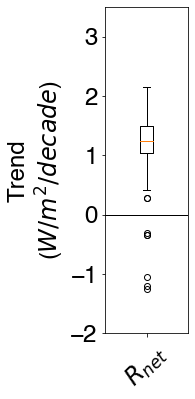

In [38]:
plt.figure(figsize=(1.5,6))
plt.ylim([-2, 3.5])
plt.xlim([.75, 1.25])
nn = np.where(~np.isnan(lhFromProdTrend_Stagnation))[0]
plt.boxplot(np.array(netRadTrendAll)[nn], positions=[1], widths=[.075])
plt.plot([.75, 1.25], [0,0], '-k', lw=1)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.ylabel('Trend\n($W/m^2/decade$)', fontsize=24)
plt.xticks([1], rotation=45)
plt.gca().set_xticklabels(['$R_{net}$'], fontsize=24)

[Text(0, 0, 'LH'), Text(0, 0, 'SH')]

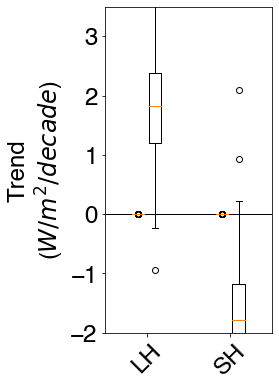

In [46]:
plt.figure(figsize=(3,6))
plt.xlim([.5, 2.5])
plt.ylim([-2, 3.5])
nn = np.where(~np.isnan(lhFromProdTrend_Stagnation))[0]
plt.boxplot([lhFromProdTrend_Stagnation[nn], lhFromProdTrend_HistGrowth[nn]], positions=[.9, 1.1], widths=[.15, .15])
plt.boxplot([shFromProdTrend_Stagnation[nn], shFromProdTrend_HistGrowth[nn]], positions=[1.9, 2.1], widths=[.15, .15])
plt.plot([.5, 2.5], [0,0], '-k', lw=1)

plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.ylabel('Trend\n($W/m^2/decade$)', fontsize=24)
plt.xticks([1, 2], rotation=45)
plt.gca().set_xticklabels(['LH', 'SH'], fontsize=24)

[Text(0, 0, 'GDD'), Text(0, 0, 'KDD')]

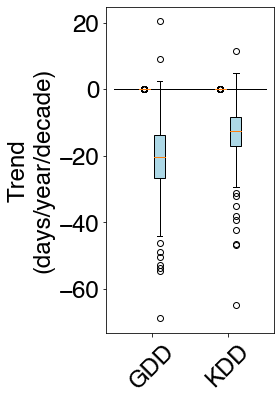

In [47]:
plt.figure(figsize=(3,6))
nn = np.where(~np.isnan(kddFromProdTrend_Stagnation))[0]
b1 = plt.boxplot([gddFromProdTrend_Stagnation[nn], gddFromProdTrend_HistGrowth[nn]], positions=[.9, 1.1], widths=[.15, .15], patch_artist=True)
colors = ['pink', 'lightblue']
b1['boxes'][0].set_facecolor(colors[0])
b1['boxes'][1].set_facecolor(colors[1])

b2 = plt.boxplot([kddFromProdTrend_Stagnation[nn], kddFromProdTrend_HistGrowth[nn]], positions=[1.9, 2.1], widths=[.15, .15], patch_artist=True)
colors = ['pink', 'lightblue']
b2['boxes'][0].set_facecolor(colors[0])
b2['boxes'][1].set_facecolor(colors[1])

plt.plot([.5, 2.5], [0,0], '-k', lw=1)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.ylabel('Trend\n(days/year/decade)', fontsize=24)
plt.xticks([1, 2], rotation=45)
plt.gca().set_xticklabels(['GDD', 'KDD'], fontsize=24)

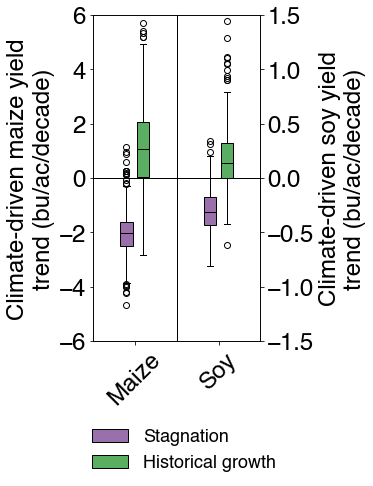

In [64]:

cmap = plt.cm.get_cmap('PRGn')

fig, ax1 = plt.subplots(figsize=(3,6))
ax1.set_xlim([.5, 2.5])
ax1.set_ylim([-6,6])
nn = np.where(~np.isnan(kddFromProdTrend_Stagnation))[0]
b1 = ax1.boxplot([maizeYieldFromProdTrend_Stagnation[nn], maizeYieldFromProdTrend_HistGrowth[nn]], positions=[.9, 1.1], widths=[.15, .15], patch_artist=True, \
                bootstrap=5000, medianprops={'color':'k'})

b1['boxes'][0].set_facecolor(cmap(.2))
b1['boxes'][1].set_facecolor(cmap(.8))

ax1.plot([.5, 2.5], [0,0], '-k', lw=1)
ax1.plot([1.5, 1.5], [-6, 6], '-k', lw=1)
ax1.set_yticks([-6, -4, -2, 0, 2, 4, 6])
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)


ax2 = plt.twinx()
ax2.set_xlim([.5, 2.5])
ax2.set_ylim([-1.5, 1.5])
ax2.set_ylabel('Climate-driven soy yield\ntrend (bu/ac/decade)', fontsize=24)
b2 = ax2.boxplot([soybeanYieldFromProdTrend_Stagnation[nn], soybeanYieldFromProdTrend_HistGrowth[nn]], positions=[1.9, 2.1], widths=[.15, .15], patch_artist=True, \
                bootstrap=5000, medianprops={'color':'k'})

b2['boxes'][0].set_facecolor(cmap(.2))
b2['boxes'][1].set_facecolor(cmap(.8))

ax2.tick_params(axis='y', labelsize=24)
ax1.set_ylabel('Climate-driven maize yield\ntrend (bu/ac/decade)', fontsize=24)
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Maize', 'Soy'], fontsize=24, rotation=45)

leg = plt.legend([b1["boxes"][0], b1["boxes"][1]], ['Stagnation', 'Historical growth'], \
                 prop = {'size':18, 'family':'Helvetica'}, loc = 'lower left', bbox_to_anchor=(-.1, -.45))
leg.get_frame().set_linewidth(0.0)


In [38]:
nn = np.where(~np.isnan(mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend']))[0]
ind = np.where(mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][nn]>0)[0]
len(ind)/len(mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][nn])

0.024745269286754003

In [39]:
nn = np.where(~np.isnan(mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend']))[0]
ind = np.where(mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend'][nn]<0.05)[0]
len(ind)/len(mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend'][nn])

0.06841339155749636

0.03190476635250183

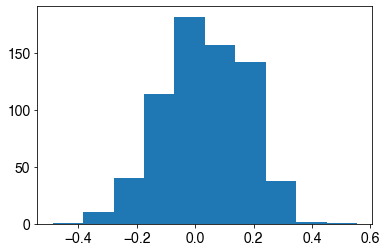

In [40]:
#     mdl_Param_Corr['Prod-Pr'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['Pr_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Prod-NetRad'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['NetRad_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Prod-Wind'][i] = np.corrcoef(dfProd['TotalProd_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Pr-NetRad'][i] = np.corrcoef(dfProd['Pr_DetrendAnom'], dfProd['NetRad_DetrendAnom'])[0,1]
#     mdl_Param_Corr['Pr-Wind'][i] = np.corrcoef(dfProd['Pr_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
#     mdl_Param_Corr['NetRad-Wind'][i] = np.corrcoef(dfProd['NetRad_DetrendAnom'], dfProd['Wind_DetrendAnom'])[0,1]
var='Prod-Wind'
nn = np.where(~np.isnan(mdl_Param_Corr[var]))[0]
plt.hist(mdl_Param_Corr[var][nn])
np.nanmedian(mdl_Param_Corr[var])
# scipy.stats.ttest_1samp(mdl_Param_Corr[var][nn], 0)

In [41]:
(1-110/170)*450*2.26e6/np.nanmean(countySeasonLenSec)/NYears*10

6.798116439290668

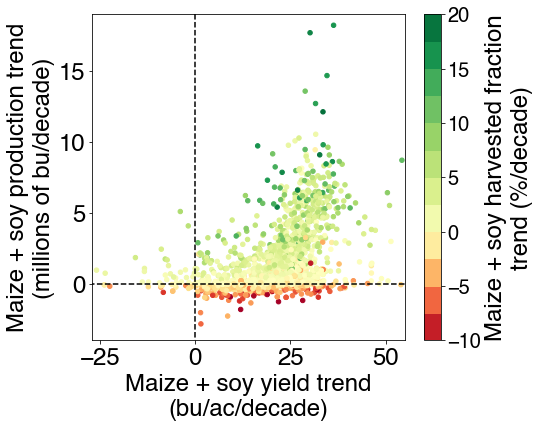

In [71]:
nn = np.where((~np.isnan(totalProdTrendAll)) & (~np.isnan(soybeanYieldTrendAll + maizeYieldTrendAll)) & (~np.isnan(totalHaTrendAll)))[0]

data = {'meanProd':totalProdMeanAll[nn], \
        'prodTrend':totalProdTrendAll[nn]/1e6*10, \
        'yieldTrend':soybeanYieldTrendAll[nn] + maizeYieldTrendAll[nn], \
        'haTrend':totalHaTrendAll[nn]/countyAcAll[nn]*100*10}
                        
df = pd.DataFrame(data, \
                  columns=['prodTrend', 'yieldTrend', 'haTrend'])
prodDriversMdl = smf.ols(formula='prodTrend ~ yieldTrend + haTrend', data=df).fit()
# prodDriversMdl.summary()

midnorm = MidpointNormalize(vmin=-10, vcenter=0, vmax=20)

# plt.scatter(data['haTrend'], data['prodTrend'])
fig = plt.figure(figsize=(7, 6))
plt.xlim([-27, 55])
plt.ylim([-4, 19])
a = plt.scatter(data['yieldTrend'], data['prodTrend'], c=data['haTrend'], cmap='RdYlGn', s = 20, norm=midnorm)
plt.plot([-30, 75], [0, 0], '--k')
plt.plot([0, 0], [-10, 20], '--k')

plt.xlabel('Maize + soy yield trend\n(bu/ac/decade)', fontsize=24)
plt.ylabel('Maize + soy production trend\n(millions of bu/decade)', fontsize=24)
plt.xticks([-25, 0, 25, 50])
plt.yticks([0, 5, 10, 15])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

cbar = fig.colorbar(a, ax=plt.gca(),
                    ticks=np.arange(-10, 20.1, 5), boundaries=np.arange(-10, 20.1, 2.5))
cbar.set_label('Maize + soy harvested fraction\ntrend (%/decade)', fontsize=24)
cbar.ax.tick_params(labelsize=20)
plt.savefig('us-prod-trend-vs-yield-trend-scatter-colorbar.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)
# plt.scatter(totalHaTrendAll, soybeanYieldTrendAll + maizeYieldTrendAll)
# plt.scatter(soybeanYieldTrendAll + maizeYieldTrendAll, totalProdTrendAll)

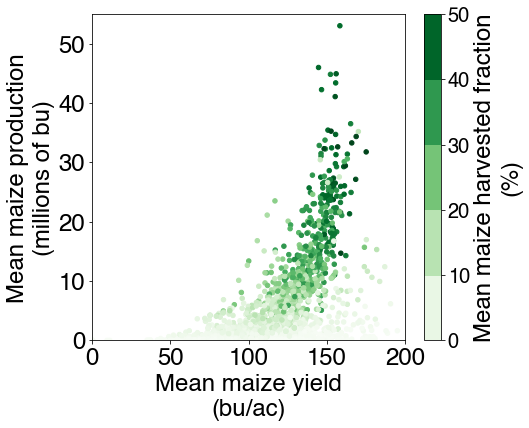

In [72]:
nn = np.where((~np.isnan(maizeProdMeanAll)) & (~np.isnan(maizeYieldMeanAll)) & (~np.isnan(np.nanmean(countyMaizeHaAc, axis=1))))[0]

data = {'meanMaizeProd':maizeProdMeanAll[nn]/1e6, \
        'meanMaizeYield':maizeYieldMeanAll[nn], \
        'meanMaizeHa':np.nanmean(countyMaizeHaAc[nn, :], axis=1)/countyAcAll[nn]*100}
                        
df = pd.DataFrame(data, \
                  columns=['meanMaizeProd', 'meanMaizeYield', 'meanMaizeHa'])
# prodDriversMdl = smf.ols(formula='prodTrend ~ yieldTrend + haTrend', data=df).fit()
# prodDriversMdl.summary()

v1 = 0
v2 = 50.1
vcenter = (v1+v2)/2

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

# plt.scatter(data['haTrend'], data['prodTrend'])
fig = plt.figure(figsize=(7, 6))
plt.xlim([0, 200])
plt.ylim([0, 55])
a = plt.scatter(data['meanMaizeYield'], data['meanMaizeProd'], c=data['meanMaizeHa'], cmap='Greens', s = 20, norm=midnorm)
# plt.plot([0, 200], [0, 0], '--k')
# plt.plot([0, 0], [-10, 20], '--k')

plt.xlabel('Mean maize yield\n(bu/ac)', fontsize=24)
plt.ylabel('Mean maize production\n(millions of bu)', fontsize=24)
plt.xticks(np.arange(0, 201, 50))
plt.yticks(np.arange(0, 51, 10))
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)

cbar = fig.colorbar(a, ax=plt.gca(),
                    ticks=np.arange(v1, v2, 10), boundaries=np.arange(v1, v2, 10))
cbar.set_label('Mean maize harvested fraction\n(%)', fontsize=24)
cbar.ax.tick_params(labelsize=20)
plt.savefig('us-maize-prod-vs-yield-scatter-vs-ha-colorbar.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)
# plt.scatter(totalHaTrendAll, soybeanYieldTrendAll + maizeYieldTrendAll)
# plt.scatter(soybeanYieldTrendAll + maizeYieldTrendAll, totalProdTrendAll)

In [50]:

# production benefit from ag-int
# maizeYieldFromFeedback is in bu/ac/decade
maizeProdFromFeedback = maizeYieldFromFeedback * NYears/10 * haMaizeAllAc
soybeanProdFromFeedback = soybeanYieldFromFeedback * NYears/10 * haSoybeanAllAc
print('maize from feedback (M bu): %.2f, (MT): %.2f'%((np.nansum(maizeProdFromFeedback[adjNn])/1e6), (np.nansum(maizeProdFromFeedback[adjNn])/1000)*.0254))
print('soy (M bu): %.2f, (MT): %.2f'%(np.nansum(soybeanProdFromFeedback[adjNn])/1e6, np.nansum(soybeanProdFromFeedback[adjNn])/1000*.0272155))#*27/1000/1000))

maize from feedback (M bu): 597.71, (MT): 15181.76
soy (M bu): 87.04, (MT): 2368.78


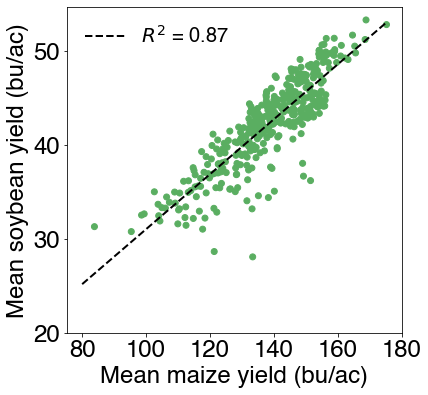

In [111]:
cmap = plt.cm.get_cmap('PRGn')
mmean = np.nanmean(countyMaizeYield,axis=1)
smean = np.nanmean(countySoybeanYield,axis=1)

# nn = np.where((~np.isnan(mmean)) & (~np.isnan(smean)))[0]

X = sm.add_constant(mmean[adjNn])
mdl = sm.OLS(smean[adjNn], X).fit()

x1 = 80
x2 = 175

plt.figure(figsize=(6,6))
plt.scatter(mmean[adjNn],smean[adjNn],c=[cmap(.8)]*len(adjNn))
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = '$R^2$ = 0.87')
plt.xlabel('Mean maize yield (bu/ac)', fontsize=24)
plt.xticks(np.arange(80, 181, 20))
plt.ylabel('Mean soybean yield (bu/ac)', fontsize=24)
plt.yticks([20, 30, 40, 50])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('maize-soy-mean-yield-scatter.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

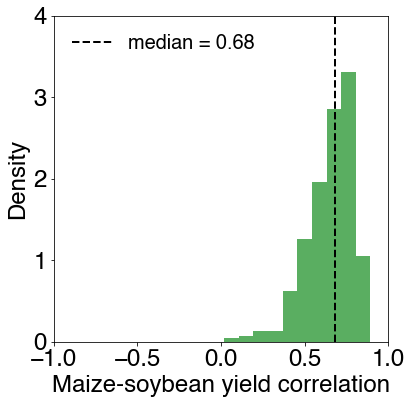

In [41]:
# correlation between maize and soy yields

mc = []
for c in range(countySoybeanYield.shape[0]):
    nn = np.where((~np.isnan(countySoybeanYield[c,:])) & (~np.isnan(countyMaizeYield[c,:])))[0]
    if len(nn) > 0:
        soybeanYieldDt = scipy.signal.detrend(countySoybeanYield[c, nn])
        maizeYieldDt = scipy.signal.detrend(countyMaizeYield[c,nn])
        mc.append(np.corrcoef(soybeanYieldDt, maizeYieldDt)[0,1])
    else:
        mc.append(np.nan)
mc = np.array(mc)
plt.figure(figsize=(6,6))
plt.ylim([0,4])
plt.hist(mc[adjNn], density=True, facecolor=cmap(.8), bins=10)
plt.plot([np.nanmedian(mc[adjNn]), np.nanmedian(mc[adjNn])], [0, 4], '--k', lw=2, label='median = %.2f'%np.nanmedian(mc[adjNn]))
plt.xlabel('Maize-soybean yield correlation', fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.xticks(np.arange(-1, 1.1, .5))
# plt.yticks([20, 30, 40, 50])
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('maize-soy-yield-corr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [119]:
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     5.271
Date:                Wed, 21 Oct 2020   Prob (F-statistic):             0.0222
Time:                        10:58:46   Log-Likelihood:                 885.96
No. Observations:                 394   AIC:                            -1768.
Df Residuals:                     392   BIC:                            -1760.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0593      0.005     11.011      0.000       0.049       0.070
x1             0.0002   9.01e-05      2.296      0.022    2.97e-05       0.000
==============================================================================
Omnibus:                       12.371   Durbin-Watson:                   1.430
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.816
Skew:                           0.349   Prob(JB):                      0.00100
Kurtosis:                       3.594   Cond. No.                         250.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

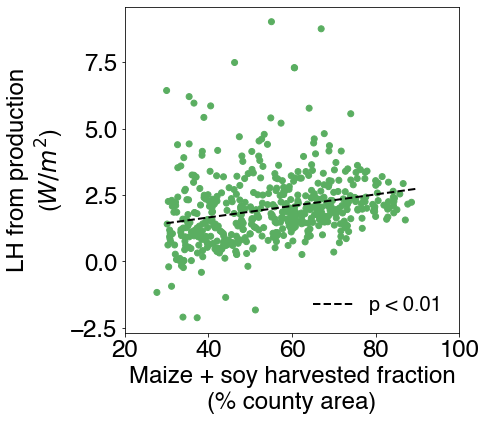

In [278]:
cmap = plt.cm.get_cmap('PRGn')

haFrac = haTotalAllAc/countyAcAll*100

# nn = np.where((~np.isnan(haFrac)) & (haFrac > 20) & (~np.isnan(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'])))[0]

# print('frac < 20%% ha: %.2f'%(len(np.where(haFrac[]<20)[0])/len(nn)))

X = sm.add_constant(haFrac[adjNn])
mdl = sm.OLS(lhFromFeedback[adjNn], X).fit()

x1 = areaLimit
x2 = 90

plt.figure(figsize=(6,6))
# plt.xlim([-.1,55])
# plt.ylim([-.1,4.5])
plt.scatter(haFrac[adjNn], lhFromFeedback[adjNn], c = [cmap(.8)]*len(adjNn))
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = 'p < 0.01')
plt.xlabel('Maize + soy harvested fraction\n(% county area)', fontsize=24)
plt.xticks(np.arange(20, 101, 20))
plt.ylabel('LH from production\n($W/m^2$)', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('lh-from-prod-vs-harvested-frac.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

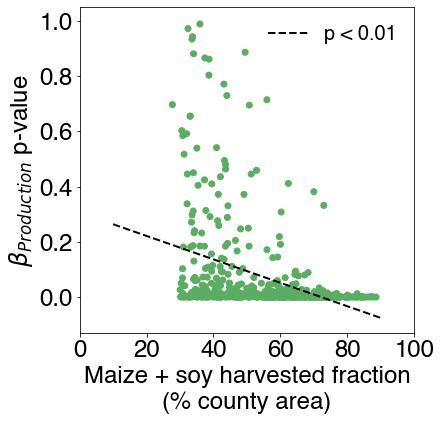

In [281]:
cmap = plt.cm.get_cmap('PRGn')

haFrac = haTotalAllAc/countyAcAll*100

# nn = np.where((~np.isnan(haFrac)) & (haFrac > 20) & (~np.isnan(mdl_LH_Y_Coefs['TotalProd_DetrendAnom'])))[0]

# print('frac < 20%% ha: %.2f'%(len(np.where(haFrac[]<20)[0])/len(nn)))

X = sm.add_constant(haFrac[adjNn])
mdl = sm.OLS(mdl_LH_Y_PValues['TotalProd_DetrendAnom'][adjNn], X).fit()

x1 = 10
x2 = 90

plt.figure(figsize=(6,6))
# plt.xlim([-.1,55])
# plt.ylim([0,.06])
plt.scatter(haFrac[adjNn], mdl_LH_Y_PValues['TotalProd_DetrendAnom'][adjNn], c = [cmap(.8)]*len(adjNn))
plt.plot([x1, x2], mdl.params[0]+[x1*mdl.params[1], x2*mdl.params[1]], '--k', lw=2, label = 'p < 0.01')
plt.xlabel('Maize + soy harvested fraction\n(% county area)', fontsize=24)
plt.xticks(np.arange(0, 101, 20))
plt.ylabel('$\\beta_{Production}$ p-value', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('beta-prod-pval-vs-harvested-frac.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


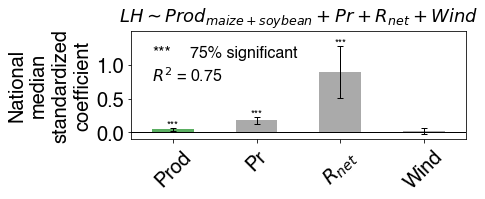

In [46]:
# this enables legends for text objects to show the significance markers
import string
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text, Annotation
from matplotlib.legend import Legend
class TextHandlerA(HandlerBase):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, artist.get_text(), fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({Text : TextHandlerA()})



width = .5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(6,2))
plt.xlim([.5,4.5])
if wxData == 'era5':
    plt.ylim([-.1,1.5])
elif wxData == 'gldas':
    plt.ylim([-.1,1.8])

l1_TotalProd = np.nanpercentile(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][adjNn],10)
l2_TotalProd = np.nanpercentile(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][adjNn],90)
ind_TotalProd = np.where((mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm']>l1_TotalProd) & (mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm']<l2_TotalProd))[0]

xvalues = [1,2,3,4]
yvalues = [np.nanmedian(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][ind_TotalProd]), 
           np.nanmedian(mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_Coefs['Wind_DetrendAnom_Norm'][ind_TotalProd])]
pvalues = [len(np.where(mdl_LH_Y_Norm_PValues['TotalProd_DetrendAnom_Norm']<0.05)[0])/len(adjNn), 
           len(np.where(mdl_LH_Y_Norm_PValues['Pr_DetrendAnom_Norm']<0.05)[0])/len(adjNn),
           len(np.where(mdl_LH_Y_Norm_PValues['NetRad_DetrendAnom_Norm']<0.05)[0])/len(adjNn),
           len(np.where(mdl_LH_Y_Norm_PValues['Wind_DetrendAnom_Norm']<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['Wind_DetrendAnom_Norm'][ind_TotalProd])]

facecolors = [cmap(.8), '#aaaaaa', '#aaaaaa', '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 5.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3,4], rotation=45, fontsize=20)
if wxData == 'era5':
    plt.yticks([0, .5, 1], fontsize=20)
elif wxData == 'gldas':
    plt.yticks([0, .5, 1, 1.5], fontsize=20)
plt.gca().set_xticklabels(['Prod', 'Pr', '$R_{net}$', 'Wind'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$LH \sim Prod_{maize+soybean} + Pr + R_{net} + Wind$', fontsize=18)

if wxData == 'era5':
    plt.text(.75, .75, '$R^2$ = %0.2f'%(np.nanmedian(mdl_LH_Y_Coefs['R2'][ind_TotalProd])), fontdict = {'size':16, 'family':'Helvetica'})
elif wxData == 'gldas':
    plt.text(.75, .5, '$R^2$ = %0.2f'%(np.nanmedian(mdl_LH_Y_Coefs['R2'][ind_TotalProd])), fontdict = {'size':16, 'family':'Helvetica'})

i = 0
k = 0
errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.23
    
    if pval > .75:
        if i == 0:
            t = plt.text(xpos, ypos, '***', ha='center')
        else:
            plt.text(xpos, ypos, '***', ha='center')
        i += 1
    elif pval > .5:
        if k == 0:
            t2 = plt.text(xpos, ypos, '*', ha='center')
        k += 1

if wxData == 'era5':
    leg = plt.legend([t], ['75% significant'], prop = {'size':16, 'family':'Helvetica'}, loc = 'upper left')
elif wxData == 'gldas':
    leg = plt.legend([t,t2], ['75% significant', '50% significant'], prop = {'size':16, 'family':'Helvetica'}, loc = 'upper left')
leg.get_frame().set_linewidth(0.0)
plt.savefig('reg-coef-lh-yield-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

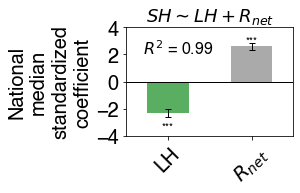

In [283]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(3,2))
plt.xlim([.5,2.5])
plt.ylim([-4,4])

xvalues = [1,2]
yvalues = [np.nanmedian(mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm'][adjNn]), 
           np.nanmedian(mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'][adjNn])]
pvalues = [len(np.where(mdl_LH_SH_Norm_PValues['SLHF_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_LH_SH_Norm_PValues['NetRad_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm'][adjNn]),
         np.nanstd(mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'][adjNn])]
facecolors = [cmap(.8), '#aaaaaa', '#aaaaaa', '#aaaaaa', '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 2.5], [0,0], '-k', lw=1)
plt.xticks([1,2], rotation=45, fontsize=20)
plt.yticks([-4, -2, 0, 2, 4], fontsize=20)
plt.gca().set_xticklabels(['LH', '$R_{net}$'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$SH \sim LH + R_{net}$', fontsize=18)

plt.text(.7, 2, '$R^2$ = %0.2f'%(np.nanmedian(mdl_LH_SH_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.35
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

plt.savefig('reg-coef-lh-sh-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

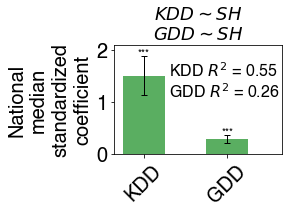

In [67]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(3,2))
plt.xlim([.5,2.5])
plt.ylim([0,2.1])

xvalues = [.85,1.85]
yvalues = [np.nanmedian(mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn]), 
           np.nanmedian(mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn])]
pvalues = [len(np.where(mdl_SH_KDD_Norm_PValues['SSHF_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_SH_GDD_Norm_PValues['SSHF_DetrendAnom_Norm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn]),
         np.nanstd(mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][adjNn])]
facecolors = [cmap(.8), cmap(.8)]
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 2.5], [0,0], '-k', lw=1)
plt.xticks([.85,1.85], rotation=45, fontsize=20)
plt.yticks([0, 1, 2], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$KDD \sim SH$\n$GDD \sim SH$', fontsize=18)

plt.text(1.15, 1.5, 'KDD $R^2$ = %0.2f'%(np.nanmedian(mdl_SH_KDD_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})
plt.text(1.15, 1.1, 'GDD $R^2$ = %0.2f'%(np.nanmedian(mdl_SH_GDD_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.23
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

plt.savefig('reg-coef-sh-kdd-gdd-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [257]:
yvalues

[1.5114314618877704, 0.2843300039103295]

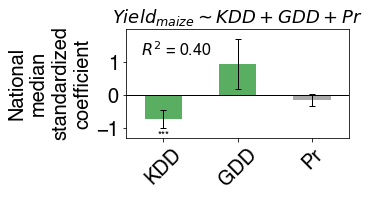

In [285]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(4,2))
plt.xlim([.5,3.5])
plt.ylim([-1.3,2])

xvalues = [1,2,3]
yvalues = [np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
pvalues = [len(np.where(mdl_KDD_GDD_MaizeYield_Norm_PValues['KDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_KDD_GDD_MaizeYield_Norm_PValues['GDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn),
           len(np.where(mdl_KDD_GDD_MaizeYield_Norm_PValues['Pr_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
         np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
         np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
facecolors = [cmap(.8), cmap(.8), '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 3.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3], rotation=45, fontsize=20)
plt.yticks([-1, 0, 1], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD', 'Pr'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$Yield_{maize} \sim KDD + GDD + Pr$', fontsize=18)

plt.text(.7, 1.2, '$R^2$ = %0.2f'%(np.nanmedian(mdl_KDD_GDD_MaizeYield_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.325
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

plt.savefig('reg-coef-yield-maize-kdd-gdd-pr-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

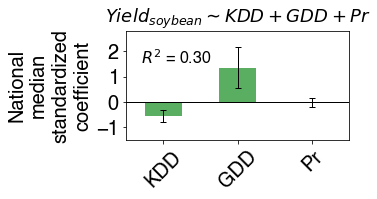

In [286]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(4,2))
plt.xlim([.5,3.5])
plt.ylim([-1.5,2.8])

xvalues = [1,2,3]
yvalues = [np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
pvalues = [len(np.where(mdl_KDD_GDD_SoybeanYield_Norm_PValues['KDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn), 
           len(np.where(mdl_KDD_GDD_SoybeanYield_Norm_PValues['GDD_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn),
           len(np.where(mdl_KDD_GDD_SoybeanYield_Norm_PValues['Pr_DetrendNorm'][adjNn]<0.05)[0])/len(adjNn)]
yerrs = [np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm'][adjNn]), 
         np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm'][adjNn]),
         np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'][adjNn])]
facecolors = [cmap(.8), cmap(.8), '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 3.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3], rotation=45, fontsize=20)
plt.yticks([-1, 0, 1, 2], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD', 'Pr'], fontsize=20)
plt.ylabel('National\nmedian\nstandardized\ncoefficient', fontsize=20)

plt.title('$Yield_{soybean} \sim KDD + GDD + Pr$', fontsize=18)

plt.text(.7, 1.5, '$R^2$ = %0.2f'%(np.nanmedian(mdl_KDD_GDD_SoybeanYield_Coefs['R2'][adjNn])), fontdict = {'size':16, 'family':'Helvetica'})

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.55
    
    if pval > .8:
        plt.text(xpos, ypos, '***', ha='center')
#     elif pval < .05:
#         plt.text(xpos, ypos, '**', ha='center')
#     elif pval < .1:
#         plt.text(xpos, ypos, '*', ha='center')

plt.savefig('reg-coef-soybean-yield-kdd-gdd-pr-nass-%s.eps'%wxData, format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

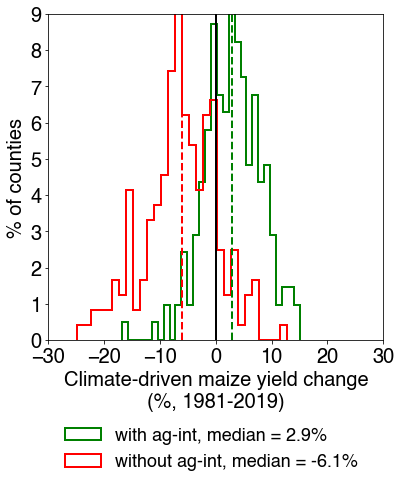

In [58]:
from scipy.stats import norm

# convert these trends back to changes over the time period
nnAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]

maizeYieldChgAgInt = (maizeYieldChgFeedbackWithAgInt[nnAgInt]*NYears/10)/np.nanmean(countyMaizeYield[nnAgInt], axis=1)*100
maizeYieldChgNoAgInt = (maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)/np.nanmean(countyMaizeYield[nnNoAgInt], axis=1)*100

maizeYieldChgAgInt = maizeYieldChgAgInt[abs(maizeYieldChgAgInt)<25]
maizeYieldChgNoAgInt = maizeYieldChgNoAgInt[abs(maizeYieldChgNoAgInt)<25]

plt.figure(figsize=(6,6))

plt.xlim([-25, 25])
if wxData == 'era5':
    plt.ylim([0, 0.09])
elif wxData == 'gldas':
    plt.ylim([0, 0.084])

histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(maizeYieldChgAgInt, bins=30, density=True, histtype='step', color='g', lw=2, \
                                                       label='with ag-int, median = %0.1f%%'%np.nanmedian(maizeYieldChgAgInt))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(maizeYieldChgNoAgInt, bins=30, density=True, histtype='step', color='r', lw=2, \
                                                             label='without ag-int, median = %0.1f%%'%np.nanmedian(maizeYieldChgNoAgInt))
if wxData == 'era5':
    plt.plot([0,0], [0,0.09], '-k', lw=2)
elif wxData == 'gldas':
    plt.plot([0,0], [0,0.084], '-k', lw=2)

plt.plot([np.nanmedian(maizeYieldChgAgInt),np.nanmedian(maizeYieldChgAgInt)], [0,0.09], '--g', lw=2)
plt.plot([np.nanmedian(maizeYieldChgNoAgInt),np.nanmedian(maizeYieldChgNoAgInt)], [0,0.09], '--r', lw=2)
    
plt.xlabel('Climate-driven maize yield change\n(%, 1981-2019)', fontsize=20)
plt.ylabel('% of counties', fontsize=20)

if wxData == 'era5':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7, 8, 9], fontsize=20)
elif wxData == 'gldas':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7,8], fontsize=20)
    
plt.xticks([-30, -20, -10, 0, 10, 20, 30], fontsize=20)

leg = plt.legend(prop = {'size':18, 'family':'Helvetica'}, loc = 'lower left', bbox_to_anchor=(0, -.45))
leg.get_frame().set_linewidth(0.0)

# if useDeepak:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
# else:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)

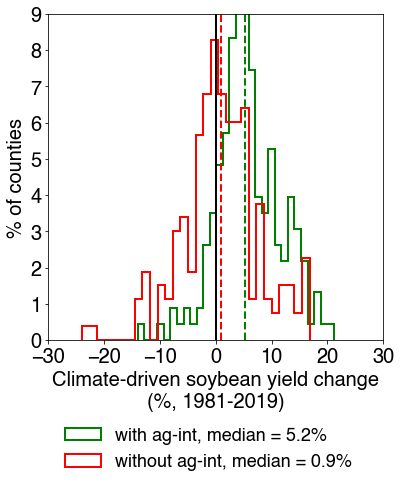

In [59]:
from scipy.stats import norm

# convert these trends back to changes over the time period
nnAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithAgInt[adjNn]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithoutAgInt[adjNn]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]

soybeanYieldChgAgInt = (soybeanYieldChgFeedbackWithAgInt[nnAgInt]*NYears/10)/np.nanmean(countySoybeanYield[nnAgInt], axis=1)*100
soybeanYieldChgNoAgInt = (soybeanYieldChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)/np.nanmean(countySoybeanYield[nnNoAgInt], axis=1)*100

soybeanYieldChgAgInt = soybeanYieldChgAgInt[abs(soybeanYieldChgAgInt)<25]
soybeanYieldChgNoAgInt = soybeanYieldChgNoAgInt[abs(soybeanYieldChgNoAgInt)<25]

plt.figure(figsize=(6,6))

plt.xlim([-25, 25])
if wxData == 'era5':
    plt.ylim([0, 0.09])
elif wxData == 'gldas':
    plt.ylim([0, 0.084])

histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(soybeanYieldChgAgInt, bins=30, density=True, histtype='step', color='g', lw=2, \
                                                       label='with ag-int, median = %0.1f%%'%np.nanmedian(soybeanYieldChgAgInt))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(soybeanYieldChgNoAgInt, bins=30, density=True, histtype='step', color='r', lw=2, \
                                                             label='without ag-int, median = %0.1f%%'%np.nanmedian(soybeanYieldChgNoAgInt))

if wxData == 'era5':
    plt.plot([0,0], [0,0.09], '-k', lw=2)
elif wxData == 'gldas':
    plt.plot([0,0], [0,0.084], '-k', lw=2)

plt.plot([np.nanmedian(soybeanYieldChgAgInt),np.nanmedian(soybeanYieldChgAgInt)], [0,0.09], '--g', lw=2)
plt.plot([np.nanmedian(soybeanYieldChgNoAgInt),np.nanmedian(soybeanYieldChgNoAgInt)], [0,0.09], '--r', lw=2)

plt.xlabel('Climate-driven soybean yield change\n(%, 1981-2019)', fontsize=20)
plt.ylabel('% of counties', fontsize=20)
if wxData == 'era5':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08, .09], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7, 8, 9], fontsize=20)
elif wxData == 'gldas':
    plt.yticks([0, .01, .02, .03, .04, .05, .06, .07, .08], fontsize=20)
    plt.gca().set_yticklabels([0,1,2,3,4,5,6,7,8], fontsize=20)
    
plt.xticks([-30, -20, -10, 0, 10, 20, 30], fontsize=20)

leg = plt.legend(prop = {'size':18, 'family':'Helvetica'}, loc = 'lower left', bbox_to_anchor=(0, -.45))
leg.get_frame().set_linewidth(0.0)

# if useDeepak:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
# else:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)

In [66]:
scipy.stats.ttest_1samp(soybeanYieldChgNoAgInt, 0)

Ttest_1sampResult(statistic=-2.060344112731682, pvalue=0.04000548058529801)

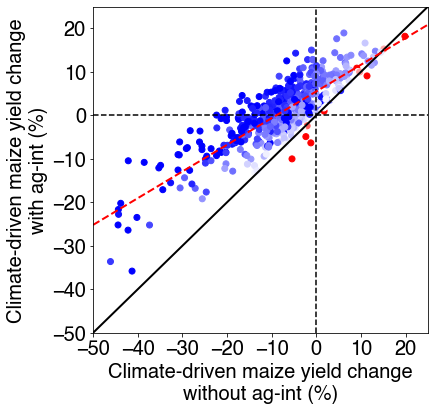

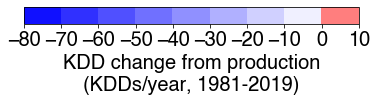

In [52]:
nnAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]

maizeYieldChgAgInt = (maizeYieldChgFeedbackWithAgInt[nnAgInt]*NYears/10)/np.nanmean(countyMaizeYield[nnAgInt], axis=1)*100
maizeYieldChgNoAgInt = (maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)/np.nanmean(countyMaizeYield[nnNoAgInt], axis=1)*100

X = sm.add_constant(maizeYieldChgNoAgInt)
mdl = sm.OLS(maizeYieldChgAgInt, X).fit()

x1 = -50
x2 = 25

kddChg = (kddChgFeedbackWithAgInt[nnAgInt]*NYears/10)-(kddChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)

midnorm = MidpointNormalize(vmin=-80, vcenter=0, vmax=10)

fig = plt.figure(figsize=(6,6))
plt.xlim([-50, 25])
plt.ylim([-50, 25])
a = plt.scatter(maizeYieldChgNoAgInt, maizeYieldChgAgInt, c=kddChg, cmap='bwr', norm=midnorm)
plt.plot([-50, 25], [0, 0], '--k', lw=1.5)
plt.plot([0, 0], [-50, 25], '--k', lw=1.5)
plt.plot([-50, 25], [-50, 25], '-k', lw=2)

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2)

plt.ylabel('Climate-driven maize yield change\nwith ag-int (%)', fontsize=20)
plt.xlabel('Climate-driven maize yield change\nwithout ag-int (%)', fontsize=20)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)

# if useDeepak:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
# else:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)

fig = plt.figure()
plt.gca().set_visible(False)

cbar = fig.colorbar(a, ax=plt.gca(), orientation='horizontal', 
                    ticks=np.arange(-80, 11, 10), boundaries=np.arange(-80, 11, 10))
cbar.set_label('KDD change from production\n(KDDs/year, 1981-2019)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

# if useDeepak:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-colorbar-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
# else:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-colorbar-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)


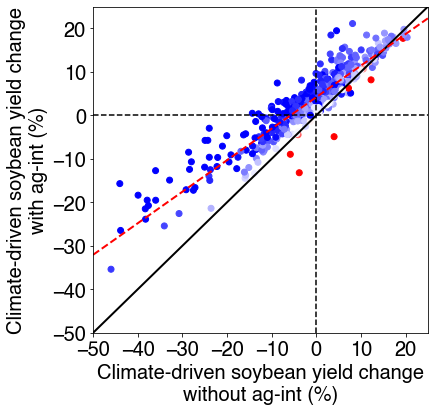

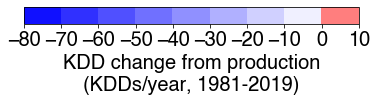

In [53]:

nnAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithAgInt[adjNn]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((soybeanYieldChgFeedbackWithoutAgInt[adjNn]*NYears/10)/np.nanmean(countySoybeanYield[adjNn], axis=1)*100))[0]]


soybeanYieldChgAgInt = (soybeanYieldChgFeedbackWithAgInt[nnAgInt]*NYears/10)/np.nanmean(countySoybeanYield[nnAgInt], axis=1)*100
soybeanYieldChgNoAgInt = (soybeanYieldChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)/np.nanmean(countySoybeanYield[nnNoAgInt], axis=1)*100

X = sm.add_constant(soybeanYieldChgNoAgInt)
mdl = sm.OLS(soybeanYieldChgAgInt, X).fit()

x1 = -50
x2 = 25

kddChg = (kddChgFeedbackWithAgInt[nnAgInt]*NYears/10)-(kddChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)

midnorm = MidpointNormalize(vmin=-80, vcenter=0, vmax=10)

fig = plt.figure(figsize=(6,6))
plt.xlim([-50, 25])
plt.ylim([-50, 25])
a = plt.scatter(soybeanYieldChgNoAgInt, soybeanYieldChgAgInt, c=kddChg, cmap='bwr', norm=midnorm)
plt.plot([-50, 25], [0, 0], '--k', lw=1.5)
plt.plot([0, 0], [-50, 25], '--k', lw=1.5)
plt.plot([-50, 25], [-50, 25], '-k', lw=2)

plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2)

plt.ylabel('Climate-driven soybean yield change\nwith ag-int (%)', fontsize=20)
plt.xlabel('Climate-driven soybean yield change\nwithout ag-int (%)', fontsize=20)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)

# if useDeepak:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)
# else:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.01)

fig = plt.figure()
plt.gca().set_visible(False)

cbar = fig.colorbar(a, ax=plt.gca(), orientation='horizontal', 
                    ticks=np.arange(-80, 11, 10), boundaries=np.arange(-80, 11, 10))
cbar.set_label('KDD change from production\n(KDDs/year, 1981-2019)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

# if useDeepak:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-colorbar-deepak-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
# else:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-colorbar-nass-%s.png'%wxData, format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)


In [54]:
print('maize quad TL: %.2f'%(len(np.where((maizeYieldChgNoAgInt<0) & (maizeYieldChgAgInt>0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean quad TL: %.2f'%(len(np.where((soybeanYieldChgNoAgInt<0) & (soybeanYieldChgAgInt>0))[0])/len(soybeanYieldChgNoAgInt)))

print('maize quad BL: %.2f'%(len(np.where((maizeYieldChgNoAgInt<0) & (maizeYieldChgAgInt<0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean quad BL: %.2f'%(len(np.where((soybeanYieldChgNoAgInt<0) & (soybeanYieldChgAgInt<0))[0])/len(soybeanYieldChgNoAgInt)))

print('maize quad TR: %.2f'%(len(np.where((maizeYieldChgNoAgInt>0) & (maizeYieldChgAgInt>0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean quad TR: %.2f'%(len(np.where((soybeanYieldChgNoAgInt>0) & (soybeanYieldChgAgInt>0))[0])/len(soybeanYieldChgNoAgInt)))

maize quad TL: 0.38
soybean quad TL: 0.24
maize quad BL: 0.43
soybean quad BL: 0.26
maize quad TR: 0.19
soybean quad TR: 0.50


In [ ]:
nnAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]
nnNoAgInt = adjNn[np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt[adjNn]*NYears/10)/np.nanmean(countyMaizeYield[adjNn], axis=1)*100))[0]]

netRadChg = np.nanmean((netRadObsTrend[nnAgInt]*NYears/10)/np.nanmean(countyNetRad[nnAgInt, :], axis=1)*100)
netRadErr = np.nanstd((netRadObsTrend[nnAgInt]*NYears/10)/np.nanmean(countyNetRad[nnAgInt, :], axis=1)*100)

lhChg = [np.nanmean(lhChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1))*100, \
         np.nanmean(lhChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1))*100]
lhErr = [np.nanstd(lhChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100), \
         np.nanstd(lhChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]

lhObsChg = [np.nanmean((lhObsTrend[nnAgInt]*NYears/10)/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]
lhObsErr = [np.nanstd((lhObsTrend[nnAgInt]*NYears/10)/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]

shChg = [np.nanmean(shChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1))*100, \
         np.nanmean(shChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1))*100]
shErr = [np.nanstd(shChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1)*100), \
         np.nanstd(shChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1)*100)]


labels = ['Net\nRadiation', 'Latent\nHeat', 'Sensible\nHeat']

x = [1,2,3]
width = .35
plt.figure(figsize=(6,6))
plt.ylim([.5, 3.5])

plt.barh([1], netRadChg, height=width, xerr=netRadErr, capsize=3, error_kw={'lw':1}, facecolor='gray', label='Observed')
plt.plot(netRadChg, [1], 'ok', markersize=5)

plt.barh([2-width/2], lhChg[0], height=width, xerr=lhErr[0], capsize=3, error_kw={'lw':1}, facecolor='#e34627', label='No ag-int')
plt.plot(lhChg[0], [2-width/2], 'ok', markersize=5)
plt.barh([2+width/2], lhChg[1], height=width, xerr=lhErr[1], capsize=3, error_kw={'lw':1}, facecolor='#19a651', label='With ag-int')
plt.plot(lhChg[1], [2+width/2], 'ok', markersize=5)

plt.barh([3-width/2], shChg[0], height=width, xerr=shErr[0], capsize=3, error_kw={'lw':1}, facecolor='#e34627')
plt.plot(shChg[0], [3-width/2], 'ok', markersize=5)
plt.barh([3+width/2], shChg[1], height=width, xerr=shErr[1], capsize=3, error_kw={'lw':1}, facecolor='#19a651')
plt.plot(shChg[1], [3+width/2], 'ok', markersize=5)

plt.plot([0, 0], [.5, 3.5], '-k', lw=1)

plt.gca().set_yticks(x)
plt.gca().set_yticklabels(labels, fontsize=20)

plt.xlabel('U.S. mean change (%, 1981-2019)', fontsize=20)
plt.xticks(range(-20, 81, 10), fontsize=20)

plt.gca().invert_yaxis()  # labels read top-to-bottom

l1 = plt.legend(prop = {'size':16, 'family':'Helvetica'}, loc='upper right')
l1.get_frame().set_linewidth(0)


In [ ]:
scipy.stats.ks_2samp(maizeYieldChgAgInt, maizeYieldChgNoAgInt)

In [245]:
# calculate the fraction of yield trend explained by feedback over upper midwest to compare with Butler et al PNAS 
# (but only the 'climate' component, not changes to growing season length)

print('fraction of trend from ag-int in upper midwest')
inds = []
for si, s in enumerate(stateSel):
    if s in ['IA', 'MN', 'SD', 'NE', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'MO']:
        inds.append(si)
inds = np.array(inds)
print('maize: %.2f%%'%np.nanmean(maizeYieldTrendFrac[inds]))

inds = []
for si, s in enumerate(stateSel):
    if s in ['IA', 'MN', 'SD', 'NE', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'MO']:
        inds.append(si)
inds = np.array(inds)
print('soybean: %.2f%%'%np.nanmean(soybeanYieldTrendFrac[inds]))

fraction of trend from ag-int in upper midwest
maize: 15.67%
soybean: 9.28%


In [246]:
# and the fraction explained over all maize-growing counties
np.nanmean(maizeYieldTrendFrac)

14.808243880359077

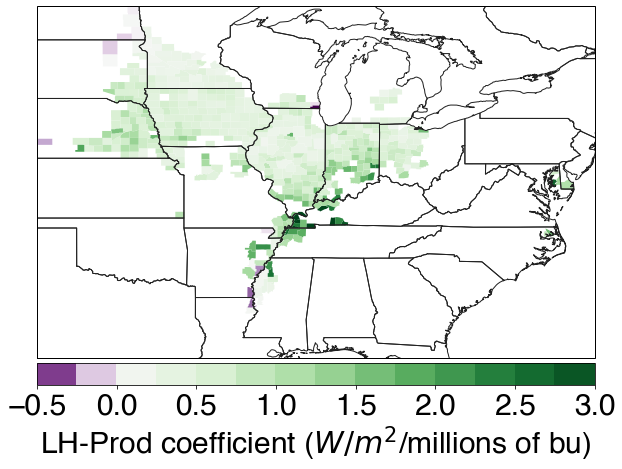

In [65]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -0.5
v2 = 3.1
vcenter = 0
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][ind[0]]*1e6
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-Prod coefficient ($W/m^2$/millions of bu)', fontsize=mapFontSize)
plt.savefig('coef-lh-prod.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

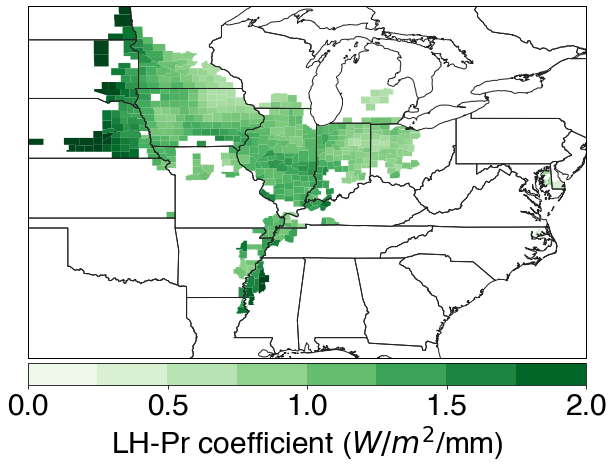

In [66]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 2.1
vcenter = (v1+v2)/2
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_Y_Coefs['Pr_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-Pr coefficient ($W/m^2$/mm)', fontsize=mapFontSize)
plt.savefig('coef-lh-pr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

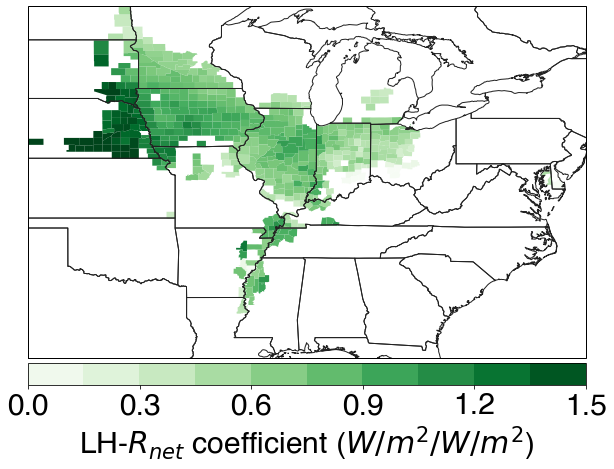

In [67]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 1.51
vcenter = (v1+v2)/2
vstep = .15
vlabelstep = .3

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_Y_Coefs['NetRad_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-$R_{net}$ coefficient ($W/m^2/W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-lh-rnet.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

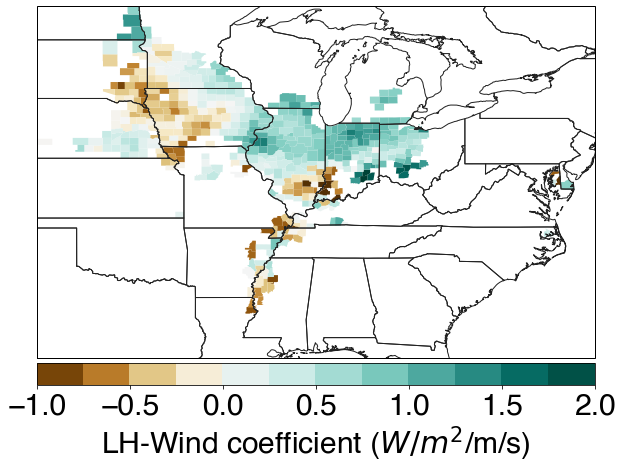

In [48]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 2.1
vcenter = 0
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_Y_Coefs['Wind_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-Wind coefficient ($W/m^2$/m/s)', fontsize=mapFontSize)
plt.savefig('coef-lh-wind.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

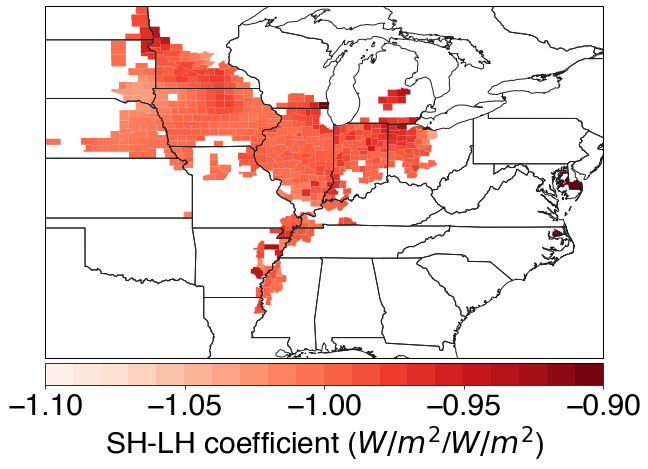

In [49]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1.1
v2 = -.899
vcenter = (v1+v2)/2
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_SH_Coefs['SLHF_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('SH-LH coefficient ($W/m^2$/$W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-sh-lh.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

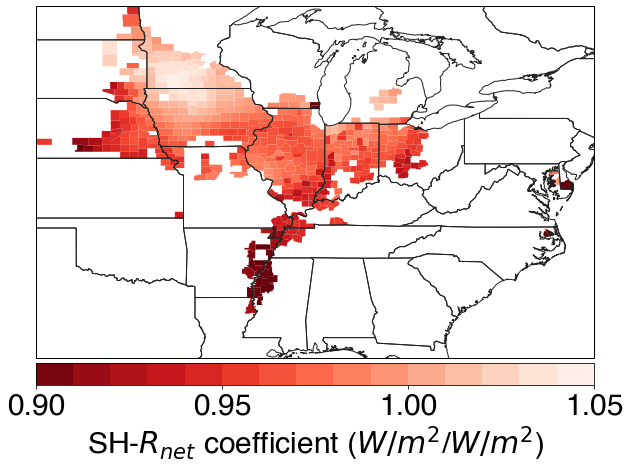

In [68]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = .9
v2 = 1.051
vcenter = (v1+v2)/2
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds_r')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_LH_SH_Coefs['NetRad_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('SH-$R_{net}$ coefficient ($W/m^2$/$W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-sh-netrad.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

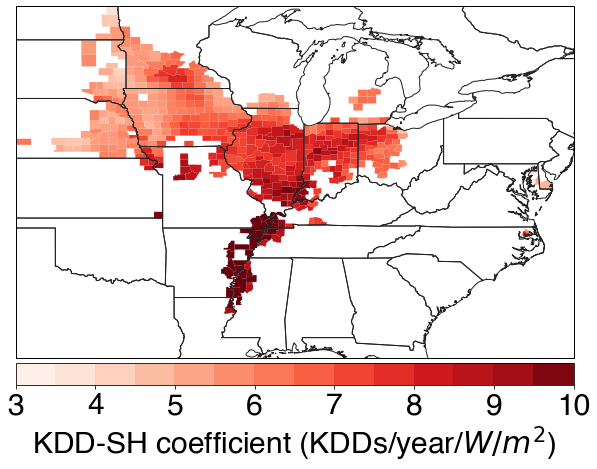

In [69]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 3
v2 = 10.1
vcenter = (v1+v2)/2
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_SH_KDD_Coefs['SSHF_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD-SH coefficient (KDDs/year/$W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-kdd-sh.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

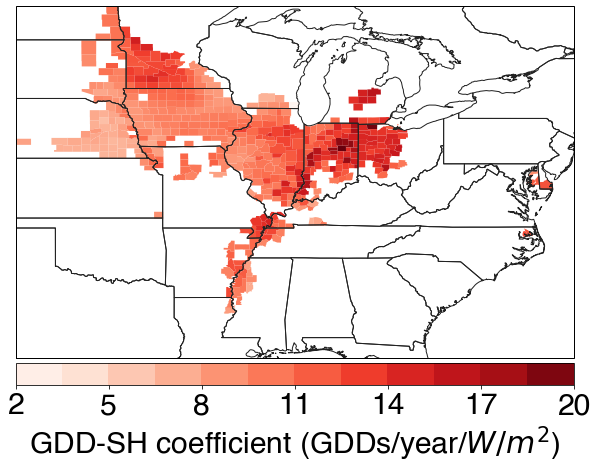

In [70]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 2
v2 = 20.1
vcenter = (v1+v2)/2
vstep = 1.5
vlabelstep = 3

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_SH_GDD_Coefs['SSHF_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('GDD-SH coefficient (GDDs/year/$W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-gdd-sh.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

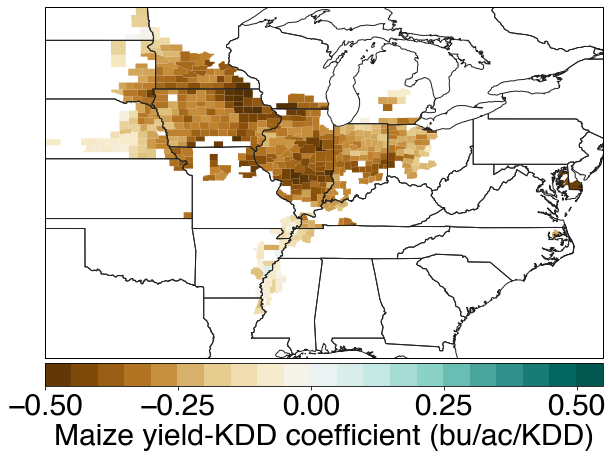

In [53]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.5
v2 = .6
vstep = .05
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_MaizeYield_Coefs['KDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield-KDD coefficient (bu/ac/KDD)', fontsize=mapFontSize)
plt.savefig('coef-maize-yield-kdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

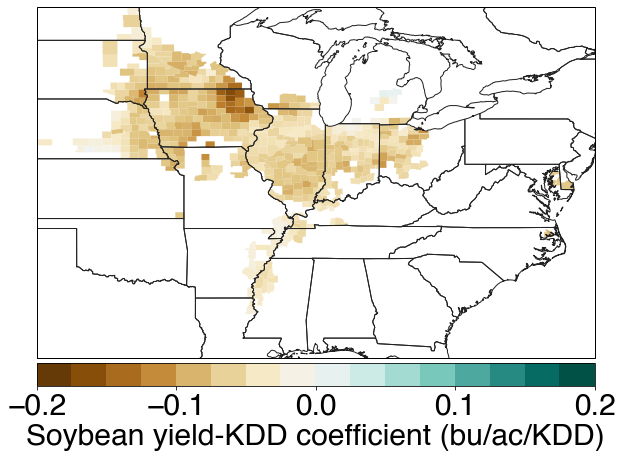

In [54]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.2
v2 = .21
vstep = .025
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield-KDD coefficient (bu/ac/KDD)', fontsize=mapFontSize)
plt.savefig('coef-soybean-yield-kdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

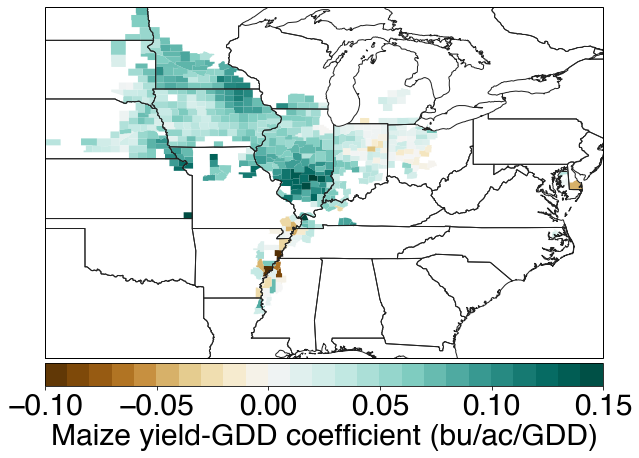

In [55]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.1
v2 = .16
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_MaizeYield_Coefs['GDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield-GDD coefficient (bu/ac/GDD)', fontsize=mapFontSize)
plt.savefig('coef-maize-yield-gdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

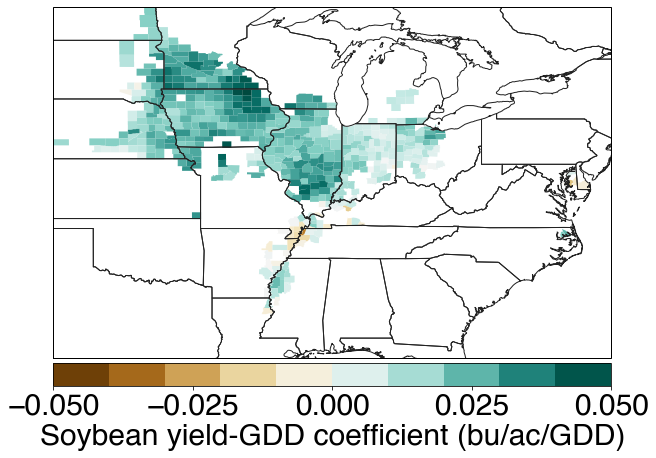

In [56]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.05
v2 = .051
vstep = .01
vlabelstep = .025

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_SoybeanYield_Coefs['GDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield-GDD coefficient (bu/ac/GDD)', fontsize=mapFontSize)
plt.savefig('coef-soybean-yield-gdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

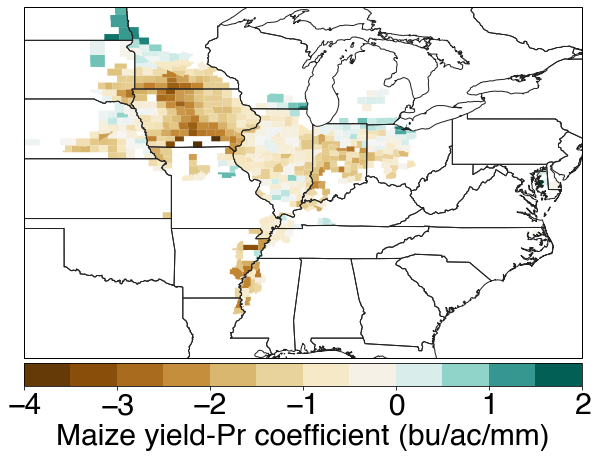

In [57]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -4
v2 = 2.1
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_MaizeYield_Coefs['Pr_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield-Pr coefficient (bu/ac/mm)', fontsize=mapFontSize)
plt.savefig('coef-maize-yield-pr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

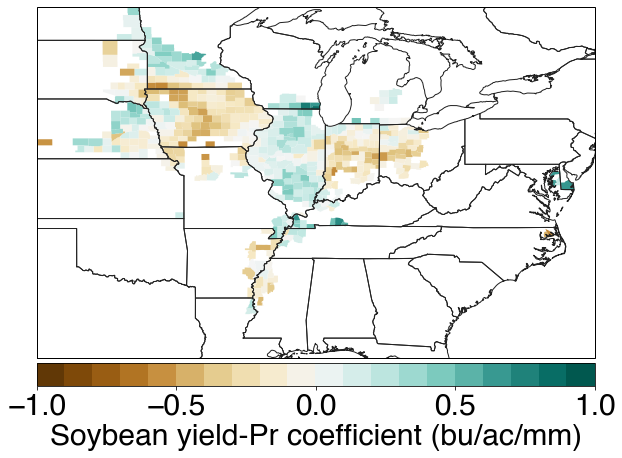

In [58]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = mdl_KDD_GDD_SoybeanYield_Coefs['Pr_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield-Pr coefficient (bu/ac/mm)', fontsize=mapFontSize)
plt.savefig('coef-soybean-yield-pr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

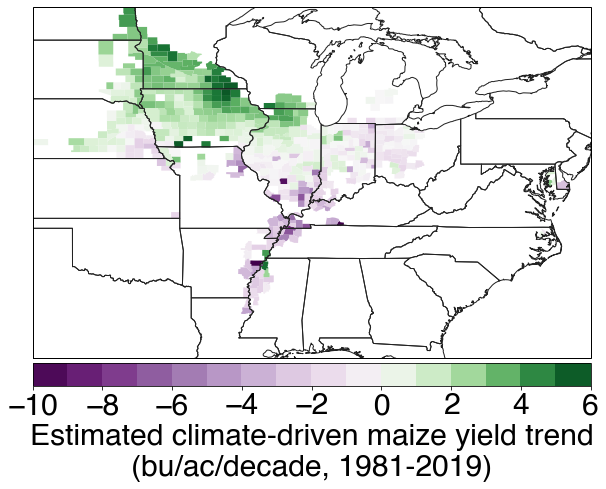

In [304]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -10
    v2 = 6.1
    vstep = 1
    vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = maizeYieldChgFeedbackWithAgInt[ind[0]]/meanYieldAll[ind[0]]*100
        else:
            curVal = maizeYieldChgFeedbackWithAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Climate-driven maize yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated climate-driven maize yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('climate-driven-maize-yield-change-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [63]:
np.nanmedian(maizeYieldChgFeedbackWithAgInt[adjNn])

0.4244641811519878

In [64]:
np.nanmedian(maizeYieldChgFeedbackWithoutAgInt[adjNn])

-2.256438897925963

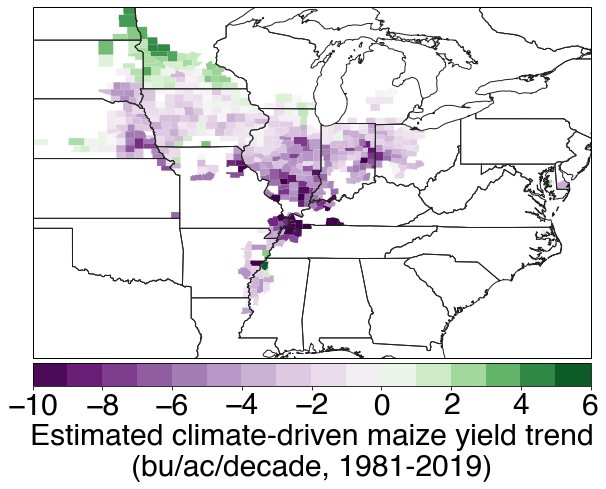

In [312]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -10
    v2 = 6.1
    vstep = 1
    vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = maizeYieldChgFeedbackWithoutAgInt[ind[0]]/meanYieldAll[ind[0]]*100
        else:
            curVal = maizeYieldChgFeedbackWithoutAgInt[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('No agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# plt.xlabel('Climate-driven yield change with warming and no ag-int (% 1981-2019)', fontsize=mapFontSize)

#     cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
         boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
         pad=0.01, aspect=25, shrink=1)

cb.ax.tick_params(labelsize=mapFontSize)

if showPct:
#     cb.set_label('Climate-driven yield change with warming and no ag-int (% 1981-2019)', fontsize=mapFontSize)
    cb.set_label('Climate-driven maize yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated climate-driven maize yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('climate-driven-maize-yield-change-no-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

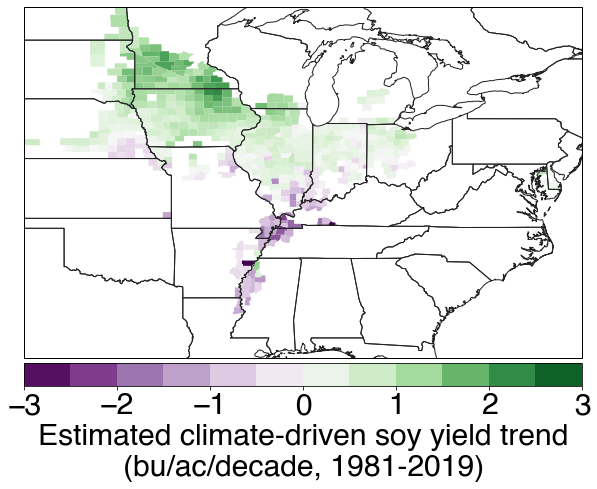

In [309]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -3
    v2 = 3.1
    vstep = .5
    vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = soybeanYieldChgFeedbackWithAgInt[ind[0]]/soybeanMeanYieldAll[ind[0]]*100
        else:
            curVal = soybeanYieldChgFeedbackWithAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Climate-driven soybean yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated climate-driven soy yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('climate-driven-soybean-yield-change-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [39]:
np.nanmedian(soybeanYieldChgFeedbackWithAgInt[adjNn])

0.37822605502615236

In [40]:
np.nanmedian(soybeanYieldChgFeedbackWithoutAgInt[adjNn])

-0.00020007037907610048

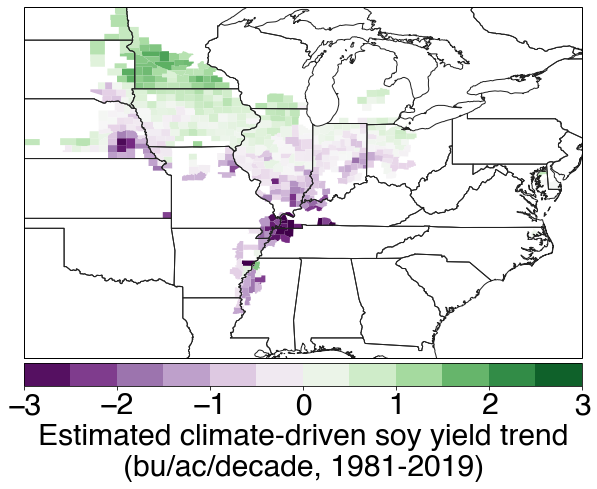

In [38]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -3
    v2 = 3.1
    vstep = .5
    vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = soybeanYieldChgFeedbackWithoutAgInt[ind[0]]/soybeanMeanYieldAll[ind[0]]*100
        else:
            curVal = soybeanYieldChgFeedbackWithoutAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Climate-driven soybean yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated climate-driven soy yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('climate-driven-soybean-yield-change-no-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 71
vstep = 2
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = kddChgFeedbackWithAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Observed, with ag-int', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('kdd-change-ag-int.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

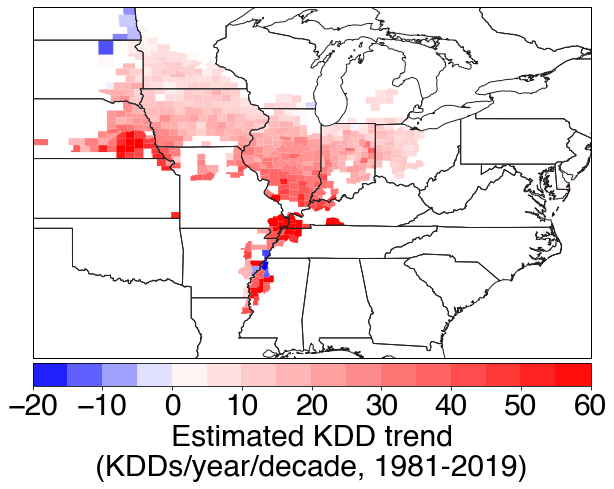

In [84]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -20
v2 = 61
vstep = 5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = kddChgFeedbackWithoutAgInt[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Estimated, without ag-int', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated KDD trend\n(KDDs/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('kdd-change-no-ag-int.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.02)

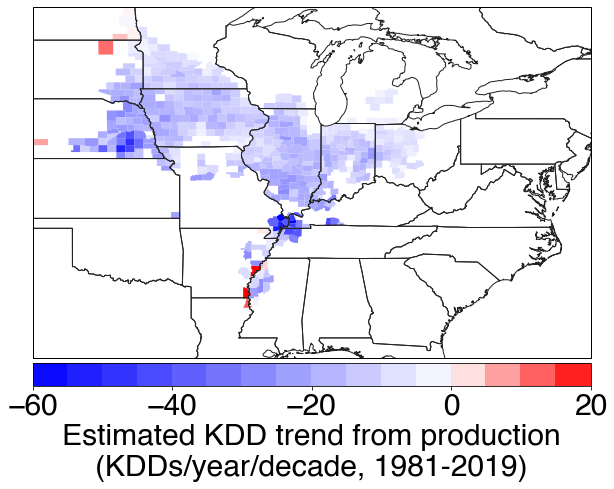

In [287]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -50
    v2 = 11
    vcenter = 0
    vstep = 2
    vlabelstep = 10
else:
    v1 = -60
    v2 = 20.1
    vcenter = 0
    vstep = 5
    vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = kddFromFeedback[ind[0]]/meanKddAll[ind[0]]*100
        else:
            curVal = kddFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('KDD trend from production\n(%/decade, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated KDD trend from production\n(KDDs/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('kdd-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 50
v2 = 171
vcenter = (v1+v2)/2
vstep = 5
vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = maizeYieldMeanAll[ind[0]]

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))

            if len(ind) > 0 and ind[0] in adjNn:
                ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(midnorm(curVal))))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean yield (bu/ac, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('us-mean-yield-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

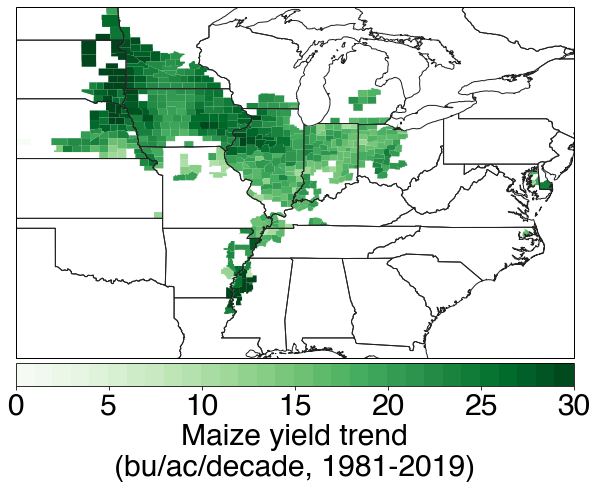

In [310]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 30.1
vcenter = (v1+v2)/2
vstep = 1
vlabelstep = 5
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        
        # convert bu/ac to kg/ac
        curVal = maizeYieldTrendAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-maize-yield-trend-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [318]:
np.nanmedian(maizeYieldTrendAll[adjNn])

20.926742532005697

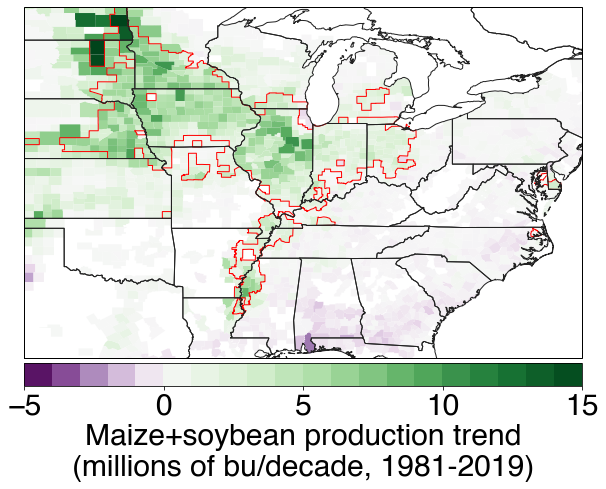

In [297]:
mapFontSize=30

from shapely.geometry import Polygon

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -5
v2 = 15.1
vcenter = 0
vstep = 1
vlabelstep = 5
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

# build merged polygon for included region
includedPolys = []
irExcludedPolys = []
for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        if ind[0] in adjNn:
            try:
                includedPolys.append(Polygon(county.geometry))
            except:
                includedPolys.extend([Polygon(x) for x in county.geometry])
                
        if curFips in irExclude:
            try:
                irExcludedPolys.append(Polygon(county.geometry))
            except:
                irExcludedPolys.extend([Polygon(x) for x in county.geometry])
            
polyUnionIncludedRegion = shapely.ops.cascaded_union(includedPolys)
polyUnionIrExcludedRegion = shapely.ops.cascaded_union(irExcludedPolys)



for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = totalProdTrendAll[ind[0]]*10/1e6

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))

#             if len(ind) > 0:
#                 if curFips in irExclude:
#                     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor=cmap(midnorm(curVal))))

ax.add_feature(ShapelyFeature(polyUnionIncludedRegion, ccrs.PlateCarree(), edgecolor='red', lw=1, facecolor='none'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize+soybean production trend\n(millions of bu/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-prod-trend-maize-soy-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

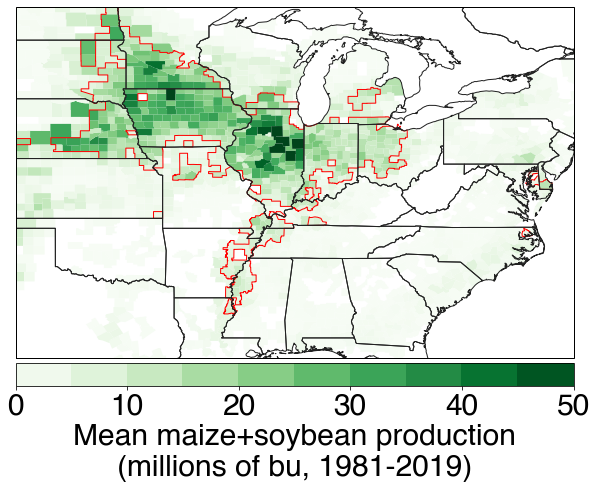

In [298]:
mapFontSize=30

from shapely.geometry import Polygon

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 50.1
vcenter = (v1+v2)/2
vstep = 5
vlabelstep = 10
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

# build merged polygon for included region
includedPolys = []
irExcludedPolys = []
for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        if ind[0] in adjNn:
            try:
                includedPolys.append(Polygon(county.geometry))
            except:
                includedPolys.extend([Polygon(x) for x in county.geometry])
                
        if curFips in irExclude:
            try:
                irExcludedPolys.append(Polygon(county.geometry))
            except:
                irExcludedPolys.extend([Polygon(x) for x in county.geometry])
            
polyUnionIncludedRegion = shapely.ops.cascaded_union(includedPolys)
polyUnionIrExcludedRegion = shapely.ops.cascaded_union(irExcludedPolys)


for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = totalProdMeanAll[ind[0]]/1e6

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor=None, lw=0, facecolor=cmap(midnorm(curVal))))

#             if curFips in irExclude:
#                 ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor=cmap(midnorm(curVal))))

ax.add_feature(ShapelyFeature(polyUnionIncludedRegion, ccrs.PlateCarree(), edgecolor='red', lw=1, facecolor='none'))
# ax.add_feature(ShapelyFeature(polyUnionIrExcludedRegion, ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor='none'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean maize+soybean production\n(millions of bu, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-prod-maize-soy-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

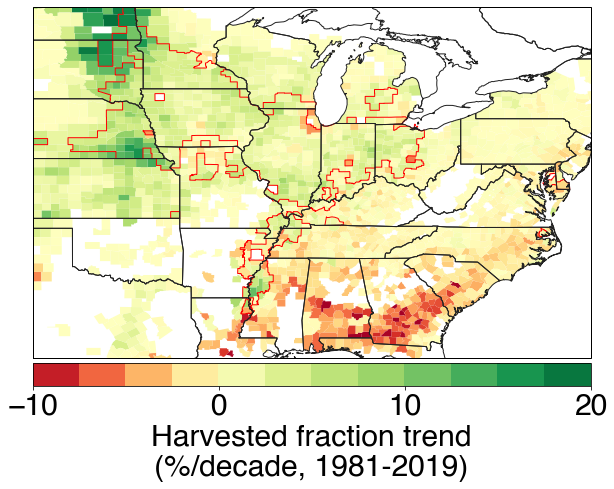

In [74]:
mapFontSize=30

from shapely.geometry import Polygon

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 20.1
vcenter = 0
vstep = 2.5
vlabelstep = 10
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('RdYlGn')

# build merged polygon for included region
includedPolys = []
# irExcludedPolys = []
for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        if ind[0] in adjNn:
            try:
                includedPolys.append(Polygon(county.geometry))
            except:
                includedPolys.extend([Polygon(x) for x in county.geometry])
                
#         if curFips in irExclude:
#             try:
#                 irExcludedPolys.append(Polygon(county.geometry))
#             except:
#                 irExcludedPolys.extend([Polygon(x) for x in county.geometry])
            
polyUnionIncludedRegion = shapely.ops.cascaded_union(includedPolys)
# polyUnionIrExcludedRegion = shapely.ops.cascaded_union(irExcludedPolys)


for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = totalHaTrendAll[ind[0]]/countyAcAll[ind[0]]*100*10

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor=None, lw=0, facecolor=cmap(midnorm(curVal))))

#             if curFips in irExclude:
#                 ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor=cmap(midnorm(curVal))))

ax.add_feature(ShapelyFeature(polyUnionIncludedRegion, ccrs.PlateCarree(), edgecolor='red', lw=1, facecolor='none'))
# ax.add_feature(ShapelyFeature(polyUnionIrExcludedRegion, ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor='none'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Harvested fraction trend\n(%/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-ha-frac-trend-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

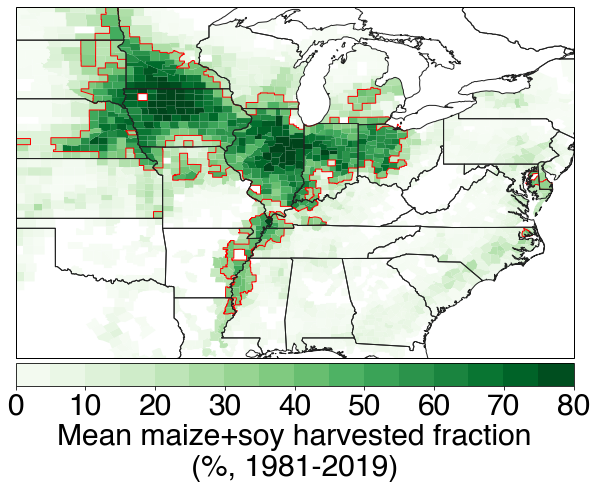

In [75]:
mapFontSize=30

from shapely.geometry import Polygon

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 80.1
vcenter = (v1+v2)/2
vstep = 5
vlabelstep = 10
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

# build merged polygon for included region
includedPolys = []
# irExcludedPolys = []
for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        if ind[0] in adjNn:
            try:
                includedPolys.append(Polygon(county.geometry))
            except:
                includedPolys.extend([Polygon(x) for x in county.geometry])
                
#         if curFips in irExclude:
#             try:
#                 irExcludedPolys.append(Polygon(county.geometry))
#             except:
#                 irExcludedPolys.extend([Polygon(x) for x in county.geometry])
            
polyUnionIncludedRegion = shapely.ops.cascaded_union(includedPolys)
# polyUnionIrExcludedRegion = shapely.ops.cascaded_union(irExcludedPolys)


for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsAll == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = haTotalAllAc[ind[0]]/countyAcAll[ind[0]]*100

        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor=None, lw=0, facecolor=cmap(midnorm(curVal))))

ax.add_feature(ShapelyFeature(polyUnionIncludedRegion, ccrs.PlateCarree(), edgecolor='red', lw=1, facecolor='none'))
# ax.add_feature(ShapelyFeature(polyUnionIrExcludedRegion, ccrs.PlateCarree(), edgecolor='blue', lw=1, facecolor='none'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean maize+soy harvested fraction\n(%, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-ha-frac-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [113]:
hfrac = haTotalAllAc[adjNn]/countyAcAll[adjNn]*100
ind=np.where(hfrac>75)[0]
len(ind)/len(adjNn)

0.11961722488038277

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 10
v2 = 56
vcenter = (v1+v2)/2
vstep = 2.5
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        
        # convert bu/ac to kg/ac
        curVal = soybeanYieldMeanAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield (bu/ac, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('us-mean-yield-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

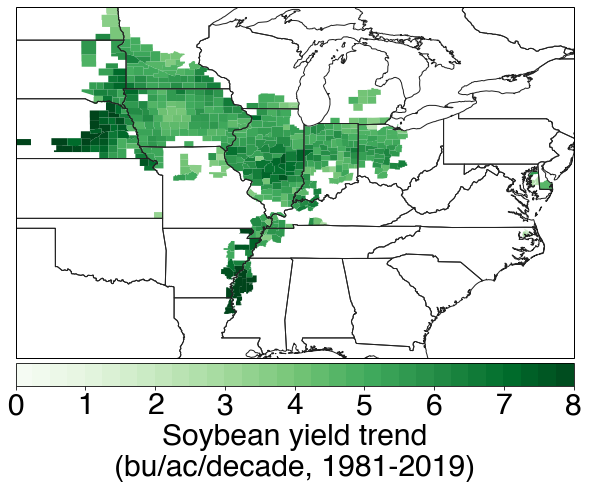

In [311]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 8.1
vcenter = (v1+v2)/2
vstep = .25
vlabelstep = 1
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        
        curVal = soybeanYieldTrendAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-soybean-yield-trend-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.01)

In [317]:
np.nanmedian(soybeanYieldTrendAll[adjNn])

5.4080862238756975

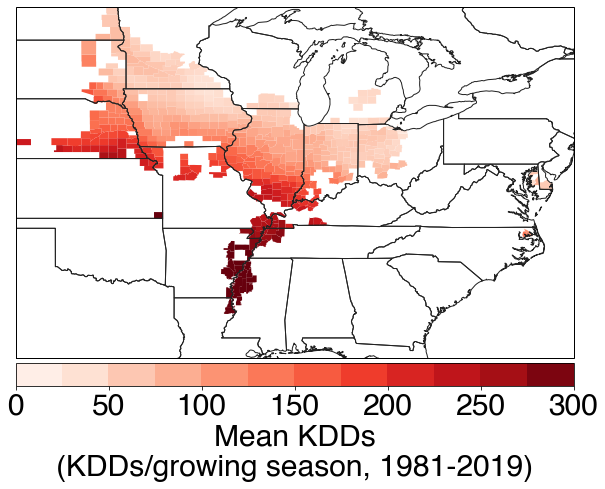

In [299]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 301
vcenter = (v1+v2)/2
vstep = 25
vlabelstep = 50

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = meanKddAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean KDDs\n(KDDs/growing season, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-mean-kdd-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.02)

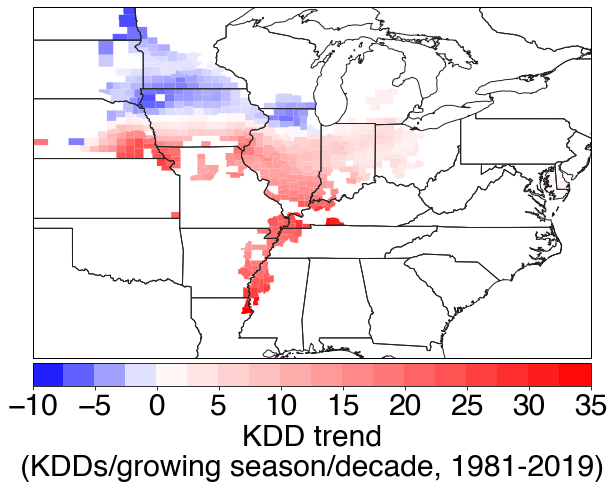

In [300]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])

v1 = -10
v2 = 35.1
vcenter = 0
vstep = 2.5
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = kddTrendAll[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='gray', facecolor='white'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    # ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD trend\n(KDDs/growing season/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('kdd-trend-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.02)

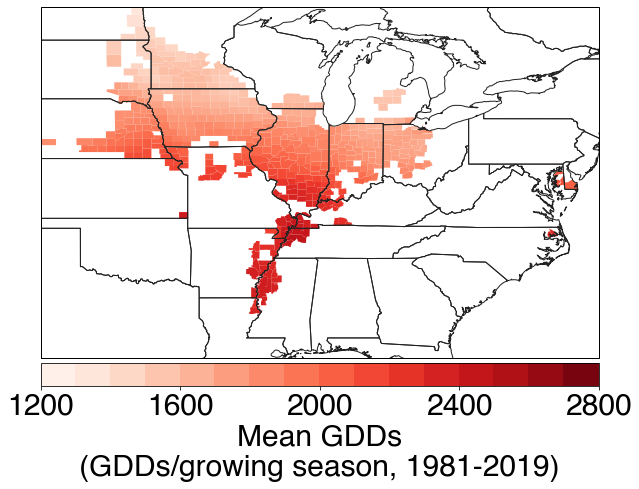

In [301]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 1200
v2 = 2801
vcenter = (v1+v2)/2
vstep = 100
vlabelstep = 400

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = meanGddAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean GDDs\n(GDDs/growing season, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-mean-gdd-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.01)

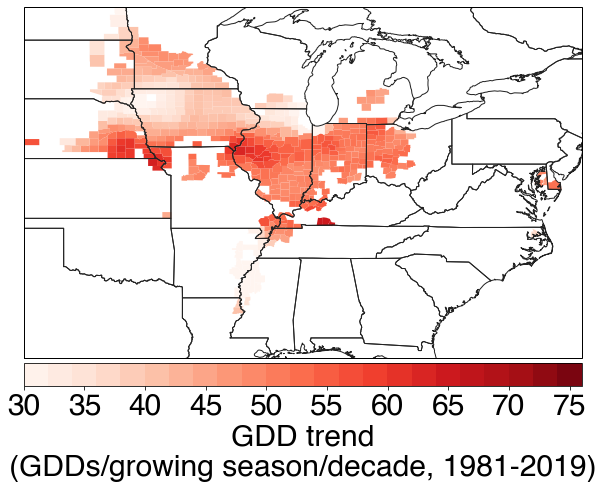

In [302]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 30
v2 = 77
vcenter = (v1+v2)/2
vstep = 2
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = gddTrendAll[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='gray', facecolor='white'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('GDD trend\n(GDDs/growing season/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-trend-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -10
    v2 = 11
    vstep = 2
else:
    v1 = -10
    v2 = 83
    vstep = 3
    vlabelstep = 10

vcenter = 0

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = gddChgFeedbackWithAgInt[ind[0]]/meanGddAll[ind[0]]*100
        else:
            curVal = gddChgFeedbackWithAgInt[ind[0]]
#         curVal = gddFromFeedback[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('GDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-change-ag-int.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

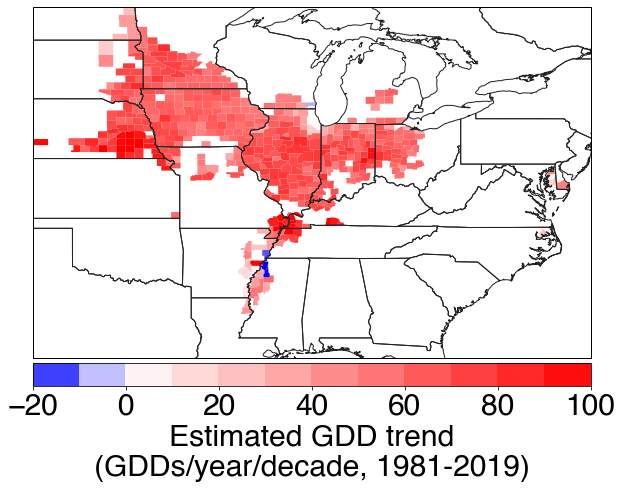

In [85]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -10
    v2 = 11
    vstep = 2
else:
    v1 = -20
    v2 = 101
    vstep = 10
    vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = gddChgFeedbackWithoutAgInt[ind[0]]/meanGddAll[ind[0]]*100
        else:
            curVal = gddChgFeedbackWithoutAgInt[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('No agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated GDD trend\n(GDDs/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-change-no-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.02)

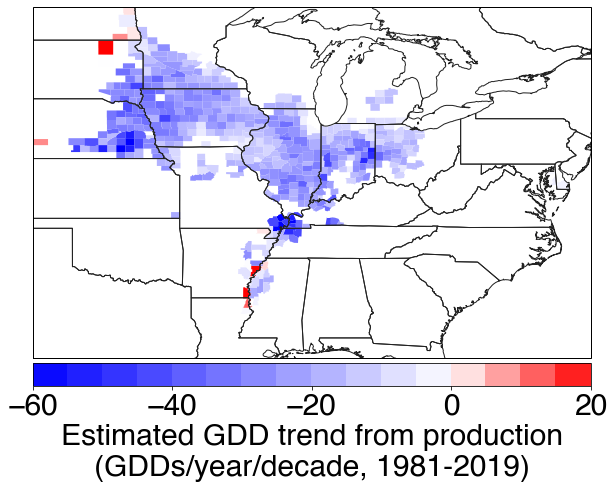

In [289]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -4
    v2 = 1.1
    vcenter = 0
    vstep = .25
    vlabelstep=1
else:
    v1 = -60
    v2 = 20.1
    vcenter = 0
    vstep = 5
    vlabelstep=20

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        if showPct:
            curVal = gddFromFeedback[ind[0]]/meanGddAll[ind[0]]*100
        else:
            curVal = gddFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('GDD trend from production\n(%/decade, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Estimated GDD trend from production\n(GDDs/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

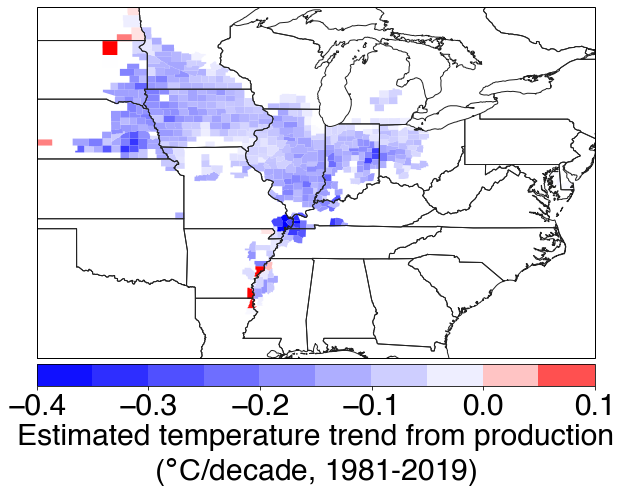

In [142]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

v1 = -.4
v2 = .11
vcenter = 0
vstep = .05
vlabelstep=.1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = tFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated temperature trend from production\n($\degree$C/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('t-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

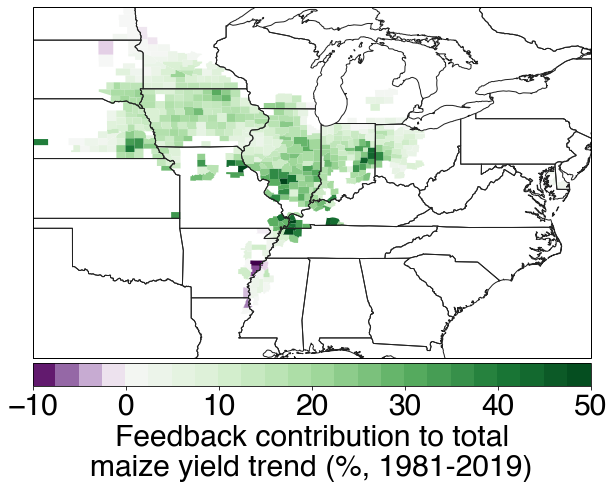

In [319]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 51
vcenter = 0
vstep = 2.5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curYieldTrendFrac = maizeYieldTrendFrac[ind[0]]
        if not np.isnan(curYieldTrendFrac) and abs(curYieldTrendFrac) <= 100:
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curYieldTrendFrac))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Feedback contribution to total\nmaize yield trend (%, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-maize-yield-trend-frac-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [56]:
np.nanmedian(maizeYieldTrendFrac)

13.619117850958709

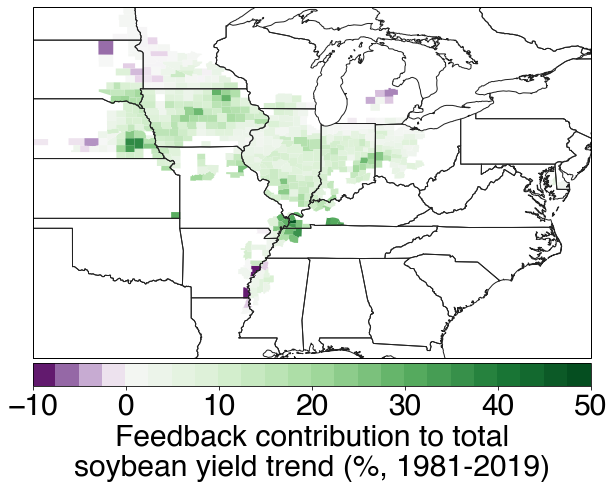

In [320]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 51
vcenter = 0
vstep = 2.5
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curYieldTrendFrac = soybeanYieldTrendFrac[ind[0]]
        if not np.isnan(curYieldTrendFrac) and abs(curYieldTrendFrac) <= 100:
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curYieldTrendFrac))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Feedback contribution to total\nsoybean yield trend (%, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-soybean-yield-trend-frac-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [55]:
np.nanmedian(soybeanYieldTrendFrac)

8.013366629646827

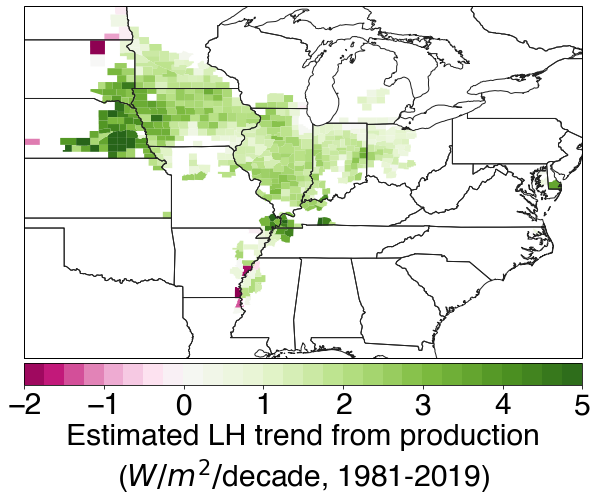

In [290]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -2
v2 = 5.1
vcenter = 0
vstep = .25
vlabelstep = 1


midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PiYG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = lhFromFeedback[ind[0]]#*2.264e6/countySeasonLenSec[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated LH trend from production\n($W/m^2/$decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('lh-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [ ]:
X = sm.add_constant(haTotalFracAll[adjNn])
mdl = sm.OLS(lhFromFeedback[adjNn], X).fit()

x1 = .1
x2 = .9

plt.figure(figsize=(6,6))
plt.xlim([0, 1])
plt.ylim([-2.5, 6.5])
plt.scatter(haTotalFracAll[adjNn], lhFromFeedback[adjNn])
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='p < 0.01')
plt.xlabel('Harvested fraction', fontsize=24)
plt.ylabel('LH from production\n($W/m^2$/decade)', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('lh-chg-from-prod-vs-ha-no-outliers.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

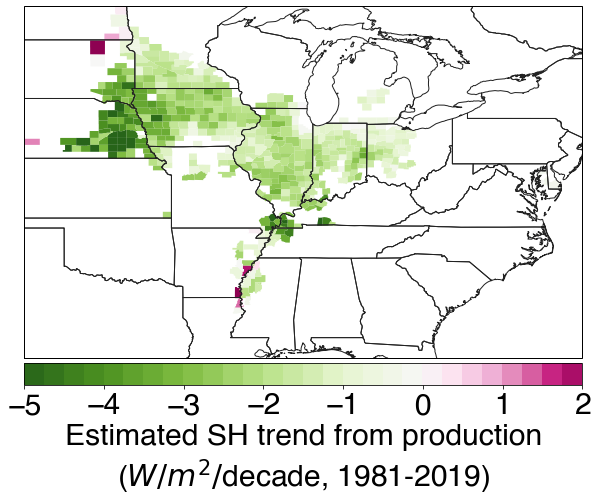

In [291]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -5
v2 = 2.1
vcenter = 0
vstep = .25
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PiYG_r')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        # convert from /ac to /m2
        curVal = shFromFeedback[ind[0]]#*2.264e6/countySeasonLenSec[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated SH trend from production\n($W/m^2/$decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('sh-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

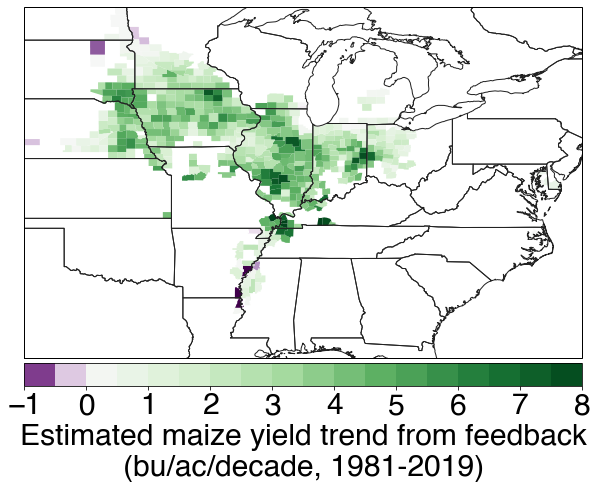

In [292]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 8.1
vcenter = 0
vstep = .5
vlabelstep=1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = maizeYieldFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated maize yield trend from feedback\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('maize-yield-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [59]:
np.nanmedian(maizeYieldFromFeedback)

2.852656095826922

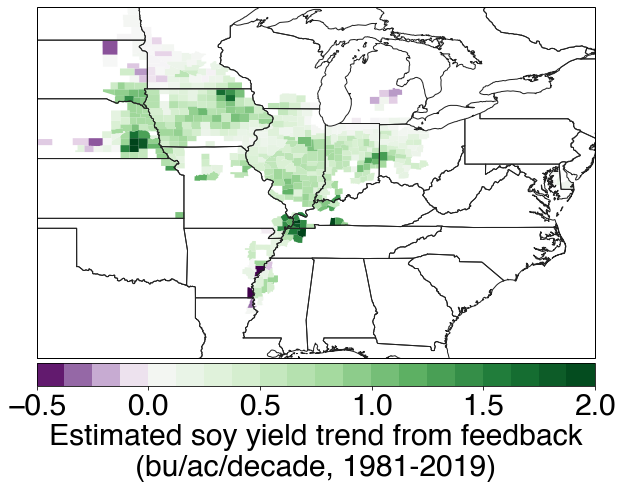

In [296]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.5
v2 = 2.01
vcenter = 0
vstep = .125
vlabelstep=.5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = soybeanYieldFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated soy yield trend from feedback\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('soybean-yield-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)

In [60]:
np.nanmedian(soybeanYieldFromFeedback)

0.4369276221199092

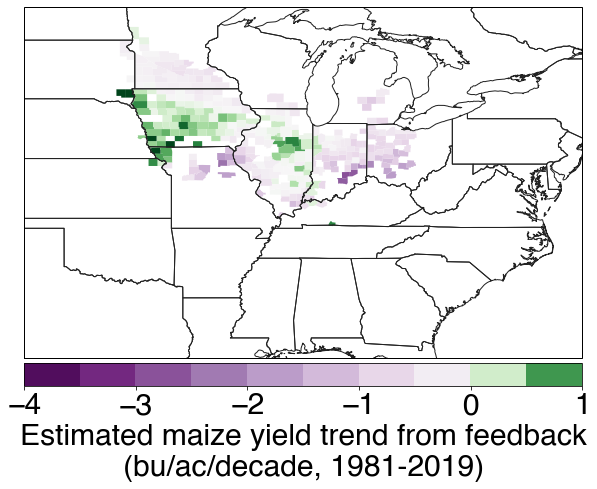

In [40]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])


v1 = -4
v2 = 1.1
vcenter = 0
vstep = .5
vlabelstep=1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0 and ind[0] in adjNn:
        curVal = maizeYieldFromProdTrend_HistGrowth[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Estimated maize yield trend from feedback\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('maize-yield-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0.01)